In [1]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

In [2]:
# !pip install mamba-ssm

In [3]:
data_path = '/content/combined_dataset-1.xlsx'
df = pd.read_excel(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657 entries, 0 to 656
Columns: 2114 entries, Num. to 2100
dtypes: float64(1), int64(2108), object(5)
memory usage: 10.6+ MB


In [4]:
df.head(10)

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,1,2,Female,45,152,63,161,89,97,27.268006,...,1766,1766,1766,1833,1833,1827,1827,1827,1754,1754
1,1,2,Female,45,152,63,161,89,97,27.268006,...,1985,1985,2026,2026,2026,1977,1977,1997,1997,1997
2,1,2,Female,45,152,63,161,89,97,27.268006,...,1942,1900,1900,1938,1938,1938,1924,1924,1929,1929
3,2,3,Female,50,157,50,160,93,76,20.284799,...,2073,2072,2072,2072,2051,2051,2036,2036,2036,2045
4,2,3,Female,50,157,50,160,93,76,20.284799,...,2021,2010,2010,2010,2001,2001,2003,2003,2003,1989
5,2,3,Female,50,157,50,160,93,76,20.284799,...,2020,2020,2032,2032,2032,2011,2011,2005,2005,2005
6,3,6,Female,47,150,47,101,71,79,20.888889,...,2047,2047,2017,2017,2017,2053,2053,2038,2038,2038
7,3,6,Female,47,150,47,101,71,79,20.888889,...,2076,2076,2051,2051,2051,2060,2060,2067,2067,2067
8,3,6,Female,47,150,47,101,71,79,20.888889,...,2163,2159,2159,2159,2175,2175,2168,2168,2168,2175
9,4,8,Male,45,172,65,136,93,87,21.971336,...,1985,1985,1985,1984,1984,1995,1995,1995,1972,1972


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Num.,657.0,110.000000,63.267362,1.0,55.0,110.0,165.0,219.0
subject_ID,657.0,156.598174,101.449344,2.0,85.0,152.0,215.0,419.0
Age(year),657.0,57.168950,15.850110,21.0,48.0,58.0,68.0,86.0
Height(cm),657.0,161.228311,8.190357,145.0,155.0,160.0,167.0,196.0
Weight(kg),657.0,60.191781,11.868168,36.0,52.0,60.0,67.0,103.0
...,...,...,...,...,...,...,...,...
2096,657.0,2085.436834,305.845135,1519.0,1904.0,2014.0,2180.0,3811.0
2097,657.0,2083.791476,304.297297,1515.0,1904.0,2012.0,2176.0,3787.0
2098,657.0,2084.803653,306.657540,1515.0,1904.0,2011.0,2175.0,3774.0
2099,657.0,2085.196347,306.275406,1515.0,1906.0,2012.0,2177.0,3775.0


In [6]:
df.shape

(657, 2114)

In [7]:
print (set(df.isnull().sum()))
df = df.fillna(method='ffill')
print (set(df.isnull().sum()))
df = df.fillna(method='bfill')
print (set(df.isnull().sum()))
df = df.fillna(df.mean)

{0, 597, 582, 543}
{0, 75, 72, 174}
{0}


<ipython-input-7-ee1b28275330>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
<ipython-input-7-ee1b28275330>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


In [8]:
meta_end_idx = df.columns.get_loc('cerebrovascular disease') + 1
meta_cols = df.columns[:meta_end_idx]
signal_cols = df.columns[meta_end_idx:]

print(f"metadata col # : {list(meta_cols)}")
print(f"signal data col # : {len(signal_cols)}")

metadata col # : ['Num.', 'subject_ID', 'Sex(M/F)', 'Age(year)', 'Height(cm)', 'Weight(kg)', 'Systolic Blood Pressure(mmHg)', 'Diastolic Blood Pressure(mmHg)', 'Heart Rate(b/m)', 'BMI(kg/m^2)', 'Hypertension', 'Diabetes', 'cerebral infarction', 'cerebrovascular disease']
signal data col # : 2100


In [9]:
target_cols = ['Systolic Blood Pressure(mmHg)', 'Diastolic Blood Pressure(mmHg)']

X_signals = df[signal_cols].values
y_bp = df[target_cols].values

print(f"signal data : {X_signals.shape}")
print(f"pressure data : {y_bp.shape}")

signal data : (657, 2100)
pressure data : (657, 2)


In [10]:
X_data = X_signals  # Shape: [num_samples, signal_length]
y_data = y_bp      # Shape: [num_samples, 2]

print(f"signal data : {X_data.shape}")
print(f"pressure data : {y_data.shape}")

# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")

signal data : (657, 2100)
pressure data : (657, 2)
train=(420, 2100), val=(105, 2100), test=(132, 2100)


In [11]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_val = scaler_X.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)
X_test = scaler_X.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

In [12]:
import torch
import torch.nn as nn
from mamba_ssm.modules.mamba_simple import Mamba

class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        norm = torch.norm(x, dim=-1, keepdim=True) * (x.shape[-1] ** -0.5)
        return x / (norm + self.eps) * self.weight

class DataEmbedding(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        # Use Conv1d to handle the input shape [batch, 1, seq_len]
        self.proj = nn.Conv1d(in_channels=1, out_channels=d_model, kernel_size=1)
        self.norm = nn.BatchNorm1d(d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # x: [batch, 1, seq_len]
        x = self.proj(x)  # [batch, d_model, seq_len]
        x = self.norm(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)  # [batch, seq_len, d_model]
        return x

# 단순화된 MambaBlock
class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4, expand=2, dropout=0.1):
        super().__init__()
        self.norm = RMSNorm(d_model)

        # mamba_ssm에서 직접 Mamba 모듈 사용
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # x: [B, seq_len, d_model]
        residual = x
        x = self.norm(x)
        x = self.mamba(x)
        x = self.dropout(x)
        return x + residual

# 전체 모델
class MambaModel(nn.Module):
    def __init__(self,
                 d_model=64,
                 n_layers=4,
                 d_state=16,
                 d_conv=4,
                 expand=2,
                 dropout=0.1,
                 dnn_hidden_dims=[256, 128, 64]):
        super().__init__()

        # Data embedding
        self.embedding = DataEmbedding(d_model, dropout)

        # Mamba 블록 스택
        self.layers = nn.ModuleList([
            MambaBlock(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand,
                dropout=dropout
            ) for _ in range(n_layers)
        ])

        # 최종 정규화
        self.norm = RMSNorm(d_model)

        # 혈압 예측을 위한 고급 출력 헤드
        projection_layers = []
        prev_dim = d_model * 2
        for hidden_dim in dnn_hidden_dims:
            projection_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.SiLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        projection_layers.append(nn.Linear(prev_dim, 2))

        self.projection = nn.Sequential(*projection_layers)

    def forward(self, x):
        # x shape: [batch, 1, seq_len]

        # 임베딩 적용
        x = self.embedding(x)  # [batch, seq_len, d_model]

        # Mamba 블록 적용
        for layer in self.layers:
            x = layer(x)

        # 최종 정규화
        x = self.norm(x)

        # 평균 및 최대 풀링
        mean_pooled = torch.mean(x, dim=1)  # [batch, d_model]
        max_pooled, _ = torch.max(x, dim=1)  # [batch, d_model]

        # 풀링된 특성 연결
        pooled = torch.cat([mean_pooled, max_pooled], dim=-1)  # [batch, d_model*2]

        # 혈압 값으로 예측
        bp_pred = self.projection(pooled)  # [batch, 2]

        return bp_pred

In [13]:
class BPDataset(Dataset):
    def __init__(self, signals, bp_values):
        self.signals = signals
        self.bp_values = bp_values

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = self.signals[idx]
        bp = self.bp_values[idx]

        # Reshape to [1, full_sequence_length]
        # This will become [batch_size, 1, full_sequence_length] after batching
        x = torch.FloatTensor(signal).unsqueeze(0)  # [1, full_sequence_length]
        y = torch.FloatTensor(bp)

        return x, y

train_dataset = BPDataset(X_train, y_train)
val_dataset = BPDataset(X_val, y_val)
test_dataset = BPDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}") # <--- data point
print(f"train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)}") # <-- batch

train=420, val=105, test=132
train=14, val=4, test=5


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device : {device}")

model = MambaModel(
    d_model=64,
    n_layers=2,
    d_state=16,
    d_conv=4,
    expand=2,
    dropout=0.05,
    dnn_hidden_dims=[512, 256, 128, 64, 32, 16]
).to(device)

print(f"# of parameters: {sum(p.numel() for p in model.parameters())}")

device : cuda
# of parameters: 308914


In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

In [16]:
train_losses = []
val_losses = []

num_epochs = 1000
best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    # 학습 모드
    model.train()
    train_loss = 0.0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

    for x, y in train_pbar:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_pbar.set_postfix({'batch_mse': f'{loss.item():.4f}'})

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # 평가 모드
    model.eval()
    val_loss = 0.0
    all_y_true = []
    all_y_pred = []
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]')

    with torch.no_grad():
        for x, y in val_pbar:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss += loss.item() * x.size(0)

            # MSE 계산을 위해 예측과 실제 값 저장
            all_y_true.append(y.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())

            val_pbar.set_postfix({'batch_mse': f'{loss.item():.4f}'})

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    # 수동으로 MSE 계산
    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)
    systolic_mse = np.mean((y_true[:, 0] - y_pred[:, 0])**2)
    diastolic_mse = np.mean((y_true[:, 1] - y_pred[:, 1])**2)
    combined_mse = np.mean((y_true - y_pred)**2)  # 전체 MSE

    scheduler.step(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train MSE: {train_loss:.4f}')
    print(f'  Val MSE: {val_loss:.4f}')
    print(f'  Val Systolic MSE: {systolic_mse:.4f}')
    print(f'  Val Diastolic MSE: {diastolic_mse:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'  Model saved with best Val MSE: {val_loss:.4f}')

Epoch 1/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 144.49it/s, batch_mse=11333.9199]


Epoch 1/1000:
  Train MSE: 10987.7019
  Val MSE: 10925.6318
  Val Systolic MSE: 16581.9492
  Val Diastolic MSE: 5269.3145
  Model saved with best Val MSE: 10925.6318


Epoch 2/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.04it/s, batch_mse=10889.5254]


Epoch 2/1000:
  Train MSE: 10826.7370
  Val MSE: 10449.1685
  Val Systolic MSE: 16022.5176
  Val Diastolic MSE: 4875.8184
  Model saved with best Val MSE: 10449.1685


Epoch 3/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.97it/s, batch_mse=10730.4600]


Epoch 3/1000:
  Train MSE: 10566.7972
  Val MSE: 10248.0147
  Val Systolic MSE: 15670.6621
  Val Diastolic MSE: 4825.3662
  Model saved with best Val MSE: 10248.0147


Epoch 4/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.56it/s, batch_mse=10351.8604]


Epoch 4/1000:
  Train MSE: 10160.8481
  Val MSE: 9998.1520
  Val Systolic MSE: 15546.1758
  Val Diastolic MSE: 4450.1284
  Model saved with best Val MSE: 9998.1520


Epoch 5/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.71it/s, batch_mse=8992.8750]


Epoch 5/1000:
  Train MSE: 9576.9925
  Val MSE: 8692.3741
  Val Systolic MSE: 13795.5283
  Val Diastolic MSE: 3589.2200
  Model saved with best Val MSE: 8692.3741


Epoch 6/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.03it/s, batch_mse=10067.8418]


Epoch 6/1000:
  Train MSE: 8809.6265
  Val MSE: 9713.2838
  Val Systolic MSE: 15055.4473
  Val Diastolic MSE: 4371.1196


Epoch 7/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.78it/s, batch_mse=8448.1465]


Epoch 7/1000:
  Train MSE: 7835.0479
  Val MSE: 8087.7001
  Val Systolic MSE: 13110.6699
  Val Diastolic MSE: 3064.7295
  Model saved with best Val MSE: 8087.7001


Epoch 8/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.96it/s, batch_mse=6755.9253]


Epoch 8/1000:
  Train MSE: 6829.9982
  Val MSE: 6698.5436
  Val Systolic MSE: 11178.1152
  Val Diastolic MSE: 2218.9697
  Model saved with best Val MSE: 6698.5436


Epoch 9/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.54it/s, batch_mse=5274.5244]


Epoch 9/1000:
  Train MSE: 5722.4791
  Val MSE: 5028.9271
  Val Systolic MSE: 8837.3770
  Val Diastolic MSE: 1220.4767
  Model saved with best Val MSE: 5028.9271


Epoch 10/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.14it/s, batch_mse=4336.8516]


Epoch 10/1000:
  Train MSE: 4616.2252
  Val MSE: 4163.5578
  Val Systolic MSE: 7354.8984
  Val Diastolic MSE: 972.2173
  Model saved with best Val MSE: 4163.5578


Epoch 11/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.47it/s, batch_mse=3468.2388]


Epoch 11/1000:
  Train MSE: 3598.3865
  Val MSE: 3306.6041
  Val Systolic MSE: 5951.8325
  Val Diastolic MSE: 661.3748
  Model saved with best Val MSE: 3306.6041


Epoch 12/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.61it/s, batch_mse=2745.1145]


Epoch 12/1000:
  Train MSE: 2839.5574
  Val MSE: 2517.9599
  Val Systolic MSE: 4751.9023
  Val Diastolic MSE: 284.0177
  Model saved with best Val MSE: 2517.9599


Epoch 13/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.69it/s, batch_mse=2101.0869]


Epoch 13/1000:
  Train MSE: 2101.7522
  Val MSE: 1851.1937
  Val Systolic MSE: 3516.5969
  Val Diastolic MSE: 185.7902
  Model saved with best Val MSE: 1851.1937


Epoch 14/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.42it/s, batch_mse=1524.7650]


Epoch 14/1000:
  Train MSE: 1582.3331
  Val MSE: 1582.6040
  Val Systolic MSE: 2974.1091
  Val Diastolic MSE: 191.0987
  Model saved with best Val MSE: 1582.6040


Epoch 15/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.91it/s, batch_mse=978.8425]


Epoch 15/1000:
  Train MSE: 1188.2975
  Val MSE: 1005.9493
  Val Systolic MSE: 1865.8335
  Val Diastolic MSE: 146.0651
  Model saved with best Val MSE: 1005.9493


Epoch 16/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.69it/s, batch_mse=906.3817]


Epoch 16/1000:
  Train MSE: 942.4464
  Val MSE: 863.4740
  Val Systolic MSE: 1507.7307
  Val Diastolic MSE: 219.2172
  Model saved with best Val MSE: 863.4740


Epoch 17/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.07it/s, batch_mse=519.6857]


Epoch 17/1000:
  Train MSE: 717.0279
  Val MSE: 635.5224
  Val Systolic MSE: 1091.2598
  Val Diastolic MSE: 179.7852
  Model saved with best Val MSE: 635.5224


Epoch 18/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.59it/s, batch_mse=869.8473]


Epoch 18/1000:
  Train MSE: 578.9153
  Val MSE: 724.5145
  Val Systolic MSE: 1270.0536
  Val Diastolic MSE: 178.9755


Epoch 19/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.46it/s, batch_mse=755.3901]


Epoch 19/1000:
  Train MSE: 515.7462
  Val MSE: 703.6444
  Val Systolic MSE: 1211.7120
  Val Diastolic MSE: 195.5767


Epoch 20/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.05it/s, batch_mse=309.4729]


Epoch 20/1000:
  Train MSE: 469.4815
  Val MSE: 447.5694
  Val Systolic MSE: 704.2344
  Val Diastolic MSE: 190.9044
  Model saved with best Val MSE: 447.5694


Epoch 21/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.50it/s, batch_mse=238.5340]


Epoch 21/1000:
  Train MSE: 443.2810
  Val MSE: 388.1367
  Val Systolic MSE: 622.8710
  Val Diastolic MSE: 153.4025
  Model saved with best Val MSE: 388.1367


Epoch 22/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.43it/s, batch_mse=228.1637]


Epoch 22/1000:
  Train MSE: 357.4324
  Val MSE: 364.0972
  Val Systolic MSE: 575.8807
  Val Diastolic MSE: 152.3136
  Model saved with best Val MSE: 364.0972


Epoch 23/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.10it/s, batch_mse=287.6851]


Epoch 23/1000:
  Train MSE: 369.0837
  Val MSE: 485.5386
  Val Systolic MSE: 772.9450
  Val Diastolic MSE: 198.1322


Epoch 24/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.45it/s, batch_mse=286.8542]


Epoch 24/1000:
  Train MSE: 375.1447
  Val MSE: 338.0771
  Val Systolic MSE: 538.7869
  Val Diastolic MSE: 137.3672
  Model saved with best Val MSE: 338.0771


Epoch 25/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.93it/s, batch_mse=194.2531]


Epoch 25/1000:
  Train MSE: 351.7526
  Val MSE: 285.1955
  Val Systolic MSE: 440.2080
  Val Diastolic MSE: 130.1830
  Model saved with best Val MSE: 285.1955


Epoch 26/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.78it/s, batch_mse=207.3337]


Epoch 26/1000:
  Train MSE: 309.3181
  Val MSE: 281.4235
  Val Systolic MSE: 436.5608
  Val Diastolic MSE: 126.2862
  Model saved with best Val MSE: 281.4235


Epoch 27/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.09it/s, batch_mse=167.4654]


Epoch 27/1000:
  Train MSE: 345.2048
  Val MSE: 282.0554
  Val Systolic MSE: 437.7442
  Val Diastolic MSE: 126.3666


Epoch 28/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.30it/s, batch_mse=117.3996]


Epoch 28/1000:
  Train MSE: 349.9166
  Val MSE: 262.8073
  Val Systolic MSE: 402.0910
  Val Diastolic MSE: 123.5236
  Model saved with best Val MSE: 262.8073


Epoch 29/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.18it/s, batch_mse=163.7029]


Epoch 29/1000:
  Train MSE: 327.3090
  Val MSE: 255.4824
  Val Systolic MSE: 397.0303
  Val Diastolic MSE: 113.9346
  Model saved with best Val MSE: 255.4824


Epoch 30/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.90it/s, batch_mse=136.8022]


Epoch 30/1000:
  Train MSE: 330.1574
  Val MSE: 279.2321
  Val Systolic MSE: 424.8851
  Val Diastolic MSE: 133.5792


Epoch 31/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.89it/s, batch_mse=233.0847]


Epoch 31/1000:
  Train MSE: 294.8577
  Val MSE: 284.5921
  Val Systolic MSE: 441.7796
  Val Diastolic MSE: 127.4046


Epoch 32/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.68it/s, batch_mse=212.1461]


Epoch 32/1000:
  Train MSE: 314.0137
  Val MSE: 262.2306
  Val Systolic MSE: 395.6323
  Val Diastolic MSE: 128.8290


Epoch 33/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.49it/s, batch_mse=158.2706]


Epoch 33/1000:
  Train MSE: 334.8646
  Val MSE: 270.2996
  Val Systolic MSE: 404.4662
  Val Diastolic MSE: 136.1330


Epoch 34/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.25it/s, batch_mse=179.4628]


Epoch 34/1000:
  Train MSE: 329.1049
  Val MSE: 256.9328
  Val Systolic MSE: 393.0100
  Val Diastolic MSE: 120.8557


Epoch 35/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.27it/s, batch_mse=142.0337]


Epoch 35/1000:
  Train MSE: 305.8907
  Val MSE: 250.7891
  Val Systolic MSE: 379.0803
  Val Diastolic MSE: 122.4979
  Model saved with best Val MSE: 250.7891


Epoch 36/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.51it/s, batch_mse=165.8508]


Epoch 36/1000:
  Train MSE: 328.5108
  Val MSE: 255.7655
  Val Systolic MSE: 387.8311
  Val Diastolic MSE: 123.6999


Epoch 37/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.11it/s, batch_mse=148.0794]


Epoch 37/1000:
  Train MSE: 300.4239
  Val MSE: 256.1620
  Val Systolic MSE: 388.1989
  Val Diastolic MSE: 124.1250


Epoch 38/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.28it/s, batch_mse=133.9231]


Epoch 38/1000:
  Train MSE: 307.4524
  Val MSE: 246.7892
  Val Systolic MSE: 371.5892
  Val Diastolic MSE: 121.9891
  Model saved with best Val MSE: 246.7892


Epoch 39/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.62it/s, batch_mse=143.3313]


Epoch 39/1000:
  Train MSE: 357.7713
  Val MSE: 247.7544
  Val Systolic MSE: 372.1386
  Val Diastolic MSE: 123.3701


Epoch 40/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.51it/s, batch_mse=138.2825]


Epoch 40/1000:
  Train MSE: 312.0931
  Val MSE: 232.6741
  Val Systolic MSE: 345.6967
  Val Diastolic MSE: 119.6515
  Model saved with best Val MSE: 232.6741


Epoch 41/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.49it/s, batch_mse=140.1537]


Epoch 41/1000:
  Train MSE: 292.5819
  Val MSE: 239.1607
  Val Systolic MSE: 361.7245
  Val Diastolic MSE: 116.5969


Epoch 42/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.52it/s, batch_mse=156.0378]


Epoch 42/1000:
  Train MSE: 338.2687
  Val MSE: 249.5160
  Val Systolic MSE: 374.4349
  Val Diastolic MSE: 124.5970


Epoch 43/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.28it/s, batch_mse=282.2497]


Epoch 43/1000:
  Train MSE: 367.9578
  Val MSE: 285.5668
  Val Systolic MSE: 444.7904
  Val Diastolic MSE: 126.3432


Epoch 44/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.35it/s, batch_mse=180.0623]


Epoch 44/1000:
  Train MSE: 334.6412
  Val MSE: 255.4974
  Val Systolic MSE: 392.7910
  Val Diastolic MSE: 118.2039


Epoch 45/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.40it/s, batch_mse=163.9186]


Epoch 45/1000:
  Train MSE: 322.1587
  Val MSE: 266.1706
  Val Systolic MSE: 414.1994
  Val Diastolic MSE: 118.1417


Epoch 46/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.13it/s, batch_mse=145.9074]


Epoch 46/1000:
  Train MSE: 323.2048
  Val MSE: 263.6859
  Val Systolic MSE: 408.7494
  Val Diastolic MSE: 118.6224


Epoch 47/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.01it/s, batch_mse=133.9146]


Epoch 47/1000:
  Train MSE: 346.3602
  Val MSE: 256.2806
  Val Systolic MSE: 395.4052
  Val Diastolic MSE: 117.1561


Epoch 48/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.22it/s, batch_mse=163.8659]


Epoch 48/1000:
  Train MSE: 314.6499
  Val MSE: 268.3699
  Val Systolic MSE: 413.8323
  Val Diastolic MSE: 122.9074


Epoch 49/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.57it/s, batch_mse=132.6924]


Epoch 49/1000:
  Train MSE: 335.2838
  Val MSE: 248.7363
  Val Systolic MSE: 383.3158
  Val Diastolic MSE: 114.1568


Epoch 50/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.77it/s, batch_mse=189.4115]


Epoch 50/1000:
  Train MSE: 329.9801
  Val MSE: 260.5217
  Val Systolic MSE: 404.6493
  Val Diastolic MSE: 116.3941


Epoch 51/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.47it/s, batch_mse=158.0818]


Epoch 51/1000:
  Train MSE: 312.3920
  Val MSE: 249.4360
  Val Systolic MSE: 384.9669
  Val Diastolic MSE: 113.9052


Epoch 52/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.75it/s, batch_mse=162.6380]


Epoch 52/1000:
  Train MSE: 319.2404
  Val MSE: 258.8186
  Val Systolic MSE: 402.2710
  Val Diastolic MSE: 115.3663


Epoch 53/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.96it/s, batch_mse=161.2779]


Epoch 53/1000:
  Train MSE: 330.6168
  Val MSE: 265.3905
  Val Systolic MSE: 411.0345
  Val Diastolic MSE: 119.7465


Epoch 54/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.76it/s, batch_mse=136.9036]


Epoch 54/1000:
  Train MSE: 331.9054
  Val MSE: 258.5791
  Val Systolic MSE: 398.8685
  Val Diastolic MSE: 118.2896


Epoch 55/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.53it/s, batch_mse=146.8630]


Epoch 55/1000:
  Train MSE: 325.8694
  Val MSE: 252.4627
  Val Systolic MSE: 391.4711
  Val Diastolic MSE: 113.4543


Epoch 56/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.52it/s, batch_mse=166.3146]


Epoch 56/1000:
  Train MSE: 293.5542
  Val MSE: 265.2061
  Val Systolic MSE: 412.4721
  Val Diastolic MSE: 117.9401


Epoch 57/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.78it/s, batch_mse=149.7686]


Epoch 57/1000:
  Train MSE: 316.2466
  Val MSE: 246.0188
  Val Systolic MSE: 377.9304
  Val Diastolic MSE: 114.1072


Epoch 58/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.65it/s, batch_mse=180.3445]


Epoch 58/1000:
  Train MSE: 308.8115
  Val MSE: 264.2480
  Val Systolic MSE: 405.3330
  Val Diastolic MSE: 123.1630


Epoch 59/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.11it/s, batch_mse=153.6439]


Epoch 59/1000:
  Train MSE: 308.2256
  Val MSE: 263.5334
  Val Systolic MSE: 406.4165
  Val Diastolic MSE: 120.6503


Epoch 60/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.10it/s, batch_mse=171.6695]


Epoch 60/1000:
  Train MSE: 326.3787
  Val MSE: 257.3567
  Val Systolic MSE: 397.8797
  Val Diastolic MSE: 116.8338


Epoch 61/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.60it/s, batch_mse=177.0140]


Epoch 61/1000:
  Train MSE: 301.8764
  Val MSE: 264.9900
  Val Systolic MSE: 409.6563
  Val Diastolic MSE: 120.3238


Epoch 62/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.50it/s, batch_mse=155.2424]


Epoch 62/1000:
  Train MSE: 322.2775
  Val MSE: 256.1371
  Val Systolic MSE: 393.7401
  Val Diastolic MSE: 118.5341


Epoch 63/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.17it/s, batch_mse=139.7535]


Epoch 63/1000:
  Train MSE: 317.3835
  Val MSE: 252.0768
  Val Systolic MSE: 388.6607
  Val Diastolic MSE: 115.4928


Epoch 64/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.80it/s, batch_mse=142.6090]


Epoch 64/1000:
  Train MSE: 319.0593
  Val MSE: 254.6660
  Val Systolic MSE: 390.7583
  Val Diastolic MSE: 118.5737


Epoch 65/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.78it/s, batch_mse=128.6165]


Epoch 65/1000:
  Train MSE: 315.3931
  Val MSE: 258.6845
  Val Systolic MSE: 397.3242
  Val Diastolic MSE: 120.0447


Epoch 66/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.71it/s, batch_mse=135.0900]


Epoch 66/1000:
  Train MSE: 317.6636
  Val MSE: 255.4115
  Val Systolic MSE: 393.1403
  Val Diastolic MSE: 117.6827


Epoch 67/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.15it/s, batch_mse=153.5429]


Epoch 67/1000:
  Train MSE: 312.5821
  Val MSE: 264.4032
  Val Systolic MSE: 409.7092
  Val Diastolic MSE: 119.0971


Epoch 68/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.58it/s, batch_mse=150.6064]


Epoch 68/1000:
  Train MSE: 314.8131
  Val MSE: 260.1794
  Val Systolic MSE: 399.6068
  Val Diastolic MSE: 120.7520


Epoch 69/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.92it/s, batch_mse=151.0152]


Epoch 69/1000:
  Train MSE: 325.8209
  Val MSE: 263.1838
  Val Systolic MSE: 404.8525
  Val Diastolic MSE: 121.5152


Epoch 70/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.41it/s, batch_mse=122.9970]


Epoch 70/1000:
  Train MSE: 306.8940
  Val MSE: 256.9907
  Val Systolic MSE: 394.3343
  Val Diastolic MSE: 119.6470


Epoch 71/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.52it/s, batch_mse=157.8762]


Epoch 71/1000:
  Train MSE: 327.3148
  Val MSE: 259.4651
  Val Systolic MSE: 397.7875
  Val Diastolic MSE: 121.1427


Epoch 72/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.42it/s, batch_mse=141.9827]


Epoch 72/1000:
  Train MSE: 324.1825
  Val MSE: 251.9164
  Val Systolic MSE: 386.4589
  Val Diastolic MSE: 117.3738


Epoch 73/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.57it/s, batch_mse=167.3329]


Epoch 73/1000:
  Train MSE: 299.8729
  Val MSE: 260.9051
  Val Systolic MSE: 404.3145
  Val Diastolic MSE: 117.4958


Epoch 74/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.96it/s, batch_mse=153.4834]


Epoch 74/1000:
  Train MSE: 297.9574
  Val MSE: 260.6058
  Val Systolic MSE: 400.9483
  Val Diastolic MSE: 120.2633


Epoch 75/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.95it/s, batch_mse=156.5265]


Epoch 75/1000:
  Train MSE: 310.8687
  Val MSE: 251.9649
  Val Systolic MSE: 387.2819
  Val Diastolic MSE: 116.6480


Epoch 76/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.66it/s, batch_mse=163.7951]


Epoch 76/1000:
  Train MSE: 321.7583
  Val MSE: 263.8141
  Val Systolic MSE: 403.9284
  Val Diastolic MSE: 123.6999


Epoch 77/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.31it/s, batch_mse=164.1449]


Epoch 77/1000:
  Train MSE: 318.7567
  Val MSE: 261.8777
  Val Systolic MSE: 402.5993
  Val Diastolic MSE: 121.1561


Epoch 78/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.20it/s, batch_mse=137.2189]


Epoch 78/1000:
  Train MSE: 306.4592
  Val MSE: 242.3907
  Val Systolic MSE: 371.3180
  Val Diastolic MSE: 113.4633


Epoch 79/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.49it/s, batch_mse=157.1067]


Epoch 79/1000:
  Train MSE: 330.5441
  Val MSE: 256.8779
  Val Systolic MSE: 392.6613
  Val Diastolic MSE: 121.0945


Epoch 80/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.91it/s, batch_mse=144.8662]


Epoch 80/1000:
  Train MSE: 322.3934
  Val MSE: 260.4929
  Val Systolic MSE: 401.8193
  Val Diastolic MSE: 119.1665


Epoch 81/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.38it/s, batch_mse=141.7472]


Epoch 81/1000:
  Train MSE: 331.6760
  Val MSE: 249.6177
  Val Systolic MSE: 382.3780
  Val Diastolic MSE: 116.8574


Epoch 82/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.32it/s, batch_mse=133.7033]


Epoch 82/1000:
  Train MSE: 306.8660
  Val MSE: 257.0508
  Val Systolic MSE: 394.4666
  Val Diastolic MSE: 119.6350


Epoch 83/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.91it/s, batch_mse=129.9230]


Epoch 83/1000:
  Train MSE: 302.8563
  Val MSE: 247.8945
  Val Systolic MSE: 382.4880
  Val Diastolic MSE: 113.3010


Epoch 84/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.74it/s, batch_mse=154.0476]


Epoch 84/1000:
  Train MSE: 309.6649
  Val MSE: 259.0158
  Val Systolic MSE: 399.4061
  Val Diastolic MSE: 118.6254


Epoch 85/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.09it/s, batch_mse=153.9599]


Epoch 85/1000:
  Train MSE: 310.0468
  Val MSE: 252.9989
  Val Systolic MSE: 388.9864
  Val Diastolic MSE: 117.0115


Epoch 86/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.37it/s, batch_mse=136.3270]


Epoch 86/1000:
  Train MSE: 315.9503
  Val MSE: 252.0633
  Val Systolic MSE: 383.8865
  Val Diastolic MSE: 120.2401


Epoch 87/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.92it/s, batch_mse=148.6133]


Epoch 87/1000:
  Train MSE: 318.3237
  Val MSE: 251.7519
  Val Systolic MSE: 387.0751
  Val Diastolic MSE: 116.4286


Epoch 88/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.80it/s, batch_mse=150.1439]


Epoch 88/1000:
  Train MSE: 310.2406
  Val MSE: 258.1545
  Val Systolic MSE: 397.2419
  Val Diastolic MSE: 119.0671


Epoch 89/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.55it/s, batch_mse=150.2968]


Epoch 89/1000:
  Train MSE: 318.1704
  Val MSE: 259.6896
  Val Systolic MSE: 400.0863
  Val Diastolic MSE: 119.2929


Epoch 90/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.63it/s, batch_mse=155.8248]


Epoch 90/1000:
  Train MSE: 314.9089
  Val MSE: 253.2595
  Val Systolic MSE: 393.0196
  Val Diastolic MSE: 113.4994


Epoch 91/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.19it/s, batch_mse=153.3975]


Epoch 91/1000:
  Train MSE: 316.0074
  Val MSE: 257.6440
  Val Systolic MSE: 396.3541
  Val Diastolic MSE: 118.9339


Epoch 92/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.80it/s, batch_mse=153.3114]


Epoch 92/1000:
  Train MSE: 321.9962
  Val MSE: 255.2736
  Val Systolic MSE: 392.3720
  Val Diastolic MSE: 118.1752


Epoch 93/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.00it/s, batch_mse=157.6588]


Epoch 93/1000:
  Train MSE: 306.5181
  Val MSE: 257.2275
  Val Systolic MSE: 395.6028
  Val Diastolic MSE: 118.8523


Epoch 94/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.04it/s, batch_mse=151.6178]


Epoch 94/1000:
  Train MSE: 311.9735
  Val MSE: 256.4478
  Val Systolic MSE: 395.8528
  Val Diastolic MSE: 117.0429


Epoch 95/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.07it/s, batch_mse=143.5423]


Epoch 95/1000:
  Train MSE: 320.1436
  Val MSE: 254.7028
  Val Systolic MSE: 390.9862
  Val Diastolic MSE: 118.4193


Epoch 96/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.76it/s, batch_mse=152.4001]


Epoch 96/1000:
  Train MSE: 304.6207
  Val MSE: 257.8904
  Val Systolic MSE: 396.2693
  Val Diastolic MSE: 119.5114


Epoch 97/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.00it/s, batch_mse=160.3743]


Epoch 97/1000:
  Train MSE: 315.0268
  Val MSE: 263.6060
  Val Systolic MSE: 405.7432
  Val Diastolic MSE: 121.4688


Epoch 98/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.95it/s, batch_mse=155.7121]


Epoch 98/1000:
  Train MSE: 286.7726
  Val MSE: 257.1294
  Val Systolic MSE: 397.5630
  Val Diastolic MSE: 116.6959


Epoch 99/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.84it/s, batch_mse=145.9905]


Epoch 99/1000:
  Train MSE: 295.9845
  Val MSE: 254.6683
  Val Systolic MSE: 390.7846
  Val Diastolic MSE: 118.5519


Epoch 100/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.16it/s, batch_mse=133.1727]


Epoch 100/1000:
  Train MSE: 326.9519
  Val MSE: 244.1810
  Val Systolic MSE: 376.9881
  Val Diastolic MSE: 111.3740


Epoch 101/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.31it/s, batch_mse=130.5866]


Epoch 101/1000:
  Train MSE: 310.9968
  Val MSE: 252.6938
  Val Systolic MSE: 387.3512
  Val Diastolic MSE: 118.0365


Epoch 102/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.84it/s, batch_mse=127.0038]


Epoch 102/1000:
  Train MSE: 321.2304
  Val MSE: 251.2015
  Val Systolic MSE: 387.4624
  Val Diastolic MSE: 114.9405


Epoch 103/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.64it/s, batch_mse=158.9315]


Epoch 103/1000:
  Train MSE: 300.2678
  Val MSE: 251.9208
  Val Systolic MSE: 386.0593
  Val Diastolic MSE: 117.7823


Epoch 104/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.59it/s, batch_mse=137.1328]


Epoch 104/1000:
  Train MSE: 310.7680
  Val MSE: 247.9783
  Val Systolic MSE: 380.3157
  Val Diastolic MSE: 115.6409


Epoch 105/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.53it/s, batch_mse=148.5663]


Epoch 105/1000:
  Train MSE: 296.0958
  Val MSE: 251.2754
  Val Systolic MSE: 387.5246
  Val Diastolic MSE: 115.0263


Epoch 106/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 152.00it/s, batch_mse=143.7035]


Epoch 106/1000:
  Train MSE: 332.1835
  Val MSE: 260.4440
  Val Systolic MSE: 401.6767
  Val Diastolic MSE: 119.2113


Epoch 107/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.82it/s, batch_mse=139.2891]


Epoch 107/1000:
  Train MSE: 312.2077
  Val MSE: 249.2825
  Val Systolic MSE: 384.7719
  Val Diastolic MSE: 113.7932


Epoch 108/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.74it/s, batch_mse=184.5820]


Epoch 108/1000:
  Train MSE: 291.7744
  Val MSE: 259.4961
  Val Systolic MSE: 400.1304
  Val Diastolic MSE: 118.8619


Epoch 109/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.46it/s, batch_mse=143.8064]


Epoch 109/1000:
  Train MSE: 311.8042
  Val MSE: 251.7821
  Val Systolic MSE: 387.3883
  Val Diastolic MSE: 116.1759


Epoch 110/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 155.88it/s, batch_mse=159.5276]


Epoch 110/1000:
  Train MSE: 316.3978
  Val MSE: 254.4376
  Val Systolic MSE: 392.6371
  Val Diastolic MSE: 116.2382


Epoch 111/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.43it/s, batch_mse=156.0947]


Epoch 111/1000:
  Train MSE: 306.7541
  Val MSE: 262.9401
  Val Systolic MSE: 402.5416
  Val Diastolic MSE: 123.3385


Epoch 112/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.15it/s, batch_mse=163.3749]


Epoch 112/1000:
  Train MSE: 360.8259
  Val MSE: 260.5716
  Val Systolic MSE: 405.4963
  Val Diastolic MSE: 115.6470


Epoch 113/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.33it/s, batch_mse=161.9952]


Epoch 113/1000:
  Train MSE: 314.2212
  Val MSE: 260.1572
  Val Systolic MSE: 399.0963
  Val Diastolic MSE: 121.2181


Epoch 114/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.18it/s, batch_mse=160.5916]


Epoch 114/1000:
  Train MSE: 311.0950
  Val MSE: 253.9405
  Val Systolic MSE: 389.2422
  Val Diastolic MSE: 118.6388


Epoch 115/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.67it/s, batch_mse=141.8272]


Epoch 115/1000:
  Train MSE: 335.4268
  Val MSE: 254.4661
  Val Systolic MSE: 390.7845
  Val Diastolic MSE: 118.1476


Epoch 116/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.16it/s, batch_mse=154.7484]


Epoch 116/1000:
  Train MSE: 307.1617
  Val MSE: 254.6667
  Val Systolic MSE: 391.8517
  Val Diastolic MSE: 117.4817


Epoch 117/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.42it/s, batch_mse=147.2478]


Epoch 117/1000:
  Train MSE: 346.5663
  Val MSE: 254.3415
  Val Systolic MSE: 390.3571
  Val Diastolic MSE: 118.3260


Epoch 118/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.71it/s, batch_mse=137.0756]


Epoch 118/1000:
  Train MSE: 339.5097
  Val MSE: 250.4748
  Val Systolic MSE: 383.3907
  Val Diastolic MSE: 117.5589


Epoch 119/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.27it/s, batch_mse=145.7262]


Epoch 119/1000:
  Train MSE: 323.7308
  Val MSE: 260.3663
  Val Systolic MSE: 400.3058
  Val Diastolic MSE: 120.4268


Epoch 120/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.75it/s, batch_mse=160.7427]


Epoch 120/1000:
  Train MSE: 320.7769
  Val MSE: 256.6407
  Val Systolic MSE: 396.3495
  Val Diastolic MSE: 116.9318


Epoch 121/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.41it/s, batch_mse=161.5127]


Epoch 121/1000:
  Train MSE: 297.6481
  Val MSE: 259.5826
  Val Systolic MSE: 398.7059
  Val Diastolic MSE: 120.4593


Epoch 122/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.25it/s, batch_mse=156.2692]


Epoch 122/1000:
  Train MSE: 305.8054
  Val MSE: 255.3557
  Val Systolic MSE: 391.8084
  Val Diastolic MSE: 118.9031


Epoch 123/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.34it/s, batch_mse=163.0855]


Epoch 123/1000:
  Train MSE: 313.4868
  Val MSE: 259.2359
  Val Systolic MSE: 397.5536
  Val Diastolic MSE: 120.9183


Epoch 124/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.35it/s, batch_mse=152.2537]


Epoch 124/1000:
  Train MSE: 316.6963
  Val MSE: 255.7984
  Val Systolic MSE: 395.4422
  Val Diastolic MSE: 116.1546


Epoch 125/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.90it/s, batch_mse=142.9275]


Epoch 125/1000:
  Train MSE: 317.0851
  Val MSE: 249.7566
  Val Systolic MSE: 385.3775
  Val Diastolic MSE: 114.1358


Epoch 126/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.84it/s, batch_mse=162.9537]


Epoch 126/1000:
  Train MSE: 298.5072
  Val MSE: 258.5873
  Val Systolic MSE: 399.5014
  Val Diastolic MSE: 117.6731


Epoch 127/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.85it/s, batch_mse=142.4065]


Epoch 127/1000:
  Train MSE: 295.1011
  Val MSE: 256.1764
  Val Systolic MSE: 392.8214
  Val Diastolic MSE: 119.5314


Epoch 128/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.57it/s, batch_mse=163.3006]


Epoch 128/1000:
  Train MSE: 308.3625
  Val MSE: 258.9868
  Val Systolic MSE: 397.8328
  Val Diastolic MSE: 120.1408


Epoch 129/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.21it/s, batch_mse=130.4124]


Epoch 129/1000:
  Train MSE: 306.8826
  Val MSE: 249.5382
  Val Systolic MSE: 381.8308
  Val Diastolic MSE: 117.2455


Epoch 130/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.46it/s, batch_mse=162.0642]


Epoch 130/1000:
  Train MSE: 319.0060
  Val MSE: 251.8922
  Val Systolic MSE: 388.7013
  Val Diastolic MSE: 115.0831


Epoch 131/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.39it/s, batch_mse=170.8111]


Epoch 131/1000:
  Train MSE: 314.8684
  Val MSE: 267.4077
  Val Systolic MSE: 412.3604
  Val Diastolic MSE: 122.4550


Epoch 132/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.90it/s, batch_mse=174.8038]


Epoch 132/1000:
  Train MSE: 302.7682
  Val MSE: 264.0355
  Val Systolic MSE: 407.3438
  Val Diastolic MSE: 120.7273


Epoch 133/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.63it/s, batch_mse=155.5772]


Epoch 133/1000:
  Train MSE: 322.5055
  Val MSE: 254.1480
  Val Systolic MSE: 391.5071
  Val Diastolic MSE: 116.7889


Epoch 134/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.83it/s, batch_mse=135.7051]


Epoch 134/1000:
  Train MSE: 319.0641
  Val MSE: 249.0903
  Val Systolic MSE: 384.4865
  Val Diastolic MSE: 113.6941


Epoch 135/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.54it/s, batch_mse=158.5756]


Epoch 135/1000:
  Train MSE: 309.0312
  Val MSE: 255.6510
  Val Systolic MSE: 395.8669
  Val Diastolic MSE: 115.4350


Epoch 136/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.61it/s, batch_mse=152.6476]


Epoch 136/1000:
  Train MSE: 312.7355
  Val MSE: 265.7825
  Val Systolic MSE: 409.8955
  Val Diastolic MSE: 121.6695


Epoch 137/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.44it/s, batch_mse=132.9819]


Epoch 137/1000:
  Train MSE: 314.4052
  Val MSE: 252.2318
  Val Systolic MSE: 388.0533
  Val Diastolic MSE: 116.4103


Epoch 138/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.08it/s, batch_mse=147.3670]


Epoch 138/1000:
  Train MSE: 324.5648
  Val MSE: 247.1107
  Val Systolic MSE: 378.1476
  Val Diastolic MSE: 116.0738


Epoch 139/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.06it/s, batch_mse=165.8947]


Epoch 139/1000:
  Train MSE: 311.9312
  Val MSE: 252.4626
  Val Systolic MSE: 391.1724
  Val Diastolic MSE: 113.7527


Epoch 140/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.03it/s, batch_mse=158.7041]


Epoch 140/1000:
  Train MSE: 319.1661
  Val MSE: 264.0778
  Val Systolic MSE: 408.1560
  Val Diastolic MSE: 119.9995


Epoch 141/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.80it/s, batch_mse=153.0214]


Epoch 141/1000:
  Train MSE: 311.0395
  Val MSE: 259.8737
  Val Systolic MSE: 399.8001
  Val Diastolic MSE: 119.9473


Epoch 142/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.11it/s, batch_mse=155.5582]


Epoch 142/1000:
  Train MSE: 306.4963
  Val MSE: 259.7315
  Val Systolic MSE: 400.4769
  Val Diastolic MSE: 118.9862


Epoch 143/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.94it/s, batch_mse=142.9992]


Epoch 143/1000:
  Train MSE: 292.4249
  Val MSE: 258.4883
  Val Systolic MSE: 398.4596
  Val Diastolic MSE: 118.5170


Epoch 144/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.38it/s, batch_mse=142.8758]


Epoch 144/1000:
  Train MSE: 297.1953
  Val MSE: 257.6871
  Val Systolic MSE: 395.8156
  Val Diastolic MSE: 119.5585


Epoch 145/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.34it/s, batch_mse=148.6292]


Epoch 145/1000:
  Train MSE: 326.6305
  Val MSE: 255.1470
  Val Systolic MSE: 391.0980
  Val Diastolic MSE: 119.1960


Epoch 146/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.82it/s, batch_mse=148.8840]


Epoch 146/1000:
  Train MSE: 309.7461
  Val MSE: 265.3375
  Val Systolic MSE: 407.2009
  Val Diastolic MSE: 123.4741


Epoch 147/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.81it/s, batch_mse=146.0979]


Epoch 147/1000:
  Train MSE: 327.0073
  Val MSE: 244.6645
  Val Systolic MSE: 375.6440
  Val Diastolic MSE: 113.6850


Epoch 148/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.85it/s, batch_mse=146.7504]


Epoch 148/1000:
  Train MSE: 307.9016
  Val MSE: 252.7411
  Val Systolic MSE: 389.5169
  Val Diastolic MSE: 115.9652


Epoch 149/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.84it/s, batch_mse=135.3838]


Epoch 149/1000:
  Train MSE: 312.2064
  Val MSE: 237.4150
  Val Systolic MSE: 363.5733
  Val Diastolic MSE: 111.2568


Epoch 150/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.70it/s, batch_mse=154.3787]


Epoch 150/1000:
  Train MSE: 315.2506
  Val MSE: 251.1442
  Val Systolic MSE: 385.7999
  Val Diastolic MSE: 116.4885


Epoch 151/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.70it/s, batch_mse=159.9532]


Epoch 151/1000:
  Train MSE: 321.8374
  Val MSE: 256.0161
  Val Systolic MSE: 394.3192
  Val Diastolic MSE: 117.7129


Epoch 152/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.54it/s, batch_mse=155.2610]


Epoch 152/1000:
  Train MSE: 326.0250
  Val MSE: 264.9831
  Val Systolic MSE: 408.1431
  Val Diastolic MSE: 121.8231


Epoch 153/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.13it/s, batch_mse=168.6253]


Epoch 153/1000:
  Train MSE: 303.3540
  Val MSE: 248.7703
  Val Systolic MSE: 382.1651
  Val Diastolic MSE: 115.3754


Epoch 154/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.39it/s, batch_mse=160.7644]


Epoch 154/1000:
  Train MSE: 313.6874
  Val MSE: 254.6986
  Val Systolic MSE: 395.8002
  Val Diastolic MSE: 113.5970


Epoch 155/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.79it/s, batch_mse=158.8579]


Epoch 155/1000:
  Train MSE: 308.4140
  Val MSE: 255.4598
  Val Systolic MSE: 393.9609
  Val Diastolic MSE: 116.9587


Epoch 156/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.65it/s, batch_mse=154.8080]


Epoch 156/1000:
  Train MSE: 303.6538
  Val MSE: 253.5174
  Val Systolic MSE: 389.6429
  Val Diastolic MSE: 117.3919


Epoch 157/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.96it/s, batch_mse=162.3846]


Epoch 157/1000:
  Train MSE: 340.8401
  Val MSE: 264.1458
  Val Systolic MSE: 404.6925
  Val Diastolic MSE: 123.5990


Epoch 158/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.53it/s, batch_mse=151.5325]


Epoch 158/1000:
  Train MSE: 317.0727
  Val MSE: 252.0651
  Val Systolic MSE: 387.4075
  Val Diastolic MSE: 116.7227


Epoch 159/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.16it/s, batch_mse=145.9399]


Epoch 159/1000:
  Train MSE: 312.8611
  Val MSE: 259.0383
  Val Systolic MSE: 396.8471
  Val Diastolic MSE: 121.2295


Epoch 160/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.99it/s, batch_mse=144.3914]


Epoch 160/1000:
  Train MSE: 298.5901
  Val MSE: 251.1403
  Val Systolic MSE: 386.7256
  Val Diastolic MSE: 115.5551


Epoch 161/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.41it/s, batch_mse=123.9895]


Epoch 161/1000:
  Train MSE: 319.0963
  Val MSE: 241.8038
  Val Systolic MSE: 367.9100
  Val Diastolic MSE: 115.6977


Epoch 162/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.80it/s, batch_mse=149.3257]


Epoch 162/1000:
  Train MSE: 323.9456
  Val MSE: 255.5431
  Val Systolic MSE: 392.6247
  Val Diastolic MSE: 118.4615


Epoch 163/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 152.64it/s, batch_mse=159.1540]


Epoch 163/1000:
  Train MSE: 306.3038
  Val MSE: 252.8605
  Val Systolic MSE: 390.4055
  Val Diastolic MSE: 115.3155


Epoch 164/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.14it/s, batch_mse=152.8010]


Epoch 164/1000:
  Train MSE: 328.4187
  Val MSE: 257.4860
  Val Systolic MSE: 398.4737
  Val Diastolic MSE: 116.4983


Epoch 165/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.86it/s, batch_mse=149.1257]


Epoch 165/1000:
  Train MSE: 319.6885
  Val MSE: 255.4071
  Val Systolic MSE: 392.1510
  Val Diastolic MSE: 118.6633


Epoch 166/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.71it/s, batch_mse=151.7115]


Epoch 166/1000:
  Train MSE: 336.0815
  Val MSE: 253.0634
  Val Systolic MSE: 389.3484
  Val Diastolic MSE: 116.7783


Epoch 167/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.07it/s, batch_mse=154.5882]


Epoch 167/1000:
  Train MSE: 315.2279
  Val MSE: 252.1736
  Val Systolic MSE: 386.7228
  Val Diastolic MSE: 117.6244


Epoch 168/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.93it/s, batch_mse=154.4613]


Epoch 168/1000:
  Train MSE: 336.2791
  Val MSE: 255.3698
  Val Systolic MSE: 392.0007
  Val Diastolic MSE: 118.7389


Epoch 169/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.28it/s, batch_mse=144.5753]


Epoch 169/1000:
  Train MSE: 305.3860
  Val MSE: 252.5395
  Val Systolic MSE: 389.5283
  Val Diastolic MSE: 115.5507


Epoch 170/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.45it/s, batch_mse=152.3968]


Epoch 170/1000:
  Train MSE: 303.9535
  Val MSE: 257.0636
  Val Systolic MSE: 397.3164
  Val Diastolic MSE: 116.8108


Epoch 171/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.57it/s, batch_mse=157.9986]


Epoch 171/1000:
  Train MSE: 322.1954
  Val MSE: 253.4232
  Val Systolic MSE: 389.9966
  Val Diastolic MSE: 116.8499


Epoch 172/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.81it/s, batch_mse=149.2734]


Epoch 172/1000:
  Train MSE: 309.2925
  Val MSE: 259.2708
  Val Systolic MSE: 397.9814
  Val Diastolic MSE: 120.5602


Epoch 173/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.63it/s, batch_mse=134.1188]


Epoch 173/1000:
  Train MSE: 305.7025
  Val MSE: 260.5716
  Val Systolic MSE: 401.5196
  Val Diastolic MSE: 119.6236


Epoch 174/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.02it/s, batch_mse=133.5767]


Epoch 174/1000:
  Train MSE: 310.8416
  Val MSE: 240.8632
  Val Systolic MSE: 370.1715
  Val Diastolic MSE: 111.5548


Epoch 175/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.97it/s, batch_mse=162.1259]


Epoch 175/1000:
  Train MSE: 330.6144
  Val MSE: 256.0280
  Val Systolic MSE: 393.0738
  Val Diastolic MSE: 118.9823


Epoch 176/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.31it/s, batch_mse=129.8844]


Epoch 176/1000:
  Train MSE: 314.1394
  Val MSE: 247.2576
  Val Systolic MSE: 377.8677
  Val Diastolic MSE: 116.6474


Epoch 177/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.85it/s, batch_mse=156.5482]


Epoch 177/1000:
  Train MSE: 313.1561
  Val MSE: 259.8289
  Val Systolic MSE: 399.9509
  Val Diastolic MSE: 119.7069


Epoch 178/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.25it/s, batch_mse=142.6645]


Epoch 178/1000:
  Train MSE: 318.1700
  Val MSE: 258.0202
  Val Systolic MSE: 396.8716
  Val Diastolic MSE: 119.1688


Epoch 179/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.14it/s, batch_mse=157.4903]


Epoch 179/1000:
  Train MSE: 316.2011
  Val MSE: 262.8271
  Val Systolic MSE: 404.8293
  Val Diastolic MSE: 120.8249


Epoch 180/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.09it/s, batch_mse=159.7812]


Epoch 180/1000:
  Train MSE: 297.9977
  Val MSE: 254.2542
  Val Systolic MSE: 391.6090
  Val Diastolic MSE: 116.8993


Epoch 181/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.69it/s, batch_mse=156.6067]


Epoch 181/1000:
  Train MSE: 311.4246
  Val MSE: 255.7409
  Val Systolic MSE: 393.9131
  Val Diastolic MSE: 117.5687


Epoch 182/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.23it/s, batch_mse=153.9449]


Epoch 182/1000:
  Train MSE: 317.5812
  Val MSE: 259.1903
  Val Systolic MSE: 400.5276
  Val Diastolic MSE: 117.8531


Epoch 183/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.48it/s, batch_mse=136.2813]


Epoch 183/1000:
  Train MSE: 301.2738
  Val MSE: 241.6633
  Val Systolic MSE: 373.3644
  Val Diastolic MSE: 109.9621


Epoch 184/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.20it/s, batch_mse=139.9021]


Epoch 184/1000:
  Train MSE: 312.3847
  Val MSE: 248.9744
  Val Systolic MSE: 382.7180
  Val Diastolic MSE: 115.2309


Epoch 185/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.44it/s, batch_mse=148.0056]


Epoch 185/1000:
  Train MSE: 315.8395
  Val MSE: 253.9204
  Val Systolic MSE: 389.5895
  Val Diastolic MSE: 118.2513


Epoch 186/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.32it/s, batch_mse=124.9770]


Epoch 186/1000:
  Train MSE: 298.9998
  Val MSE: 232.8946
  Val Systolic MSE: 355.1743
  Val Diastolic MSE: 110.6148


Epoch 187/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.32it/s, batch_mse=141.9335]


Epoch 187/1000:
  Train MSE: 304.8715
  Val MSE: 248.3788
  Val Systolic MSE: 380.8372
  Val Diastolic MSE: 115.9205


Epoch 188/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.56it/s, batch_mse=133.5296]


Epoch 188/1000:
  Train MSE: 327.3208
  Val MSE: 253.2495
  Val Systolic MSE: 388.6347
  Val Diastolic MSE: 117.8642


Epoch 189/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.88it/s, batch_mse=152.7166]


Epoch 189/1000:
  Train MSE: 322.8840
  Val MSE: 256.9820
  Val Systolic MSE: 396.4961
  Val Diastolic MSE: 117.4679


Epoch 190/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.24it/s, batch_mse=147.9006]


Epoch 190/1000:
  Train MSE: 321.4338
  Val MSE: 255.0625
  Val Systolic MSE: 390.1724
  Val Diastolic MSE: 119.9526


Epoch 191/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.17it/s, batch_mse=136.4094]


Epoch 191/1000:
  Train MSE: 297.2354
  Val MSE: 253.7983
  Val Systolic MSE: 393.8637
  Val Diastolic MSE: 113.7328


Epoch 192/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.63it/s, batch_mse=130.9032]


Epoch 192/1000:
  Train MSE: 299.3910
  Val MSE: 257.6598
  Val Systolic MSE: 395.5430
  Val Diastolic MSE: 119.7766


Epoch 193/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.17it/s, batch_mse=140.3817]


Epoch 193/1000:
  Train MSE: 318.4932
  Val MSE: 248.3461
  Val Systolic MSE: 381.6586
  Val Diastolic MSE: 115.0336


Epoch 194/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.88it/s, batch_mse=152.2003]


Epoch 194/1000:
  Train MSE: 303.3571
  Val MSE: 266.8130
  Val Systolic MSE: 413.0315
  Val Diastolic MSE: 120.5946


Epoch 195/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.60it/s, batch_mse=153.1851]


Epoch 195/1000:
  Train MSE: 307.0429
  Val MSE: 258.3641
  Val Systolic MSE: 398.0141
  Val Diastolic MSE: 118.7142


Epoch 196/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.28it/s, batch_mse=155.7083]


Epoch 196/1000:
  Train MSE: 322.0144
  Val MSE: 254.4943
  Val Systolic MSE: 393.0039
  Val Diastolic MSE: 115.9847


Epoch 197/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.56it/s, batch_mse=150.3666]


Epoch 197/1000:
  Train MSE: 325.6388
  Val MSE: 254.8546
  Val Systolic MSE: 392.0790
  Val Diastolic MSE: 117.6301


Epoch 198/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.57it/s, batch_mse=150.8697]


Epoch 198/1000:
  Train MSE: 300.8800
  Val MSE: 250.8472
  Val Systolic MSE: 385.4687
  Val Diastolic MSE: 116.2257


Epoch 199/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.75it/s, batch_mse=144.8101]


Epoch 199/1000:
  Train MSE: 283.3368
  Val MSE: 249.0810
  Val Systolic MSE: 381.4020
  Val Diastolic MSE: 116.7601


Epoch 200/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.65it/s, batch_mse=160.5914]


Epoch 200/1000:
  Train MSE: 314.5692
  Val MSE: 264.5677
  Val Systolic MSE: 404.4188
  Val Diastolic MSE: 124.7166


Epoch 201/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.09it/s, batch_mse=153.5275]


Epoch 201/1000:
  Train MSE: 316.3772
  Val MSE: 261.0520
  Val Systolic MSE: 401.2828
  Val Diastolic MSE: 120.8212


Epoch 202/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.50it/s, batch_mse=162.6027]


Epoch 202/1000:
  Train MSE: 297.0275
  Val MSE: 256.0766
  Val Systolic MSE: 393.2933
  Val Diastolic MSE: 118.8600


Epoch 203/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.01it/s, batch_mse=157.7693]


Epoch 203/1000:
  Train MSE: 311.6508
  Val MSE: 252.8039
  Val Systolic MSE: 389.6209
  Val Diastolic MSE: 115.9870


Epoch 204/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.15it/s, batch_mse=155.7822]


Epoch 204/1000:
  Train MSE: 333.7554
  Val MSE: 261.6324
  Val Systolic MSE: 404.1641
  Val Diastolic MSE: 119.1008


Epoch 205/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.09it/s, batch_mse=160.4851]


Epoch 205/1000:
  Train MSE: 305.5105
  Val MSE: 264.2404
  Val Systolic MSE: 407.9601
  Val Diastolic MSE: 120.5208


Epoch 206/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.68it/s, batch_mse=139.0954]


Epoch 206/1000:
  Train MSE: 320.7321
  Val MSE: 256.8890
  Val Systolic MSE: 395.3602
  Val Diastolic MSE: 118.4177


Epoch 207/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.90it/s, batch_mse=170.3868]


Epoch 207/1000:
  Train MSE: 311.2490
  Val MSE: 259.7311
  Val Systolic MSE: 402.5988
  Val Diastolic MSE: 116.8634


Epoch 208/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.59it/s, batch_mse=166.4124]


Epoch 208/1000:
  Train MSE: 308.1017
  Val MSE: 264.1230
  Val Systolic MSE: 407.6860
  Val Diastolic MSE: 120.5599


Epoch 209/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.76it/s, batch_mse=157.2509]


Epoch 209/1000:
  Train MSE: 310.0281
  Val MSE: 259.0170
  Val Systolic MSE: 402.1725
  Val Diastolic MSE: 115.8614


Epoch 210/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 184.99it/s, batch_mse=150.7729]


Epoch 210/1000:
  Train MSE: 306.9004
  Val MSE: 260.5923
  Val Systolic MSE: 401.2941
  Val Diastolic MSE: 119.8905


Epoch 211/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.81it/s, batch_mse=152.0067]


Epoch 211/1000:
  Train MSE: 307.6554
  Val MSE: 257.0305
  Val Systolic MSE: 396.3434
  Val Diastolic MSE: 117.7176


Epoch 212/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.41it/s, batch_mse=160.2982]


Epoch 212/1000:
  Train MSE: 313.6414
  Val MSE: 256.5645
  Val Systolic MSE: 393.9666
  Val Diastolic MSE: 119.1625


Epoch 213/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.79it/s, batch_mse=159.8541]


Epoch 213/1000:
  Train MSE: 283.7366
  Val MSE: 255.1868
  Val Systolic MSE: 393.1991
  Val Diastolic MSE: 117.1744


Epoch 214/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.62it/s, batch_mse=160.0978]


Epoch 214/1000:
  Train MSE: 321.1470
  Val MSE: 255.2880
  Val Systolic MSE: 394.4676
  Val Diastolic MSE: 116.1085


Epoch 215/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.98it/s, batch_mse=137.1644]


Epoch 215/1000:
  Train MSE: 292.9907
  Val MSE: 255.2200
  Val Systolic MSE: 391.2627
  Val Diastolic MSE: 119.1773


Epoch 216/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.59it/s, batch_mse=147.1983]


Epoch 216/1000:
  Train MSE: 312.4087
  Val MSE: 253.3294
  Val Systolic MSE: 389.1053
  Val Diastolic MSE: 117.5535


Epoch 217/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.48it/s, batch_mse=153.6112]


Epoch 217/1000:
  Train MSE: 321.8734
  Val MSE: 259.1025
  Val Systolic MSE: 397.5468
  Val Diastolic MSE: 120.6581


Epoch 218/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.29it/s, batch_mse=150.0963]


Epoch 218/1000:
  Train MSE: 280.2376
  Val MSE: 263.1065
  Val Systolic MSE: 404.0674
  Val Diastolic MSE: 122.1457


Epoch 219/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.54it/s, batch_mse=132.3027]


Epoch 219/1000:
  Train MSE: 300.1885
  Val MSE: 244.4787
  Val Systolic MSE: 376.3614
  Val Diastolic MSE: 112.5961


Epoch 220/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.10it/s, batch_mse=149.2051]


Epoch 220/1000:
  Train MSE: 349.7205
  Val MSE: 250.7234
  Val Systolic MSE: 384.5896
  Val Diastolic MSE: 116.8572


Epoch 221/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.31it/s, batch_mse=157.7786]


Epoch 221/1000:
  Train MSE: 285.1635
  Val MSE: 251.8630
  Val Systolic MSE: 386.7435
  Val Diastolic MSE: 116.9826


Epoch 222/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.36it/s, batch_mse=166.2232]


Epoch 222/1000:
  Train MSE: 325.6513
  Val MSE: 258.7707
  Val Systolic MSE: 396.4708
  Val Diastolic MSE: 121.0707


Epoch 223/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.25it/s, batch_mse=136.8189]


Epoch 223/1000:
  Train MSE: 310.4867
  Val MSE: 246.1929
  Val Systolic MSE: 378.7913
  Val Diastolic MSE: 113.5946


Epoch 224/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.41it/s, batch_mse=146.3007]


Epoch 224/1000:
  Train MSE: 308.7535
  Val MSE: 251.8066
  Val Systolic MSE: 386.2930
  Val Diastolic MSE: 117.3202


Epoch 225/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.33it/s, batch_mse=171.3717]


Epoch 225/1000:
  Train MSE: 321.1744
  Val MSE: 250.7966
  Val Systolic MSE: 383.8679
  Val Diastolic MSE: 117.7252


Epoch 226/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.94it/s, batch_mse=144.8071]


Epoch 226/1000:
  Train MSE: 297.9193
  Val MSE: 240.5981
  Val Systolic MSE: 369.2728
  Val Diastolic MSE: 111.9234


Epoch 227/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 149.69it/s, batch_mse=153.3697]


Epoch 227/1000:
  Train MSE: 314.8101
  Val MSE: 252.6532
  Val Systolic MSE: 389.2297
  Val Diastolic MSE: 116.0766


Epoch 228/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.11it/s, batch_mse=151.4554]


Epoch 228/1000:
  Train MSE: 297.1102
  Val MSE: 256.6659
  Val Systolic MSE: 396.4002
  Val Diastolic MSE: 116.9315


Epoch 229/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.86it/s, batch_mse=153.9331]


Epoch 229/1000:
  Train MSE: 291.4318
  Val MSE: 259.0535
  Val Systolic MSE: 398.9683
  Val Diastolic MSE: 119.1387


Epoch 230/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.26it/s, batch_mse=147.7635]


Epoch 230/1000:
  Train MSE: 288.6496
  Val MSE: 260.0407
  Val Systolic MSE: 398.8590
  Val Diastolic MSE: 121.2223


Epoch 231/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.21it/s, batch_mse=154.7614]


Epoch 231/1000:
  Train MSE: 302.5177
  Val MSE: 260.0884
  Val Systolic MSE: 399.7623
  Val Diastolic MSE: 120.4146


Epoch 232/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.70it/s, batch_mse=140.9062]


Epoch 232/1000:
  Train MSE: 306.0144
  Val MSE: 257.7763
  Val Systolic MSE: 396.2369
  Val Diastolic MSE: 119.3158


Epoch 233/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.33it/s, batch_mse=135.5408]


Epoch 233/1000:
  Train MSE: 327.2364
  Val MSE: 260.7524
  Val Systolic MSE: 400.0606
  Val Diastolic MSE: 121.4442


Epoch 234/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.84it/s, batch_mse=134.4774]


Epoch 234/1000:
  Train MSE: 304.8327
  Val MSE: 243.0602
  Val Systolic MSE: 373.7649
  Val Diastolic MSE: 112.3556


Epoch 235/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.41it/s, batch_mse=132.1553]


Epoch 235/1000:
  Train MSE: 296.7363
  Val MSE: 253.4259
  Val Systolic MSE: 390.1498
  Val Diastolic MSE: 116.7021


Epoch 236/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.87it/s, batch_mse=160.7204]


Epoch 236/1000:
  Train MSE: 339.9386
  Val MSE: 254.9153
  Val Systolic MSE: 392.3519
  Val Diastolic MSE: 117.4787


Epoch 237/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.32it/s, batch_mse=145.9976]


Epoch 237/1000:
  Train MSE: 296.0571
  Val MSE: 251.0012
  Val Systolic MSE: 383.8054
  Val Diastolic MSE: 118.1970


Epoch 238/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.84it/s, batch_mse=155.3193]


Epoch 238/1000:
  Train MSE: 317.0482
  Val MSE: 253.9108
  Val Systolic MSE: 393.4362
  Val Diastolic MSE: 114.3854


Epoch 239/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.28it/s, batch_mse=129.1160]


Epoch 239/1000:
  Train MSE: 332.7629
  Val MSE: 251.1652
  Val Systolic MSE: 385.1164
  Val Diastolic MSE: 117.2140


Epoch 240/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.72it/s, batch_mse=157.4504]


Epoch 240/1000:
  Train MSE: 321.4501
  Val MSE: 257.2450
  Val Systolic MSE: 397.7174
  Val Diastolic MSE: 116.7726


Epoch 241/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.18it/s, batch_mse=147.7306]


Epoch 241/1000:
  Train MSE: 308.3334
  Val MSE: 244.7704
  Val Systolic MSE: 375.5010
  Val Diastolic MSE: 114.0398


Epoch 242/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.93it/s, batch_mse=124.1704]


Epoch 242/1000:
  Train MSE: 320.3159
  Val MSE: 250.5795
  Val Systolic MSE: 385.6456
  Val Diastolic MSE: 115.5134


Epoch 243/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.68it/s, batch_mse=159.4486]


Epoch 243/1000:
  Train MSE: 293.0300
  Val MSE: 258.3365
  Val Systolic MSE: 398.5516
  Val Diastolic MSE: 118.1214


Epoch 244/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.36it/s, batch_mse=153.7143]


Epoch 244/1000:
  Train MSE: 304.0597
  Val MSE: 253.0454
  Val Systolic MSE: 388.8879
  Val Diastolic MSE: 117.2029


Epoch 245/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.86it/s, batch_mse=154.6358]


Epoch 245/1000:
  Train MSE: 311.2267
  Val MSE: 260.3220
  Val Systolic MSE: 399.5618
  Val Diastolic MSE: 121.0823


Epoch 246/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.34it/s, batch_mse=139.9858]


Epoch 246/1000:
  Train MSE: 320.9687
  Val MSE: 254.7590
  Val Systolic MSE: 390.3314
  Val Diastolic MSE: 119.1865


Epoch 247/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.02it/s, batch_mse=148.9773]


Epoch 247/1000:
  Train MSE: 316.8643
  Val MSE: 255.6045
  Val Systolic MSE: 390.3993
  Val Diastolic MSE: 120.8098


Epoch 248/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.35it/s, batch_mse=154.9410]


Epoch 248/1000:
  Train MSE: 304.3011
  Val MSE: 258.6345
  Val Systolic MSE: 398.5696
  Val Diastolic MSE: 118.6994


Epoch 249/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.40it/s, batch_mse=153.3653]


Epoch 249/1000:
  Train MSE: 329.9701
  Val MSE: 255.9048
  Val Systolic MSE: 394.1659
  Val Diastolic MSE: 117.6436


Epoch 250/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.53it/s, batch_mse=173.9633]


Epoch 250/1000:
  Train MSE: 305.1679
  Val MSE: 257.2451
  Val Systolic MSE: 398.2697
  Val Diastolic MSE: 116.2205


Epoch 251/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.76it/s, batch_mse=140.9701]


Epoch 251/1000:
  Train MSE: 308.9262
  Val MSE: 254.1574
  Val Systolic MSE: 391.6773
  Val Diastolic MSE: 116.6376


Epoch 252/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.88it/s, batch_mse=159.5256]


Epoch 252/1000:
  Train MSE: 301.6982
  Val MSE: 258.1448
  Val Systolic MSE: 397.3309
  Val Diastolic MSE: 118.9588


Epoch 253/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.93it/s, batch_mse=159.3942]


Epoch 253/1000:
  Train MSE: 340.8557
  Val MSE: 250.8092
  Val Systolic MSE: 385.4402
  Val Diastolic MSE: 116.1781


Epoch 254/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.67it/s, batch_mse=133.2200]


Epoch 254/1000:
  Train MSE: 339.3074
  Val MSE: 242.5396
  Val Systolic MSE: 370.9465
  Val Diastolic MSE: 114.1327


Epoch 255/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.40it/s, batch_mse=153.7266]


Epoch 255/1000:
  Train MSE: 298.6433
  Val MSE: 255.5194
  Val Systolic MSE: 393.0927
  Val Diastolic MSE: 117.9460


Epoch 256/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.61it/s, batch_mse=156.6003]


Epoch 256/1000:
  Train MSE: 296.8079
  Val MSE: 257.1220
  Val Systolic MSE: 398.2578
  Val Diastolic MSE: 115.9863


Epoch 257/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.37it/s, batch_mse=154.6481]


Epoch 257/1000:
  Train MSE: 316.2019
  Val MSE: 254.3227
  Val Systolic MSE: 392.1885
  Val Diastolic MSE: 116.4570


Epoch 258/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.00it/s, batch_mse=149.9669]


Epoch 258/1000:
  Train MSE: 320.7671
  Val MSE: 268.7663
  Val Systolic MSE: 413.5204
  Val Diastolic MSE: 124.0121


Epoch 259/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.75it/s, batch_mse=160.6232]


Epoch 259/1000:
  Train MSE: 305.8401
  Val MSE: 258.2907
  Val Systolic MSE: 396.1230
  Val Diastolic MSE: 120.4584


Epoch 260/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.56it/s, batch_mse=153.3633]


Epoch 260/1000:
  Train MSE: 310.1467
  Val MSE: 257.9522
  Val Systolic MSE: 397.3378
  Val Diastolic MSE: 118.5667


Epoch 261/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.24it/s, batch_mse=142.9753]


Epoch 261/1000:
  Train MSE: 317.1562
  Val MSE: 249.9009
  Val Systolic MSE: 384.4672
  Val Diastolic MSE: 115.3346


Epoch 262/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.37it/s, batch_mse=143.0021]


Epoch 262/1000:
  Train MSE: 324.3009
  Val MSE: 250.8241
  Val Systolic MSE: 385.2269
  Val Diastolic MSE: 116.4213


Epoch 263/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 157.22it/s, batch_mse=157.4640]


Epoch 263/1000:
  Train MSE: 308.1050
  Val MSE: 262.4994
  Val Systolic MSE: 403.7714
  Val Diastolic MSE: 121.2273


Epoch 264/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.23it/s, batch_mse=152.3546]


Epoch 264/1000:
  Train MSE: 317.6482
  Val MSE: 254.1100
  Val Systolic MSE: 390.7685
  Val Diastolic MSE: 117.4515


Epoch 265/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 158.78it/s, batch_mse=148.5531]


Epoch 265/1000:
  Train MSE: 321.8613
  Val MSE: 251.3958
  Val Systolic MSE: 384.2886
  Val Diastolic MSE: 118.5031


Epoch 266/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.00it/s, batch_mse=136.8509]


Epoch 266/1000:
  Train MSE: 297.4241
  Val MSE: 257.0043
  Val Systolic MSE: 395.0573
  Val Diastolic MSE: 118.9513


Epoch 267/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 155.27it/s, batch_mse=150.0963]


Epoch 267/1000:
  Train MSE: 326.5987
  Val MSE: 256.5144
  Val Systolic MSE: 394.3854
  Val Diastolic MSE: 118.6435


Epoch 268/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.92it/s, batch_mse=157.7540]


Epoch 268/1000:
  Train MSE: 296.9497
  Val MSE: 259.9399
  Val Systolic MSE: 401.1433
  Val Diastolic MSE: 118.7365


Epoch 269/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.06it/s, batch_mse=158.7796]


Epoch 269/1000:
  Train MSE: 308.6449
  Val MSE: 259.3407
  Val Systolic MSE: 400.5889
  Val Diastolic MSE: 118.0926


Epoch 270/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.01it/s, batch_mse=128.7416]


Epoch 270/1000:
  Train MSE: 318.1701
  Val MSE: 250.2557
  Val Systolic MSE: 385.3066
  Val Diastolic MSE: 115.2048


Epoch 271/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.36it/s, batch_mse=160.7847]


Epoch 271/1000:
  Train MSE: 332.2419
  Val MSE: 253.4212
  Val Systolic MSE: 390.4730
  Val Diastolic MSE: 116.3695


Epoch 272/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.33it/s, batch_mse=155.5674]


Epoch 272/1000:
  Train MSE: 327.1549
  Val MSE: 251.7837
  Val Systolic MSE: 388.3237
  Val Diastolic MSE: 115.2436


Epoch 273/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.58it/s, batch_mse=127.2015]


Epoch 273/1000:
  Train MSE: 322.3537
  Val MSE: 248.5536
  Val Systolic MSE: 382.2028
  Val Diastolic MSE: 114.9045


Epoch 274/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.92it/s, batch_mse=154.0803]


Epoch 274/1000:
  Train MSE: 304.3280
  Val MSE: 256.5166
  Val Systolic MSE: 396.0471
  Val Diastolic MSE: 116.9862


Epoch 275/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.23it/s, batch_mse=142.0760]


Epoch 275/1000:
  Train MSE: 302.9914
  Val MSE: 255.2099
  Val Systolic MSE: 394.1697
  Val Diastolic MSE: 116.2500


Epoch 276/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.44it/s, batch_mse=153.8806]


Epoch 276/1000:
  Train MSE: 313.0608
  Val MSE: 260.0964
  Val Systolic MSE: 403.2289
  Val Diastolic MSE: 116.9639


Epoch 277/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.94it/s, batch_mse=152.5571]


Epoch 277/1000:
  Train MSE: 318.9621
  Val MSE: 256.2791
  Val Systolic MSE: 394.8488
  Val Diastolic MSE: 117.7093


Epoch 278/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.98it/s, batch_mse=152.8665]


Epoch 278/1000:
  Train MSE: 291.6725
  Val MSE: 260.2462
  Val Systolic MSE: 402.2066
  Val Diastolic MSE: 118.2857


Epoch 279/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.03it/s, batch_mse=158.3294]


Epoch 279/1000:
  Train MSE: 311.6612
  Val MSE: 257.0474
  Val Systolic MSE: 396.1693
  Val Diastolic MSE: 117.9255


Epoch 280/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.68it/s, batch_mse=150.4814]


Epoch 280/1000:
  Train MSE: 315.8759
  Val MSE: 251.8895
  Val Systolic MSE: 388.6787
  Val Diastolic MSE: 115.1004


Epoch 281/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.54it/s, batch_mse=158.9408]


Epoch 281/1000:
  Train MSE: 309.6743
  Val MSE: 247.3309
  Val Systolic MSE: 379.7950
  Val Diastolic MSE: 114.8668


Epoch 282/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.15it/s, batch_mse=156.7635]


Epoch 282/1000:
  Train MSE: 290.7382
  Val MSE: 253.6856
  Val Systolic MSE: 391.1151
  Val Diastolic MSE: 116.2561


Epoch 283/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.33it/s, batch_mse=154.5266]


Epoch 283/1000:
  Train MSE: 316.5839
  Val MSE: 265.2618
  Val Systolic MSE: 408.8476
  Val Diastolic MSE: 121.6761


Epoch 284/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.31it/s, batch_mse=136.9601]


Epoch 284/1000:
  Train MSE: 311.9861
  Val MSE: 252.2119
  Val Systolic MSE: 388.7084
  Val Diastolic MSE: 115.7153


Epoch 285/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.84it/s, batch_mse=141.2576]


Epoch 285/1000:
  Train MSE: 314.2171
  Val MSE: 255.2912
  Val Systolic MSE: 392.6668
  Val Diastolic MSE: 117.9156


Epoch 286/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.79it/s, batch_mse=142.7658]


Epoch 286/1000:
  Train MSE: 321.1302
  Val MSE: 244.5247
  Val Systolic MSE: 378.0022
  Val Diastolic MSE: 111.0473


Epoch 287/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.99it/s, batch_mse=141.0658]


Epoch 287/1000:
  Train MSE: 323.9291
  Val MSE: 244.6255
  Val Systolic MSE: 375.2108
  Val Diastolic MSE: 114.0402


Epoch 288/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.26it/s, batch_mse=161.4181]


Epoch 288/1000:
  Train MSE: 338.4788
  Val MSE: 254.1834
  Val Systolic MSE: 391.1630
  Val Diastolic MSE: 117.2038


Epoch 289/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.74it/s, batch_mse=151.7102]


Epoch 289/1000:
  Train MSE: 299.0092
  Val MSE: 259.1105
  Val Systolic MSE: 398.6046
  Val Diastolic MSE: 119.6164


Epoch 290/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.94it/s, batch_mse=155.7209]


Epoch 290/1000:
  Train MSE: 324.9681
  Val MSE: 255.1344
  Val Systolic MSE: 394.5510
  Val Diastolic MSE: 115.7178


Epoch 291/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.13it/s, batch_mse=148.4038]


Epoch 291/1000:
  Train MSE: 327.0647
  Val MSE: 252.2374
  Val Systolic MSE: 387.9206
  Val Diastolic MSE: 116.5543


Epoch 292/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.69it/s, batch_mse=156.8577]


Epoch 292/1000:
  Train MSE: 325.7395
  Val MSE: 254.8117
  Val Systolic MSE: 393.3079
  Val Diastolic MSE: 116.3156


Epoch 293/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.98it/s, batch_mse=164.9115]


Epoch 293/1000:
  Train MSE: 317.7634
  Val MSE: 253.7871
  Val Systolic MSE: 389.3813
  Val Diastolic MSE: 118.1929


Epoch 294/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.14it/s, batch_mse=147.5207]


Epoch 294/1000:
  Train MSE: 338.6592
  Val MSE: 258.8755
  Val Systolic MSE: 397.4816
  Val Diastolic MSE: 120.2694


Epoch 295/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.06it/s, batch_mse=134.0693]


Epoch 295/1000:
  Train MSE: 292.1051
  Val MSE: 246.5556
  Val Systolic MSE: 379.6941
  Val Diastolic MSE: 113.4171


Epoch 296/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.34it/s, batch_mse=152.1524]


Epoch 296/1000:
  Train MSE: 312.7495
  Val MSE: 257.1404
  Val Systolic MSE: 396.5934
  Val Diastolic MSE: 117.6873


Epoch 297/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.10it/s, batch_mse=147.2159]


Epoch 297/1000:
  Train MSE: 294.4303
  Val MSE: 254.6218
  Val Systolic MSE: 392.9474
  Val Diastolic MSE: 116.2962


Epoch 298/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.63it/s, batch_mse=156.5630]


Epoch 298/1000:
  Train MSE: 334.3479
  Val MSE: 252.9682
  Val Systolic MSE: 389.3892
  Val Diastolic MSE: 116.5472


Epoch 299/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.14it/s, batch_mse=154.5097]


Epoch 299/1000:
  Train MSE: 316.1948
  Val MSE: 253.3633
  Val Systolic MSE: 389.1894
  Val Diastolic MSE: 117.5371


Epoch 300/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.94it/s, batch_mse=146.2006]


Epoch 300/1000:
  Train MSE: 307.6803
  Val MSE: 251.3470
  Val Systolic MSE: 387.1385
  Val Diastolic MSE: 115.5555


Epoch 301/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.28it/s, batch_mse=130.3507]


Epoch 301/1000:
  Train MSE: 311.4273
  Val MSE: 248.5611
  Val Systolic MSE: 382.7689
  Val Diastolic MSE: 114.3533


Epoch 302/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.72it/s, batch_mse=149.5467]


Epoch 302/1000:
  Train MSE: 343.5662
  Val MSE: 248.7664
  Val Systolic MSE: 381.3845
  Val Diastolic MSE: 116.1483


Epoch 303/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.56it/s, batch_mse=138.8104]


Epoch 303/1000:
  Train MSE: 315.6907
  Val MSE: 243.0501
  Val Systolic MSE: 373.9902
  Val Diastolic MSE: 112.1101


Epoch 304/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 147.37it/s, batch_mse=158.4336]


Epoch 304/1000:
  Train MSE: 309.4223
  Val MSE: 264.4033
  Val Systolic MSE: 405.5616
  Val Diastolic MSE: 123.2450


Epoch 305/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.54it/s, batch_mse=145.9235]


Epoch 305/1000:
  Train MSE: 315.5388
  Val MSE: 254.1646
  Val Systolic MSE: 389.8845
  Val Diastolic MSE: 118.4447


Epoch 306/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 152.66it/s, batch_mse=164.2289]


Epoch 306/1000:
  Train MSE: 331.5409
  Val MSE: 265.9814
  Val Systolic MSE: 410.5145
  Val Diastolic MSE: 121.4482


Epoch 307/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.84it/s, batch_mse=167.3866]


Epoch 307/1000:
  Train MSE: 312.1188
  Val MSE: 256.7813
  Val Systolic MSE: 397.9626
  Val Diastolic MSE: 115.6000


Epoch 308/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.34it/s, batch_mse=121.1885]


Epoch 308/1000:
  Train MSE: 295.6445
  Val MSE: 244.2611
  Val Systolic MSE: 374.8728
  Val Diastolic MSE: 113.6492


Epoch 309/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.78it/s, batch_mse=136.5937]


Epoch 309/1000:
  Train MSE: 325.5065
  Val MSE: 262.5511
  Val Systolic MSE: 401.6510
  Val Diastolic MSE: 123.4513


Epoch 310/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.86it/s, batch_mse=156.2133]


Epoch 310/1000:
  Train MSE: 326.9651
  Val MSE: 252.6446
  Val Systolic MSE: 388.7546
  Val Diastolic MSE: 116.5346


Epoch 311/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.75it/s, batch_mse=153.5152]


Epoch 311/1000:
  Train MSE: 313.2771
  Val MSE: 252.2684
  Val Systolic MSE: 387.2551
  Val Diastolic MSE: 117.2818


Epoch 312/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.20it/s, batch_mse=175.5424]


Epoch 312/1000:
  Train MSE: 321.4558
  Val MSE: 265.0603
  Val Systolic MSE: 408.4113
  Val Diastolic MSE: 121.7094


Epoch 313/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.67it/s, batch_mse=157.2760]


Epoch 313/1000:
  Train MSE: 305.9673
  Val MSE: 255.1041
  Val Systolic MSE: 396.9100
  Val Diastolic MSE: 113.2982


Epoch 314/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.29it/s, batch_mse=135.3094]


Epoch 314/1000:
  Train MSE: 330.2172
  Val MSE: 250.7824
  Val Systolic MSE: 385.1821
  Val Diastolic MSE: 116.3827


Epoch 315/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.48it/s, batch_mse=143.0551]


Epoch 315/1000:
  Train MSE: 320.2963
  Val MSE: 245.1771
  Val Systolic MSE: 376.6914
  Val Diastolic MSE: 113.6629


Epoch 316/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.46it/s, batch_mse=143.5822]


Epoch 316/1000:
  Train MSE: 319.7358
  Val MSE: 248.5977
  Val Systolic MSE: 382.2391
  Val Diastolic MSE: 114.9563


Epoch 317/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.99it/s, batch_mse=165.4356]


Epoch 317/1000:
  Train MSE: 303.9483
  Val MSE: 268.2122
  Val Systolic MSE: 412.7445
  Val Diastolic MSE: 123.6799


Epoch 318/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.49it/s, batch_mse=146.0741]


Epoch 318/1000:
  Train MSE: 316.1959
  Val MSE: 255.7730
  Val Systolic MSE: 393.4282
  Val Diastolic MSE: 118.1179


Epoch 319/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.60it/s, batch_mse=133.1675]


Epoch 319/1000:
  Train MSE: 318.0650
  Val MSE: 248.3557
  Val Systolic MSE: 381.4332
  Val Diastolic MSE: 115.2783


Epoch 320/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.41it/s, batch_mse=155.6089]


Epoch 320/1000:
  Train MSE: 318.6277
  Val MSE: 257.7774
  Val Systolic MSE: 396.3783
  Val Diastolic MSE: 119.1765


Epoch 321/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.72it/s, batch_mse=128.6318]


Epoch 321/1000:
  Train MSE: 311.0053
  Val MSE: 254.1283
  Val Systolic MSE: 388.8748
  Val Diastolic MSE: 119.3817


Epoch 322/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.79it/s, batch_mse=151.1910]


Epoch 322/1000:
  Train MSE: 297.7612
  Val MSE: 264.5285
  Val Systolic MSE: 410.8054
  Val Diastolic MSE: 118.2517


Epoch 323/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.73it/s, batch_mse=134.1658]


Epoch 323/1000:
  Train MSE: 308.5090
  Val MSE: 256.5956
  Val Systolic MSE: 393.4264
  Val Diastolic MSE: 119.7648


Epoch 324/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.53it/s, batch_mse=138.3902]


Epoch 324/1000:
  Train MSE: 304.2999
  Val MSE: 252.1519
  Val Systolic MSE: 386.7045
  Val Diastolic MSE: 117.5992


Epoch 325/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.25it/s, batch_mse=138.9730]


Epoch 325/1000:
  Train MSE: 313.3867
  Val MSE: 256.1423
  Val Systolic MSE: 394.6034
  Val Diastolic MSE: 117.6812


Epoch 326/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.80it/s, batch_mse=156.3017]


Epoch 326/1000:
  Train MSE: 300.8972
  Val MSE: 261.6301
  Val Systolic MSE: 402.5068
  Val Diastolic MSE: 120.7535


Epoch 327/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.96it/s, batch_mse=123.2513]


Epoch 327/1000:
  Train MSE: 313.6047
  Val MSE: 254.0788
  Val Systolic MSE: 389.8417
  Val Diastolic MSE: 118.3157


Epoch 328/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.58it/s, batch_mse=144.8763]


Epoch 328/1000:
  Train MSE: 322.0108
  Val MSE: 247.1343
  Val Systolic MSE: 380.9539
  Val Diastolic MSE: 113.3147


Epoch 329/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.68it/s, batch_mse=156.7346]


Epoch 329/1000:
  Train MSE: 312.2055
  Val MSE: 254.1456
  Val Systolic MSE: 394.5457
  Val Diastolic MSE: 113.7456


Epoch 330/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 156.99it/s, batch_mse=138.1626]


Epoch 330/1000:
  Train MSE: 320.0808
  Val MSE: 260.9508
  Val Systolic MSE: 401.1235
  Val Diastolic MSE: 120.7781


Epoch 331/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.18it/s, batch_mse=179.9876]


Epoch 331/1000:
  Train MSE: 328.9626
  Val MSE: 248.2898
  Val Systolic MSE: 382.9783
  Val Diastolic MSE: 113.6013


Epoch 332/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.89it/s, batch_mse=157.6308]


Epoch 332/1000:
  Train MSE: 312.3034
  Val MSE: 256.1811
  Val Systolic MSE: 392.2207
  Val Diastolic MSE: 120.1414


Epoch 333/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.86it/s, batch_mse=143.0117]


Epoch 333/1000:
  Train MSE: 318.6214
  Val MSE: 247.6863
  Val Systolic MSE: 381.5537
  Val Diastolic MSE: 113.8189


Epoch 334/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.31it/s, batch_mse=133.3885]


Epoch 334/1000:
  Train MSE: 337.7116
  Val MSE: 251.2757
  Val Systolic MSE: 387.3193
  Val Diastolic MSE: 115.2321


Epoch 335/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.75it/s, batch_mse=146.2829]


Epoch 335/1000:
  Train MSE: 316.3519
  Val MSE: 249.0982
  Val Systolic MSE: 382.5015
  Val Diastolic MSE: 115.6949


Epoch 336/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.76it/s, batch_mse=143.8787]


Epoch 336/1000:
  Train MSE: 307.8923
  Val MSE: 253.3757
  Val Systolic MSE: 387.3527
  Val Diastolic MSE: 119.3988


Epoch 337/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.86it/s, batch_mse=139.0859]


Epoch 337/1000:
  Train MSE: 299.2534
  Val MSE: 255.1538
  Val Systolic MSE: 392.9255
  Val Diastolic MSE: 117.3822


Epoch 338/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.66it/s, batch_mse=153.0723]


Epoch 338/1000:
  Train MSE: 305.6761
  Val MSE: 260.6342
  Val Systolic MSE: 399.4514
  Val Diastolic MSE: 121.8170


Epoch 339/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.01it/s, batch_mse=161.4790]


Epoch 339/1000:
  Train MSE: 338.9880
  Val MSE: 255.5275
  Val Systolic MSE: 393.6764
  Val Diastolic MSE: 117.3787


Epoch 340/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.99it/s, batch_mse=153.7785]


Epoch 340/1000:
  Train MSE: 307.8777
  Val MSE: 254.9567
  Val Systolic MSE: 392.4911
  Val Diastolic MSE: 117.4223


Epoch 341/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.04it/s, batch_mse=145.7496]


Epoch 341/1000:
  Train MSE: 315.6902
  Val MSE: 242.4471
  Val Systolic MSE: 373.6387
  Val Diastolic MSE: 111.2556


Epoch 342/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.62it/s, batch_mse=146.7611]


Epoch 342/1000:
  Train MSE: 308.3013
  Val MSE: 252.1620
  Val Systolic MSE: 387.4829
  Val Diastolic MSE: 116.8411


Epoch 343/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.86it/s, batch_mse=159.5743]


Epoch 343/1000:
  Train MSE: 327.4708
  Val MSE: 253.3445
  Val Systolic MSE: 390.1127
  Val Diastolic MSE: 116.5763


Epoch 344/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 152.01it/s, batch_mse=144.0858]


Epoch 344/1000:
  Train MSE: 317.9242
  Val MSE: 252.7796
  Val Systolic MSE: 389.1599
  Val Diastolic MSE: 116.3992


Epoch 345/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.16it/s, batch_mse=163.6709]


Epoch 345/1000:
  Train MSE: 311.1217
  Val MSE: 263.1682
  Val Systolic MSE: 405.4279
  Val Diastolic MSE: 120.9085


Epoch 346/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.88it/s, batch_mse=132.8962]


Epoch 346/1000:
  Train MSE: 310.1194
  Val MSE: 265.5838
  Val Systolic MSE: 409.4971
  Val Diastolic MSE: 121.6704


Epoch 347/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.71it/s, batch_mse=176.2944]


Epoch 347/1000:
  Train MSE: 313.6005
  Val MSE: 280.2267
  Val Systolic MSE: 430.6733
  Val Diastolic MSE: 129.7800


Epoch 348/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.56it/s, batch_mse=128.6810]


Epoch 348/1000:
  Train MSE: 306.4566
  Val MSE: 250.6793
  Val Systolic MSE: 383.3925
  Val Diastolic MSE: 117.9662


Epoch 349/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.19it/s, batch_mse=148.3702]


Epoch 349/1000:
  Train MSE: 308.8647
  Val MSE: 248.1869
  Val Systolic MSE: 380.2246
  Val Diastolic MSE: 116.1492


Epoch 350/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.50it/s, batch_mse=161.6778]


Epoch 350/1000:
  Train MSE: 331.5115
  Val MSE: 251.8124
  Val Systolic MSE: 388.2092
  Val Diastolic MSE: 115.4155


Epoch 351/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.57it/s, batch_mse=153.8515]


Epoch 351/1000:
  Train MSE: 300.8092
  Val MSE: 244.7027
  Val Systolic MSE: 376.3013
  Val Diastolic MSE: 113.1041


Epoch 352/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.08it/s, batch_mse=156.1217]


Epoch 352/1000:
  Train MSE: 308.1506
  Val MSE: 261.3412
  Val Systolic MSE: 403.5364
  Val Diastolic MSE: 119.1460


Epoch 353/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.34it/s, batch_mse=156.6812]


Epoch 353/1000:
  Train MSE: 323.6587
  Val MSE: 258.5301
  Val Systolic MSE: 399.3075
  Val Diastolic MSE: 117.7528


Epoch 354/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.15it/s, batch_mse=149.4997]


Epoch 354/1000:
  Train MSE: 321.6068
  Val MSE: 256.3958
  Val Systolic MSE: 395.0641
  Val Diastolic MSE: 117.7275


Epoch 355/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.29it/s, batch_mse=158.0094]


Epoch 355/1000:
  Train MSE: 330.7945
  Val MSE: 276.8768
  Val Systolic MSE: 427.4650
  Val Diastolic MSE: 126.2885


Epoch 356/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.13it/s, batch_mse=131.9943]


Epoch 356/1000:
  Train MSE: 334.6848
  Val MSE: 242.4844
  Val Systolic MSE: 372.6031
  Val Diastolic MSE: 112.3657


Epoch 357/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.30it/s, batch_mse=150.3646]


Epoch 357/1000:
  Train MSE: 306.6476
  Val MSE: 247.1802
  Val Systolic MSE: 379.0820
  Val Diastolic MSE: 115.2784


Epoch 358/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.99it/s, batch_mse=146.1837]


Epoch 358/1000:
  Train MSE: 315.9919
  Val MSE: 255.5346
  Val Systolic MSE: 390.8387
  Val Diastolic MSE: 120.2305


Epoch 359/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.16it/s, batch_mse=162.3040]


Epoch 359/1000:
  Train MSE: 298.0622
  Val MSE: 257.9604
  Val Systolic MSE: 397.0477
  Val Diastolic MSE: 118.8731


Epoch 360/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.93it/s, batch_mse=146.1553]


Epoch 360/1000:
  Train MSE: 322.3095
  Val MSE: 259.1726
  Val Systolic MSE: 396.5178
  Val Diastolic MSE: 121.8274


Epoch 361/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.19it/s, batch_mse=149.4422]


Epoch 361/1000:
  Train MSE: 295.2044
  Val MSE: 253.8553
  Val Systolic MSE: 390.5874
  Val Diastolic MSE: 117.1232


Epoch 362/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.80it/s, batch_mse=128.2341]


Epoch 362/1000:
  Train MSE: 321.5736
  Val MSE: 249.9342
  Val Systolic MSE: 385.0840
  Val Diastolic MSE: 114.7844


Epoch 363/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.80it/s, batch_mse=147.5788]


Epoch 363/1000:
  Train MSE: 298.8089
  Val MSE: 256.9545
  Val Systolic MSE: 394.7912
  Val Diastolic MSE: 119.1178


Epoch 364/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.62it/s, batch_mse=149.5022]


Epoch 364/1000:
  Train MSE: 327.5482
  Val MSE: 254.0761
  Val Systolic MSE: 390.2407
  Val Diastolic MSE: 117.9115


Epoch 365/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.68it/s, batch_mse=159.3814]


Epoch 365/1000:
  Train MSE: 319.6502
  Val MSE: 265.3339
  Val Systolic MSE: 409.2190
  Val Diastolic MSE: 121.4489


Epoch 366/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.83it/s, batch_mse=151.5568]


Epoch 366/1000:
  Train MSE: 299.6258
  Val MSE: 254.3551
  Val Systolic MSE: 391.6063
  Val Diastolic MSE: 117.1038


Epoch 367/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.28it/s, batch_mse=156.3318]


Epoch 367/1000:
  Train MSE: 340.1175
  Val MSE: 254.0837
  Val Systolic MSE: 391.9478
  Val Diastolic MSE: 116.2195


Epoch 368/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.38it/s, batch_mse=125.2219]


Epoch 368/1000:
  Train MSE: 328.3819
  Val MSE: 257.2981
  Val Systolic MSE: 394.5863
  Val Diastolic MSE: 120.0099


Epoch 369/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.00it/s, batch_mse=134.2875]


Epoch 369/1000:
  Train MSE: 319.8995
  Val MSE: 257.5643
  Val Systolic MSE: 396.1404
  Val Diastolic MSE: 118.9882


Epoch 370/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.42it/s, batch_mse=123.3354]


Epoch 370/1000:
  Train MSE: 312.1207
  Val MSE: 246.1251
  Val Systolic MSE: 380.3208
  Val Diastolic MSE: 111.9294


Epoch 371/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.84it/s, batch_mse=149.7501]


Epoch 371/1000:
  Train MSE: 345.7993
  Val MSE: 253.7208
  Val Systolic MSE: 392.8471
  Val Diastolic MSE: 114.5945


Epoch 372/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.08it/s, batch_mse=145.1789]


Epoch 372/1000:
  Train MSE: 293.2751
  Val MSE: 256.7511
  Val Systolic MSE: 397.2750
  Val Diastolic MSE: 116.2272


Epoch 373/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.87it/s, batch_mse=147.3549]


Epoch 373/1000:
  Train MSE: 321.5934
  Val MSE: 251.9206
  Val Systolic MSE: 388.2285
  Val Diastolic MSE: 115.6128


Epoch 374/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.71it/s, batch_mse=162.2801]


Epoch 374/1000:
  Train MSE: 296.3268
  Val MSE: 256.9532
  Val Systolic MSE: 397.0846
  Val Diastolic MSE: 116.8219


Epoch 375/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.54it/s, batch_mse=141.9723]


Epoch 375/1000:
  Train MSE: 304.2379
  Val MSE: 243.2394
  Val Systolic MSE: 372.5150
  Val Diastolic MSE: 113.9638


Epoch 376/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.12it/s, batch_mse=157.0304]


Epoch 376/1000:
  Train MSE: 307.9665
  Val MSE: 258.4786
  Val Systolic MSE: 397.5677
  Val Diastolic MSE: 119.3894


Epoch 377/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.31it/s, batch_mse=142.9220]


Epoch 377/1000:
  Train MSE: 307.9595
  Val MSE: 242.6207
  Val Systolic MSE: 373.3412
  Val Diastolic MSE: 111.9002


Epoch 378/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.97it/s, batch_mse=146.7799]


Epoch 378/1000:
  Train MSE: 308.0609
  Val MSE: 251.8463
  Val Systolic MSE: 386.6034
  Val Diastolic MSE: 117.0892


Epoch 379/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.70it/s, batch_mse=130.7791]


Epoch 379/1000:
  Train MSE: 324.5555
  Val MSE: 239.1584
  Val Systolic MSE: 367.3857
  Val Diastolic MSE: 110.9312


Epoch 380/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.92it/s, batch_mse=151.6525]


Epoch 380/1000:
  Train MSE: 307.8754
  Val MSE: 248.1482
  Val Systolic MSE: 379.0555
  Val Diastolic MSE: 117.2407


Epoch 381/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.57it/s, batch_mse=159.9586]


Epoch 381/1000:
  Train MSE: 304.9707
  Val MSE: 256.1083
  Val Systolic MSE: 392.9421
  Val Diastolic MSE: 119.2745


Epoch 382/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.28it/s, batch_mse=168.9494]


Epoch 382/1000:
  Train MSE: 326.6711
  Val MSE: 263.2455
  Val Systolic MSE: 403.9018
  Val Diastolic MSE: 122.5892


Epoch 383/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.49it/s, batch_mse=166.0768]


Epoch 383/1000:
  Train MSE: 312.1158
  Val MSE: 260.4890
  Val Systolic MSE: 400.4756
  Val Diastolic MSE: 120.5024


Epoch 384/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.07it/s, batch_mse=157.0176]


Epoch 384/1000:
  Train MSE: 298.0815
  Val MSE: 251.7644
  Val Systolic MSE: 388.6380
  Val Diastolic MSE: 114.8909


Epoch 385/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.43it/s, batch_mse=137.3296]


Epoch 385/1000:
  Train MSE: 296.7543
  Val MSE: 245.3556
  Val Systolic MSE: 375.3543
  Val Diastolic MSE: 115.3568


Epoch 386/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.47it/s, batch_mse=132.0757]


Epoch 386/1000:
  Train MSE: 316.6091
  Val MSE: 244.8692
  Val Systolic MSE: 375.9815
  Val Diastolic MSE: 113.7568


Epoch 387/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.66it/s, batch_mse=151.1809]


Epoch 387/1000:
  Train MSE: 304.1384
  Val MSE: 254.9773
  Val Systolic MSE: 393.8615
  Val Diastolic MSE: 116.0931


Epoch 388/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.40it/s, batch_mse=153.8469]


Epoch 388/1000:
  Train MSE: 313.7084
  Val MSE: 254.1268
  Val Systolic MSE: 392.2639
  Val Diastolic MSE: 115.9896


Epoch 389/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.58it/s, batch_mse=156.4979]


Epoch 389/1000:
  Train MSE: 341.5234
  Val MSE: 256.6536
  Val Systolic MSE: 395.8932
  Val Diastolic MSE: 117.4140


Epoch 390/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.53it/s, batch_mse=155.5764]


Epoch 390/1000:
  Train MSE: 344.6052
  Val MSE: 254.1081
  Val Systolic MSE: 393.8920
  Val Diastolic MSE: 114.3243


Epoch 391/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.69it/s, batch_mse=140.0657]


Epoch 391/1000:
  Train MSE: 289.3115
  Val MSE: 252.9302
  Val Systolic MSE: 391.3109
  Val Diastolic MSE: 114.5495


Epoch 392/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.30it/s, batch_mse=159.3390]


Epoch 392/1000:
  Train MSE: 325.9731
  Val MSE: 256.5782
  Val Systolic MSE: 393.7397
  Val Diastolic MSE: 119.4167


Epoch 393/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.98it/s, batch_mse=156.0706]


Epoch 393/1000:
  Train MSE: 304.3298
  Val MSE: 264.7807
  Val Systolic MSE: 409.5211
  Val Diastolic MSE: 120.0403


Epoch 394/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.05it/s, batch_mse=153.1471]


Epoch 394/1000:
  Train MSE: 322.7228
  Val MSE: 250.8011
  Val Systolic MSE: 387.8011
  Val Diastolic MSE: 113.8010


Epoch 395/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.07it/s, batch_mse=152.5822]


Epoch 395/1000:
  Train MSE: 305.8685
  Val MSE: 250.8795
  Val Systolic MSE: 387.4548
  Val Diastolic MSE: 114.3043


Epoch 396/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.28it/s, batch_mse=153.5720]


Epoch 396/1000:
  Train MSE: 303.9933
  Val MSE: 260.2731
  Val Systolic MSE: 400.3120
  Val Diastolic MSE: 120.2342


Epoch 397/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.16it/s, batch_mse=165.5525]


Epoch 397/1000:
  Train MSE: 330.5329
  Val MSE: 263.6056
  Val Systolic MSE: 405.8329
  Val Diastolic MSE: 121.3784


Epoch 398/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 153.60it/s, batch_mse=155.7640]


Epoch 398/1000:
  Train MSE: 325.8431
  Val MSE: 253.0159
  Val Systolic MSE: 389.6566
  Val Diastolic MSE: 116.3752


Epoch 399/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.29it/s, batch_mse=160.2507]


Epoch 399/1000:
  Train MSE: 305.7653
  Val MSE: 265.0301
  Val Systolic MSE: 410.3859
  Val Diastolic MSE: 119.6743


Epoch 400/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.61it/s, batch_mse=147.8061]


Epoch 400/1000:
  Train MSE: 299.2072
  Val MSE: 257.2680
  Val Systolic MSE: 396.6923
  Val Diastolic MSE: 117.8437


Epoch 401/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.82it/s, batch_mse=138.1495]


Epoch 401/1000:
  Train MSE: 324.0049
  Val MSE: 245.8035
  Val Systolic MSE: 378.3559
  Val Diastolic MSE: 113.2511


Epoch 402/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.09it/s, batch_mse=152.4606]


Epoch 402/1000:
  Train MSE: 302.4094
  Val MSE: 246.7651
  Val Systolic MSE: 378.8705
  Val Diastolic MSE: 114.6598


Epoch 403/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.23it/s, batch_mse=159.3491]


Epoch 403/1000:
  Train MSE: 300.9092
  Val MSE: 249.5805
  Val Systolic MSE: 384.2034
  Val Diastolic MSE: 114.9575


Epoch 404/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.90it/s, batch_mse=154.4872]


Epoch 404/1000:
  Train MSE: 320.1891
  Val MSE: 256.8131
  Val Systolic MSE: 397.0252
  Val Diastolic MSE: 116.6009


Epoch 405/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 154.03it/s, batch_mse=154.0638]


Epoch 405/1000:
  Train MSE: 307.9399
  Val MSE: 259.2460
  Val Systolic MSE: 398.7602
  Val Diastolic MSE: 119.7317


Epoch 406/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.65it/s, batch_mse=165.8259]


Epoch 406/1000:
  Train MSE: 304.4278
  Val MSE: 261.7703
  Val Systolic MSE: 403.0440
  Val Diastolic MSE: 120.4967


Epoch 407/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.29it/s, batch_mse=168.0625]


Epoch 407/1000:
  Train MSE: 314.2490
  Val MSE: 261.9307
  Val Systolic MSE: 405.2805
  Val Diastolic MSE: 118.5808


Epoch 408/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.16it/s, batch_mse=170.7762]


Epoch 408/1000:
  Train MSE: 317.2426
  Val MSE: 253.3582
  Val Systolic MSE: 388.5709
  Val Diastolic MSE: 118.1454


Epoch 409/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.46it/s, batch_mse=157.2516]


Epoch 409/1000:
  Train MSE: 303.5975
  Val MSE: 255.1170
  Val Systolic MSE: 393.8250
  Val Diastolic MSE: 116.4090


Epoch 410/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.87it/s, batch_mse=161.3250]


Epoch 410/1000:
  Train MSE: 320.7061
  Val MSE: 261.4505
  Val Systolic MSE: 402.7118
  Val Diastolic MSE: 120.1893


Epoch 411/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.38it/s, batch_mse=157.7653]


Epoch 411/1000:
  Train MSE: 343.6357
  Val MSE: 255.8644
  Val Systolic MSE: 395.2289
  Val Diastolic MSE: 116.4999


Epoch 412/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 158.69it/s, batch_mse=153.4860]


Epoch 412/1000:
  Train MSE: 301.9082
  Val MSE: 254.9928
  Val Systolic MSE: 394.9661
  Val Diastolic MSE: 115.0195


Epoch 413/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.31it/s, batch_mse=156.4642]


Epoch 413/1000:
  Train MSE: 343.2810
  Val MSE: 252.5716
  Val Systolic MSE: 388.0535
  Val Diastolic MSE: 117.0897


Epoch 414/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.41it/s, batch_mse=158.8880]


Epoch 414/1000:
  Train MSE: 332.0901
  Val MSE: 258.7680
  Val Systolic MSE: 398.2092
  Val Diastolic MSE: 119.3267


Epoch 415/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.78it/s, batch_mse=169.3500]


Epoch 415/1000:
  Train MSE: 296.3491
  Val MSE: 261.3686
  Val Systolic MSE: 402.6882
  Val Diastolic MSE: 120.0490


Epoch 416/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.07it/s, batch_mse=134.0726]


Epoch 416/1000:
  Train MSE: 319.1831
  Val MSE: 248.3259
  Val Systolic MSE: 382.0485
  Val Diastolic MSE: 114.6033


Epoch 417/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.07it/s, batch_mse=160.4439]


Epoch 417/1000:
  Train MSE: 316.3283
  Val MSE: 254.3351
  Val Systolic MSE: 392.1200
  Val Diastolic MSE: 116.5501


Epoch 418/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.72it/s, batch_mse=169.5296]


Epoch 418/1000:
  Train MSE: 329.1046
  Val MSE: 260.8731
  Val Systolic MSE: 401.0117
  Val Diastolic MSE: 120.7344


Epoch 419/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.15it/s, batch_mse=155.2527]


Epoch 419/1000:
  Train MSE: 312.3978
  Val MSE: 256.4771
  Val Systolic MSE: 394.9063
  Val Diastolic MSE: 118.0479


Epoch 420/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.23it/s, batch_mse=155.8167]


Epoch 420/1000:
  Train MSE: 287.6708
  Val MSE: 259.2572
  Val Systolic MSE: 400.0608
  Val Diastolic MSE: 118.4536


Epoch 421/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.48it/s, batch_mse=158.9942]


Epoch 421/1000:
  Train MSE: 311.4600
  Val MSE: 257.0201
  Val Systolic MSE: 396.1721
  Val Diastolic MSE: 117.8681


Epoch 422/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.30it/s, batch_mse=149.8107]


Epoch 422/1000:
  Train MSE: 293.3568
  Val MSE: 260.3317
  Val Systolic MSE: 400.3445
  Val Diastolic MSE: 120.3190


Epoch 423/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.88it/s, batch_mse=152.3363]


Epoch 423/1000:
  Train MSE: 322.7284
  Val MSE: 255.5350
  Val Systolic MSE: 391.4330
  Val Diastolic MSE: 119.6369


Epoch 424/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.70it/s, batch_mse=157.6256]


Epoch 424/1000:
  Train MSE: 320.1615
  Val MSE: 256.4527
  Val Systolic MSE: 393.2741
  Val Diastolic MSE: 119.6313


Epoch 425/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.53it/s, batch_mse=134.3054]


Epoch 425/1000:
  Train MSE: 316.9530
  Val MSE: 253.1434
  Val Systolic MSE: 392.2541
  Val Diastolic MSE: 114.0327


Epoch 426/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.42it/s, batch_mse=159.3408]


Epoch 426/1000:
  Train MSE: 315.4497
  Val MSE: 254.1455
  Val Systolic MSE: 391.9266
  Val Diastolic MSE: 116.3644


Epoch 427/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.74it/s, batch_mse=148.2016]


Epoch 427/1000:
  Train MSE: 327.2033
  Val MSE: 253.2453
  Val Systolic MSE: 388.9909
  Val Diastolic MSE: 117.4998


Epoch 428/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.20it/s, batch_mse=150.3981]


Epoch 428/1000:
  Train MSE: 315.4739
  Val MSE: 252.1518
  Val Systolic MSE: 387.3791
  Val Diastolic MSE: 116.9245


Epoch 429/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.94it/s, batch_mse=157.4562]


Epoch 429/1000:
  Train MSE: 323.9623
  Val MSE: 258.4668
  Val Systolic MSE: 397.5585
  Val Diastolic MSE: 119.3751


Epoch 430/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.20it/s, batch_mse=132.6629]


Epoch 430/1000:
  Train MSE: 344.7580
  Val MSE: 246.3333
  Val Systolic MSE: 378.1409
  Val Diastolic MSE: 114.5257


Epoch 431/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.73it/s, batch_mse=154.8381]


Epoch 431/1000:
  Train MSE: 313.2099
  Val MSE: 275.1882
  Val Systolic MSE: 424.8578
  Val Diastolic MSE: 125.5186


Epoch 432/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.70it/s, batch_mse=121.6815]


Epoch 432/1000:
  Train MSE: 322.9486
  Val MSE: 238.3337
  Val Systolic MSE: 364.6268
  Val Diastolic MSE: 112.0406


Epoch 433/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.54it/s, batch_mse=149.4577]


Epoch 433/1000:
  Train MSE: 331.3930
  Val MSE: 255.7590
  Val Systolic MSE: 393.6709
  Val Diastolic MSE: 117.8471


Epoch 434/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.53it/s, batch_mse=151.0511]


Epoch 434/1000:
  Train MSE: 321.7611
  Val MSE: 251.5876
  Val Systolic MSE: 387.5197
  Val Diastolic MSE: 115.6555


Epoch 435/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.57it/s, batch_mse=154.4992]


Epoch 435/1000:
  Train MSE: 316.4795
  Val MSE: 255.2363
  Val Systolic MSE: 390.2262
  Val Diastolic MSE: 120.2463


Epoch 436/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.63it/s, batch_mse=144.4442]


Epoch 436/1000:
  Train MSE: 334.5782
  Val MSE: 259.1512
  Val Systolic MSE: 400.0432
  Val Diastolic MSE: 118.2592


Epoch 437/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.50it/s, batch_mse=159.6074]


Epoch 437/1000:
  Train MSE: 325.7542
  Val MSE: 249.6126
  Val Systolic MSE: 383.9482
  Val Diastolic MSE: 115.2770


Epoch 438/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.91it/s, batch_mse=134.8534]


Epoch 438/1000:
  Train MSE: 326.2267
  Val MSE: 249.9804
  Val Systolic MSE: 385.0550
  Val Diastolic MSE: 114.9057


Epoch 439/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.92it/s, batch_mse=154.9765]


Epoch 439/1000:
  Train MSE: 325.5463
  Val MSE: 250.2825
  Val Systolic MSE: 384.0495
  Val Diastolic MSE: 116.5155


Epoch 440/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.23it/s, batch_mse=160.4285]


Epoch 440/1000:
  Train MSE: 306.9030
  Val MSE: 261.3518
  Val Systolic MSE: 402.3645
  Val Diastolic MSE: 120.3390


Epoch 441/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.32it/s, batch_mse=152.3848]


Epoch 441/1000:
  Train MSE: 326.9317
  Val MSE: 258.3525
  Val Systolic MSE: 396.6779
  Val Diastolic MSE: 120.0271


Epoch 442/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.02it/s, batch_mse=157.5092]


Epoch 442/1000:
  Train MSE: 309.4283
  Val MSE: 260.6271
  Val Systolic MSE: 400.0020
  Val Diastolic MSE: 121.2522


Epoch 443/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.49it/s, batch_mse=139.7652]


Epoch 443/1000:
  Train MSE: 300.8988
  Val MSE: 249.2232
  Val Systolic MSE: 383.6537
  Val Diastolic MSE: 114.7927


Epoch 444/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.78it/s, batch_mse=167.4814]


Epoch 444/1000:
  Train MSE: 315.5461
  Val MSE: 252.6588
  Val Systolic MSE: 387.2487
  Val Diastolic MSE: 118.0689


Epoch 445/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.94it/s, batch_mse=156.5712]


Epoch 445/1000:
  Train MSE: 331.4646
  Val MSE: 259.6504
  Val Systolic MSE: 402.2400
  Val Diastolic MSE: 117.0608


Epoch 446/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.60it/s, batch_mse=146.2004]


Epoch 446/1000:
  Train MSE: 313.9762
  Val MSE: 261.4077
  Val Systolic MSE: 400.9297
  Val Diastolic MSE: 121.8857


Epoch 447/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.01it/s, batch_mse=157.3812]


Epoch 447/1000:
  Train MSE: 301.0735
  Val MSE: 265.5480
  Val Systolic MSE: 408.1014
  Val Diastolic MSE: 122.9945


Epoch 448/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.93it/s, batch_mse=159.3335]


Epoch 448/1000:
  Train MSE: 330.2390
  Val MSE: 265.7389
  Val Systolic MSE: 408.4987
  Val Diastolic MSE: 122.9790


Epoch 449/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.25it/s, batch_mse=158.5900]


Epoch 449/1000:
  Train MSE: 287.7712
  Val MSE: 254.7466
  Val Systolic MSE: 392.2988
  Val Diastolic MSE: 117.1944


Epoch 450/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.93it/s, batch_mse=154.1556]


Epoch 450/1000:
  Train MSE: 318.1665
  Val MSE: 257.6395
  Val Systolic MSE: 397.3068
  Val Diastolic MSE: 117.9722


Epoch 451/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.58it/s, batch_mse=150.8596]


Epoch 451/1000:
  Train MSE: 334.0122
  Val MSE: 253.8064
  Val Systolic MSE: 390.3547
  Val Diastolic MSE: 117.2580


Epoch 452/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.58it/s, batch_mse=149.8224]


Epoch 452/1000:
  Train MSE: 334.4907
  Val MSE: 250.8228
  Val Systolic MSE: 385.4802
  Val Diastolic MSE: 116.1655


Epoch 453/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.28it/s, batch_mse=156.8112]


Epoch 453/1000:
  Train MSE: 338.1636
  Val MSE: 258.4984
  Val Systolic MSE: 399.8138
  Val Diastolic MSE: 117.1830


Epoch 454/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.41it/s, batch_mse=155.7568]


Epoch 454/1000:
  Train MSE: 299.4163
  Val MSE: 255.5709
  Val Systolic MSE: 392.3347
  Val Diastolic MSE: 118.8070


Epoch 455/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 157.18it/s, batch_mse=141.3029]


Epoch 455/1000:
  Train MSE: 324.0587
  Val MSE: 243.9104
  Val Systolic MSE: 374.6001
  Val Diastolic MSE: 113.2208


Epoch 456/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 155.14it/s, batch_mse=152.3918]


Epoch 456/1000:
  Train MSE: 320.1733
  Val MSE: 256.6375
  Val Systolic MSE: 393.0944
  Val Diastolic MSE: 120.1805


Epoch 457/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.62it/s, batch_mse=130.2213]


Epoch 457/1000:
  Train MSE: 323.9001
  Val MSE: 248.1137
  Val Systolic MSE: 380.1094
  Val Diastolic MSE: 116.1180


Epoch 458/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.97it/s, batch_mse=150.9179]


Epoch 458/1000:
  Train MSE: 305.4485
  Val MSE: 262.6700
  Val Systolic MSE: 401.8387
  Val Diastolic MSE: 123.5014


Epoch 459/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.59it/s, batch_mse=145.0048]


Epoch 459/1000:
  Train MSE: 292.4924
  Val MSE: 249.6603
  Val Systolic MSE: 385.2268
  Val Diastolic MSE: 114.0939


Epoch 460/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.87it/s, batch_mse=137.8123]


Epoch 460/1000:
  Train MSE: 297.5075
  Val MSE: 254.9090
  Val Systolic MSE: 393.0907
  Val Diastolic MSE: 116.7273


Epoch 461/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.89it/s, batch_mse=135.3625]


Epoch 461/1000:
  Train MSE: 306.7494
  Val MSE: 248.5154
  Val Systolic MSE: 383.6685
  Val Diastolic MSE: 113.3623


Epoch 462/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.64it/s, batch_mse=158.5877]


Epoch 462/1000:
  Train MSE: 316.6072
  Val MSE: 256.6261
  Val Systolic MSE: 396.0397
  Val Diastolic MSE: 117.2124


Epoch 463/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.41it/s, batch_mse=148.1488]


Epoch 463/1000:
  Train MSE: 311.8997
  Val MSE: 261.4793
  Val Systolic MSE: 402.1324
  Val Diastolic MSE: 120.8262


Epoch 464/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.31it/s, batch_mse=156.0000]


Epoch 464/1000:
  Train MSE: 313.4885
  Val MSE: 254.2634
  Val Systolic MSE: 393.0506
  Val Diastolic MSE: 115.4763


Epoch 465/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.76it/s, batch_mse=148.0906]


Epoch 465/1000:
  Train MSE: 312.4180
  Val MSE: 251.6522
  Val Systolic MSE: 385.8589
  Val Diastolic MSE: 117.4456


Epoch 466/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.96it/s, batch_mse=163.3895]


Epoch 466/1000:
  Train MSE: 322.7485
  Val MSE: 250.6219
  Val Systolic MSE: 387.1092
  Val Diastolic MSE: 114.1346


Epoch 467/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.65it/s, batch_mse=144.6968]


Epoch 467/1000:
  Train MSE: 325.8497
  Val MSE: 253.2911
  Val Systolic MSE: 391.5666
  Val Diastolic MSE: 115.0157


Epoch 468/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.36it/s, batch_mse=142.6280]


Epoch 468/1000:
  Train MSE: 312.9608
  Val MSE: 257.8739
  Val Systolic MSE: 396.7024
  Val Diastolic MSE: 119.0455


Epoch 469/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.55it/s, batch_mse=150.8153]


Epoch 469/1000:
  Train MSE: 324.7504
  Val MSE: 254.7558
  Val Systolic MSE: 390.7245
  Val Diastolic MSE: 118.7871


Epoch 470/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.08it/s, batch_mse=156.2601]


Epoch 470/1000:
  Train MSE: 333.1380
  Val MSE: 253.9191
  Val Systolic MSE: 391.2712
  Val Diastolic MSE: 116.5669


Epoch 471/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.46it/s, batch_mse=140.4866]


Epoch 471/1000:
  Train MSE: 308.3146
  Val MSE: 254.6374
  Val Systolic MSE: 389.9033
  Val Diastolic MSE: 119.3714


Epoch 472/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.07it/s, batch_mse=154.1836]


Epoch 472/1000:
  Train MSE: 274.7279
  Val MSE: 257.5990
  Val Systolic MSE: 394.9562
  Val Diastolic MSE: 120.2418


Epoch 473/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.54it/s, batch_mse=156.1058]


Epoch 473/1000:
  Train MSE: 322.1441
  Val MSE: 253.2764
  Val Systolic MSE: 390.3180
  Val Diastolic MSE: 116.2347


Epoch 474/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.29it/s, batch_mse=161.4268]


Epoch 474/1000:
  Train MSE: 331.9584
  Val MSE: 250.7203
  Val Systolic MSE: 386.4419
  Val Diastolic MSE: 114.9987


Epoch 475/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.45it/s, batch_mse=148.9384]


Epoch 475/1000:
  Train MSE: 306.6143
  Val MSE: 251.0467
  Val Systolic MSE: 387.3048
  Val Diastolic MSE: 114.7886


Epoch 476/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.90it/s, batch_mse=162.1881]


Epoch 476/1000:
  Train MSE: 330.2916
  Val MSE: 253.6295
  Val Systolic MSE: 391.3158
  Val Diastolic MSE: 115.9431


Epoch 477/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.68it/s, batch_mse=152.9766]


Epoch 477/1000:
  Train MSE: 310.5903
  Val MSE: 256.9228
  Val Systolic MSE: 395.6611
  Val Diastolic MSE: 118.1845


Epoch 478/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.29it/s, batch_mse=151.6697]


Epoch 478/1000:
  Train MSE: 313.1722
  Val MSE: 257.4152
  Val Systolic MSE: 395.2894
  Val Diastolic MSE: 119.5411


Epoch 479/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.36it/s, batch_mse=141.6246]


Epoch 479/1000:
  Train MSE: 306.2583
  Val MSE: 257.7158
  Val Systolic MSE: 394.6262
  Val Diastolic MSE: 120.8054


Epoch 480/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.62it/s, batch_mse=157.6844]


Epoch 480/1000:
  Train MSE: 316.7185
  Val MSE: 256.5666
  Val Systolic MSE: 393.3378
  Val Diastolic MSE: 119.7954


Epoch 481/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.94it/s, batch_mse=154.9737]


Epoch 481/1000:
  Train MSE: 321.5081
  Val MSE: 263.4117
  Val Systolic MSE: 405.9300
  Val Diastolic MSE: 120.8935


Epoch 482/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.49it/s, batch_mse=159.5659]


Epoch 482/1000:
  Train MSE: 306.7195
  Val MSE: 264.1148
  Val Systolic MSE: 407.3402
  Val Diastolic MSE: 120.8894


Epoch 483/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.23it/s, batch_mse=152.1347]


Epoch 483/1000:
  Train MSE: 318.7139
  Val MSE: 256.8108
  Val Systolic MSE: 394.6021
  Val Diastolic MSE: 119.0195


Epoch 484/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.64it/s, batch_mse=157.4294]


Epoch 484/1000:
  Train MSE: 302.4992
  Val MSE: 255.7945
  Val Systolic MSE: 393.6250
  Val Diastolic MSE: 117.9639


Epoch 485/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.06it/s, batch_mse=147.9647]


Epoch 485/1000:
  Train MSE: 311.8906
  Val MSE: 253.2914
  Val Systolic MSE: 387.3503
  Val Diastolic MSE: 119.2326


Epoch 486/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.51it/s, batch_mse=131.8721]


Epoch 486/1000:
  Train MSE: 331.4436
  Val MSE: 235.5822
  Val Systolic MSE: 361.8937
  Val Diastolic MSE: 109.2706


Epoch 487/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.14it/s, batch_mse=162.8367]


Epoch 487/1000:
  Train MSE: 308.7025
  Val MSE: 264.7351
  Val Systolic MSE: 406.0528
  Val Diastolic MSE: 123.4175


Epoch 488/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.47it/s, batch_mse=149.0568]


Epoch 488/1000:
  Train MSE: 302.0096
  Val MSE: 257.3104
  Val Systolic MSE: 395.0519
  Val Diastolic MSE: 119.5689


Epoch 489/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.08it/s, batch_mse=147.9309]


Epoch 489/1000:
  Train MSE: 306.3181
  Val MSE: 258.2344
  Val Systolic MSE: 397.8206
  Val Diastolic MSE: 118.6481


Epoch 490/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.74it/s, batch_mse=146.3658]


Epoch 490/1000:
  Train MSE: 310.3622
  Val MSE: 260.0080
  Val Systolic MSE: 400.5749
  Val Diastolic MSE: 119.4412


Epoch 491/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.67it/s, batch_mse=142.2288]


Epoch 491/1000:
  Train MSE: 305.3822
  Val MSE: 244.7628
  Val Systolic MSE: 374.9949
  Val Diastolic MSE: 114.5307


Epoch 492/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.00it/s, batch_mse=146.8847]


Epoch 492/1000:
  Train MSE: 310.2739
  Val MSE: 249.4192
  Val Systolic MSE: 383.4991
  Val Diastolic MSE: 115.3394


Epoch 493/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.58it/s, batch_mse=156.6839]


Epoch 493/1000:
  Train MSE: 320.1720
  Val MSE: 250.0649
  Val Systolic MSE: 384.7437
  Val Diastolic MSE: 115.3861


Epoch 494/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.59it/s, batch_mse=144.4802]


Epoch 494/1000:
  Train MSE: 325.6292
  Val MSE: 246.4901
  Val Systolic MSE: 379.0361
  Val Diastolic MSE: 113.9441


Epoch 495/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.22it/s, batch_mse=136.3001]


Epoch 495/1000:
  Train MSE: 310.7754
  Val MSE: 255.6563
  Val Systolic MSE: 390.0296
  Val Diastolic MSE: 121.2831


Epoch 496/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.58it/s, batch_mse=150.8197]


Epoch 496/1000:
  Train MSE: 306.9693
  Val MSE: 253.2527
  Val Systolic MSE: 389.5523
  Val Diastolic MSE: 116.9531


Epoch 497/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.70it/s, batch_mse=160.6162]


Epoch 497/1000:
  Train MSE: 302.0748
  Val MSE: 253.3315
  Val Systolic MSE: 389.6866
  Val Diastolic MSE: 116.9764


Epoch 498/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.18it/s, batch_mse=159.1553]


Epoch 498/1000:
  Train MSE: 297.3934
  Val MSE: 253.3206
  Val Systolic MSE: 388.6358
  Val Diastolic MSE: 118.0054


Epoch 499/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.15it/s, batch_mse=138.1030]


Epoch 499/1000:
  Train MSE: 320.6776
  Val MSE: 249.9341
  Val Systolic MSE: 386.3029
  Val Diastolic MSE: 113.5653


Epoch 500/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.19it/s, batch_mse=166.6949]


Epoch 500/1000:
  Train MSE: 298.4060
  Val MSE: 261.1031
  Val Systolic MSE: 402.3423
  Val Diastolic MSE: 119.8640


Epoch 501/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 150.69it/s, batch_mse=152.9095]


Epoch 501/1000:
  Train MSE: 305.0230
  Val MSE: 259.9223
  Val Systolic MSE: 398.5725
  Val Diastolic MSE: 121.2721


Epoch 502/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.73it/s, batch_mse=155.7326]


Epoch 502/1000:
  Train MSE: 307.2750
  Val MSE: 255.3386
  Val Systolic MSE: 393.4492
  Val Diastolic MSE: 117.2280


Epoch 503/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 153.97it/s, batch_mse=135.0658]


Epoch 503/1000:
  Train MSE: 318.7140
  Val MSE: 255.3284
  Val Systolic MSE: 391.0097
  Val Diastolic MSE: 119.6471


Epoch 504/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 151.93it/s, batch_mse=145.2027]


Epoch 504/1000:
  Train MSE: 315.0971
  Val MSE: 248.2020
  Val Systolic MSE: 381.4642
  Val Diastolic MSE: 114.9399


Epoch 505/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.74it/s, batch_mse=131.7617]


Epoch 505/1000:
  Train MSE: 321.6368
  Val MSE: 240.7803
  Val Systolic MSE: 371.2894
  Val Diastolic MSE: 110.2713


Epoch 506/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 156.55it/s, batch_mse=148.1888]


Epoch 506/1000:
  Train MSE: 314.5684
  Val MSE: 250.2541
  Val Systolic MSE: 382.8441
  Val Diastolic MSE: 117.6642


Epoch 507/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.06it/s, batch_mse=158.4104]


Epoch 507/1000:
  Train MSE: 310.2280
  Val MSE: 260.2979
  Val Systolic MSE: 403.6522
  Val Diastolic MSE: 116.9436


Epoch 508/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.33it/s, batch_mse=149.9505]


Epoch 508/1000:
  Train MSE: 327.9542
  Val MSE: 253.4781
  Val Systolic MSE: 387.1442
  Val Diastolic MSE: 119.8119


Epoch 509/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.29it/s, batch_mse=157.6890]


Epoch 509/1000:
  Train MSE: 289.5854
  Val MSE: 259.6502
  Val Systolic MSE: 400.5747
  Val Diastolic MSE: 118.7258


Epoch 510/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.29it/s, batch_mse=158.9523]


Epoch 510/1000:
  Train MSE: 311.5157
  Val MSE: 256.1443
  Val Systolic MSE: 396.0684
  Val Diastolic MSE: 116.2201


Epoch 511/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.21it/s, batch_mse=167.7821]


Epoch 511/1000:
  Train MSE: 296.7831
  Val MSE: 263.2525
  Val Systolic MSE: 403.7721
  Val Diastolic MSE: 122.7328


Epoch 512/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 155.89it/s, batch_mse=127.4097]


Epoch 512/1000:
  Train MSE: 319.9101
  Val MSE: 251.2216
  Val Systolic MSE: 386.0827
  Val Diastolic MSE: 116.3604


Epoch 513/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.90it/s, batch_mse=144.5638]


Epoch 513/1000:
  Train MSE: 328.9618
  Val MSE: 255.9974
  Val Systolic MSE: 393.5617
  Val Diastolic MSE: 118.4332


Epoch 514/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.57it/s, batch_mse=157.2415]


Epoch 514/1000:
  Train MSE: 300.0196
  Val MSE: 255.0139
  Val Systolic MSE: 391.6612
  Val Diastolic MSE: 118.3666


Epoch 515/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.54it/s, batch_mse=155.4646]


Epoch 515/1000:
  Train MSE: 303.5069
  Val MSE: 257.5741
  Val Systolic MSE: 398.8689
  Val Diastolic MSE: 116.2794


Epoch 516/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.28it/s, batch_mse=157.6768]


Epoch 516/1000:
  Train MSE: 311.0999
  Val MSE: 261.9064
  Val Systolic MSE: 403.3179
  Val Diastolic MSE: 120.4949


Epoch 517/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.90it/s, batch_mse=156.3089]


Epoch 517/1000:
  Train MSE: 312.4663
  Val MSE: 256.6581
  Val Systolic MSE: 393.9107
  Val Diastolic MSE: 119.4055


Epoch 518/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.04it/s, batch_mse=167.0824]


Epoch 518/1000:
  Train MSE: 315.2814
  Val MSE: 259.9824
  Val Systolic MSE: 403.5737
  Val Diastolic MSE: 116.3911


Epoch 519/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.95it/s, batch_mse=135.1531]


Epoch 519/1000:
  Train MSE: 296.9719
  Val MSE: 245.5414
  Val Systolic MSE: 376.1730
  Val Diastolic MSE: 114.9098


Epoch 520/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.13it/s, batch_mse=157.0071]


Epoch 520/1000:
  Train MSE: 327.4867
  Val MSE: 256.5333
  Val Systolic MSE: 396.6627
  Val Diastolic MSE: 116.4038


Epoch 521/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.69it/s, batch_mse=146.1731]


Epoch 521/1000:
  Train MSE: 305.1861
  Val MSE: 254.7178
  Val Systolic MSE: 392.1570
  Val Diastolic MSE: 117.2785


Epoch 522/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.68it/s, batch_mse=148.2481]


Epoch 522/1000:
  Train MSE: 302.6596
  Val MSE: 246.7502
  Val Systolic MSE: 379.8898
  Val Diastolic MSE: 113.6107


Epoch 523/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.33it/s, batch_mse=155.5629]


Epoch 523/1000:
  Train MSE: 317.5268
  Val MSE: 253.9367
  Val Systolic MSE: 390.3871
  Val Diastolic MSE: 117.4862


Epoch 524/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.66it/s, batch_mse=160.9529]


Epoch 524/1000:
  Train MSE: 317.5616
  Val MSE: 257.9745
  Val Systolic MSE: 395.0367
  Val Diastolic MSE: 120.9122


Epoch 525/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.98it/s, batch_mse=159.1465]


Epoch 525/1000:
  Train MSE: 307.1892
  Val MSE: 257.3634
  Val Systolic MSE: 399.1243
  Val Diastolic MSE: 115.6024


Epoch 526/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.54it/s, batch_mse=130.4820]


Epoch 526/1000:
  Train MSE: 302.2273
  Val MSE: 250.1773
  Val Systolic MSE: 385.6480
  Val Diastolic MSE: 114.7065


Epoch 527/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.05it/s, batch_mse=157.7490]


Epoch 527/1000:
  Train MSE: 294.9661
  Val MSE: 252.6224
  Val Systolic MSE: 389.2787
  Val Diastolic MSE: 115.9663


Epoch 528/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.48it/s, batch_mse=149.3774]


Epoch 528/1000:
  Train MSE: 312.2958
  Val MSE: 254.0589
  Val Systolic MSE: 390.8321
  Val Diastolic MSE: 117.2858


Epoch 529/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.41it/s, batch_mse=158.3538]


Epoch 529/1000:
  Train MSE: 316.3893
  Val MSE: 256.9138
  Val Systolic MSE: 395.6371
  Val Diastolic MSE: 118.1906


Epoch 530/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.87it/s, batch_mse=153.2404]


Epoch 530/1000:
  Train MSE: 312.3225
  Val MSE: 264.4724
  Val Systolic MSE: 409.4022
  Val Diastolic MSE: 119.5427


Epoch 531/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.74it/s, batch_mse=146.7962]


Epoch 531/1000:
  Train MSE: 310.9974
  Val MSE: 251.5776
  Val Systolic MSE: 386.5972
  Val Diastolic MSE: 116.5580


Epoch 532/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.41it/s, batch_mse=150.7544]


Epoch 532/1000:
  Train MSE: 327.3127
  Val MSE: 247.5400
  Val Systolic MSE: 380.7062
  Val Diastolic MSE: 114.3738


Epoch 533/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.01it/s, batch_mse=155.8398]


Epoch 533/1000:
  Train MSE: 321.4351
  Val MSE: 262.8166
  Val Systolic MSE: 402.6723
  Val Diastolic MSE: 122.9608


Epoch 534/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.92it/s, batch_mse=159.0727]


Epoch 534/1000:
  Train MSE: 307.4382
  Val MSE: 259.3332
  Val Systolic MSE: 401.2875
  Val Diastolic MSE: 117.3789


Epoch 535/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.06it/s, batch_mse=142.9119]


Epoch 535/1000:
  Train MSE: 301.5771
  Val MSE: 245.4986
  Val Systolic MSE: 375.8648
  Val Diastolic MSE: 115.1324


Epoch 536/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.24it/s, batch_mse=151.4562]


Epoch 536/1000:
  Train MSE: 320.9732
  Val MSE: 259.4599
  Val Systolic MSE: 402.6953
  Val Diastolic MSE: 116.2246


Epoch 537/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.17it/s, batch_mse=159.8237]


Epoch 537/1000:
  Train MSE: 304.8617
  Val MSE: 257.6619
  Val Systolic MSE: 397.2159
  Val Diastolic MSE: 118.1080


Epoch 538/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.99it/s, batch_mse=152.9875]


Epoch 538/1000:
  Train MSE: 285.0996
  Val MSE: 257.0016
  Val Systolic MSE: 396.2952
  Val Diastolic MSE: 117.7080


Epoch 539/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.82it/s, batch_mse=140.4138]


Epoch 539/1000:
  Train MSE: 300.6767
  Val MSE: 257.3463
  Val Systolic MSE: 395.5157
  Val Diastolic MSE: 119.1769


Epoch 540/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.00it/s, batch_mse=146.1643]


Epoch 540/1000:
  Train MSE: 299.9894
  Val MSE: 250.7701
  Val Systolic MSE: 384.7132
  Val Diastolic MSE: 116.8270


Epoch 541/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.82it/s, batch_mse=156.0683]


Epoch 541/1000:
  Train MSE: 320.7074
  Val MSE: 258.7126
  Val Systolic MSE: 399.5371
  Val Diastolic MSE: 117.8881


Epoch 542/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.11it/s, batch_mse=155.7841]


Epoch 542/1000:
  Train MSE: 288.1228
  Val MSE: 254.7435
  Val Systolic MSE: 393.0661
  Val Diastolic MSE: 116.4209


Epoch 543/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.40it/s, batch_mse=140.1086]


Epoch 543/1000:
  Train MSE: 312.7958
  Val MSE: 259.2839
  Val Systolic MSE: 397.9238
  Val Diastolic MSE: 120.6440


Epoch 544/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.70it/s, batch_mse=159.8681]


Epoch 544/1000:
  Train MSE: 307.3877
  Val MSE: 264.8694
  Val Systolic MSE: 408.5382
  Val Diastolic MSE: 121.2007


Epoch 545/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.40it/s, batch_mse=159.1103]


Epoch 545/1000:
  Train MSE: 300.6759
  Val MSE: 254.0078
  Val Systolic MSE: 390.7521
  Val Diastolic MSE: 117.2636


Epoch 546/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.03it/s, batch_mse=142.8006]


Epoch 546/1000:
  Train MSE: 312.0598
  Val MSE: 257.1492
  Val Systolic MSE: 394.6419
  Val Diastolic MSE: 119.6564


Epoch 547/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.42it/s, batch_mse=167.9350]


Epoch 547/1000:
  Train MSE: 302.2350
  Val MSE: 256.3516
  Val Systolic MSE: 397.4209
  Val Diastolic MSE: 115.2823


Epoch 548/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.35it/s, batch_mse=163.1105]


Epoch 548/1000:
  Train MSE: 320.1850
  Val MSE: 256.5235
  Val Systolic MSE: 398.5316
  Val Diastolic MSE: 114.5154


Epoch 549/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.55it/s, batch_mse=154.3775]


Epoch 549/1000:
  Train MSE: 323.5877
  Val MSE: 255.4767
  Val Systolic MSE: 392.4086
  Val Diastolic MSE: 118.5448


Epoch 550/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.74it/s, batch_mse=133.1337]


Epoch 550/1000:
  Train MSE: 312.0492
  Val MSE: 253.7805
  Val Systolic MSE: 389.4031
  Val Diastolic MSE: 118.1579


Epoch 551/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.59it/s, batch_mse=153.3109]


Epoch 551/1000:
  Train MSE: 358.9586
  Val MSE: 253.8639
  Val Systolic MSE: 389.9192
  Val Diastolic MSE: 117.8087


Epoch 552/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.01it/s, batch_mse=152.0829]


Epoch 552/1000:
  Train MSE: 323.7196
  Val MSE: 256.6796
  Val Systolic MSE: 395.2363
  Val Diastolic MSE: 118.1228


Epoch 553/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.58it/s, batch_mse=155.3891]


Epoch 553/1000:
  Train MSE: 346.1946
  Val MSE: 258.4254
  Val Systolic MSE: 399.3678
  Val Diastolic MSE: 117.4830


Epoch 554/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.75it/s, batch_mse=157.5154]


Epoch 554/1000:
  Train MSE: 299.8656
  Val MSE: 259.5665
  Val Systolic MSE: 398.5048
  Val Diastolic MSE: 120.6283


Epoch 555/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.40it/s, batch_mse=137.6235]


Epoch 555/1000:
  Train MSE: 303.0594
  Val MSE: 249.1605
  Val Systolic MSE: 383.1701
  Val Diastolic MSE: 115.1509


Epoch 556/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.29it/s, batch_mse=156.1408]


Epoch 556/1000:
  Train MSE: 321.6301
  Val MSE: 264.3081
  Val Systolic MSE: 408.9265
  Val Diastolic MSE: 119.6898


Epoch 557/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.74it/s, batch_mse=156.0169]


Epoch 557/1000:
  Train MSE: 321.7688
  Val MSE: 260.7508
  Val Systolic MSE: 403.6825
  Val Diastolic MSE: 117.8190


Epoch 558/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.94it/s, batch_mse=141.9107]


Epoch 558/1000:
  Train MSE: 305.0125
  Val MSE: 249.5902
  Val Systolic MSE: 381.7688
  Val Diastolic MSE: 117.4115


Epoch 559/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.57it/s, batch_mse=136.3318]


Epoch 559/1000:
  Train MSE: 294.9861
  Val MSE: 252.3624
  Val Systolic MSE: 387.2101
  Val Diastolic MSE: 117.5147


Epoch 560/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.54it/s, batch_mse=144.9652]


Epoch 560/1000:
  Train MSE: 326.5319
  Val MSE: 256.0080
  Val Systolic MSE: 396.0963
  Val Diastolic MSE: 115.9197


Epoch 561/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.63it/s, batch_mse=126.1432]


Epoch 561/1000:
  Train MSE: 294.8760
  Val MSE: 238.6694
  Val Systolic MSE: 366.0036
  Val Diastolic MSE: 111.3353


Epoch 562/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 150.29it/s, batch_mse=149.9542]


Epoch 562/1000:
  Train MSE: 315.8782
  Val MSE: 257.9386
  Val Systolic MSE: 398.4833
  Val Diastolic MSE: 117.3938


Epoch 563/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 157.55it/s, batch_mse=160.9178]


Epoch 563/1000:
  Train MSE: 319.0840
  Val MSE: 262.6746
  Val Systolic MSE: 403.9409
  Val Diastolic MSE: 121.4084


Epoch 564/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.98it/s, batch_mse=147.3412]


Epoch 564/1000:
  Train MSE: 320.6042
  Val MSE: 253.5569
  Val Systolic MSE: 389.9196
  Val Diastolic MSE: 117.1942


Epoch 565/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.02it/s, batch_mse=154.5105]


Epoch 565/1000:
  Train MSE: 334.0135
  Val MSE: 250.0493
  Val Systolic MSE: 385.3852
  Val Diastolic MSE: 114.7134


Epoch 566/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.86it/s, batch_mse=156.1760]


Epoch 566/1000:
  Train MSE: 328.1253
  Val MSE: 256.7476
  Val Systolic MSE: 394.0567
  Val Diastolic MSE: 119.4386


Epoch 567/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.48it/s, batch_mse=150.6775]


Epoch 567/1000:
  Train MSE: 315.3492
  Val MSE: 261.9803
  Val Systolic MSE: 403.8521
  Val Diastolic MSE: 120.1086


Epoch 568/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.30it/s, batch_mse=145.9516]


Epoch 568/1000:
  Train MSE: 329.1147
  Val MSE: 259.7997
  Val Systolic MSE: 398.9116
  Val Diastolic MSE: 120.6879


Epoch 569/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.97it/s, batch_mse=157.5153]


Epoch 569/1000:
  Train MSE: 333.9472
  Val MSE: 256.4355
  Val Systolic MSE: 396.7437
  Val Diastolic MSE: 116.1272


Epoch 570/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.87it/s, batch_mse=133.6588]


Epoch 570/1000:
  Train MSE: 296.3162
  Val MSE: 249.0248
  Val Systolic MSE: 381.4152
  Val Diastolic MSE: 116.6343


Epoch 571/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.94it/s, batch_mse=164.6761]


Epoch 571/1000:
  Train MSE: 301.6242
  Val MSE: 254.5002
  Val Systolic MSE: 392.9540
  Val Diastolic MSE: 116.0463


Epoch 572/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.02it/s, batch_mse=157.7544]


Epoch 572/1000:
  Train MSE: 322.3979
  Val MSE: 261.7182
  Val Systolic MSE: 405.7704
  Val Diastolic MSE: 117.6660


Epoch 573/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.76it/s, batch_mse=160.9109]


Epoch 573/1000:
  Train MSE: 308.2594
  Val MSE: 260.6849
  Val Systolic MSE: 402.7612
  Val Diastolic MSE: 118.6085


Epoch 574/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.08it/s, batch_mse=153.5917]


Epoch 574/1000:
  Train MSE: 285.5830
  Val MSE: 252.7222
  Val Systolic MSE: 388.8214
  Val Diastolic MSE: 116.6230


Epoch 575/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.27it/s, batch_mse=161.9484]


Epoch 575/1000:
  Train MSE: 302.5513
  Val MSE: 256.7872
  Val Systolic MSE: 395.4511
  Val Diastolic MSE: 118.1233


Epoch 576/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.37it/s, batch_mse=154.1792]


Epoch 576/1000:
  Train MSE: 299.1118
  Val MSE: 258.0380
  Val Systolic MSE: 398.1976
  Val Diastolic MSE: 117.8783


Epoch 577/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.05it/s, batch_mse=129.6464]


Epoch 577/1000:
  Train MSE: 305.6840
  Val MSE: 253.8610
  Val Systolic MSE: 388.4619
  Val Diastolic MSE: 119.2601


Epoch 578/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.04it/s, batch_mse=156.7253]


Epoch 578/1000:
  Train MSE: 328.2246
  Val MSE: 254.4782
  Val Systolic MSE: 391.1904
  Val Diastolic MSE: 117.7659


Epoch 579/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.24it/s, batch_mse=134.4400]


Epoch 579/1000:
  Train MSE: 306.4293
  Val MSE: 243.8409
  Val Systolic MSE: 376.3150
  Val Diastolic MSE: 111.3668


Epoch 580/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.01it/s, batch_mse=148.0154]


Epoch 580/1000:
  Train MSE: 312.3250
  Val MSE: 249.0452
  Val Systolic MSE: 377.8971
  Val Diastolic MSE: 120.1933


Epoch 581/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.80it/s, batch_mse=136.5231]


Epoch 581/1000:
  Train MSE: 317.6804
  Val MSE: 241.2507
  Val Systolic MSE: 367.9144
  Val Diastolic MSE: 114.5871


Epoch 582/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.07it/s, batch_mse=155.6251]


Epoch 582/1000:
  Train MSE: 306.4079
  Val MSE: 253.1634
  Val Systolic MSE: 389.7383
  Val Diastolic MSE: 116.5885


Epoch 583/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.47it/s, batch_mse=142.1960]


Epoch 583/1000:
  Train MSE: 338.3159
  Val MSE: 254.2080
  Val Systolic MSE: 390.8850
  Val Diastolic MSE: 117.5310


Epoch 584/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.87it/s, batch_mse=133.8423]


Epoch 584/1000:
  Train MSE: 310.3109
  Val MSE: 257.7467
  Val Systolic MSE: 395.0978
  Val Diastolic MSE: 120.3955


Epoch 585/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.36it/s, batch_mse=141.3088]


Epoch 585/1000:
  Train MSE: 330.5083
  Val MSE: 258.1218
  Val Systolic MSE: 398.3690
  Val Diastolic MSE: 117.8746


Epoch 586/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.67it/s, batch_mse=133.4942]


Epoch 586/1000:
  Train MSE: 311.3615
  Val MSE: 244.0789
  Val Systolic MSE: 373.4552
  Val Diastolic MSE: 114.7026


Epoch 587/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.82it/s, batch_mse=150.8324]


Epoch 587/1000:
  Train MSE: 315.6712
  Val MSE: 263.7040
  Val Systolic MSE: 404.6321
  Val Diastolic MSE: 122.7758


Epoch 588/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.67it/s, batch_mse=156.6440]


Epoch 588/1000:
  Train MSE: 337.8796
  Val MSE: 252.5369
  Val Systolic MSE: 390.0260
  Val Diastolic MSE: 115.0478


Epoch 589/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 183.92it/s, batch_mse=152.4184]


Epoch 589/1000:
  Train MSE: 311.5051
  Val MSE: 256.9159
  Val Systolic MSE: 394.9114
  Val Diastolic MSE: 118.9203


Epoch 590/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.81it/s, batch_mse=165.2116]


Epoch 590/1000:
  Train MSE: 301.6715
  Val MSE: 263.0517
  Val Systolic MSE: 406.0387
  Val Diastolic MSE: 120.0646


Epoch 591/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.95it/s, batch_mse=145.1351]


Epoch 591/1000:
  Train MSE: 303.0838
  Val MSE: 250.8863
  Val Systolic MSE: 388.9274
  Val Diastolic MSE: 112.8453


Epoch 592/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.44it/s, batch_mse=146.2576]


Epoch 592/1000:
  Train MSE: 329.8917
  Val MSE: 250.3876
  Val Systolic MSE: 386.3358
  Val Diastolic MSE: 114.4395


Epoch 593/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.83it/s, batch_mse=167.7556]


Epoch 593/1000:
  Train MSE: 302.7386
  Val MSE: 258.1419
  Val Systolic MSE: 400.1531
  Val Diastolic MSE: 116.1306


Epoch 594/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.39it/s, batch_mse=161.0154]


Epoch 594/1000:
  Train MSE: 330.8208
  Val MSE: 254.6509
  Val Systolic MSE: 393.9867
  Val Diastolic MSE: 115.3151


Epoch 595/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 146.57it/s, batch_mse=147.3996]


Epoch 595/1000:
  Train MSE: 291.6715
  Val MSE: 256.5237
  Val Systolic MSE: 394.4889
  Val Diastolic MSE: 118.5584


Epoch 596/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.13it/s, batch_mse=152.0468]


Epoch 596/1000:
  Train MSE: 311.6270
  Val MSE: 253.5596
  Val Systolic MSE: 390.0490
  Val Diastolic MSE: 117.0702


Epoch 597/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.64it/s, batch_mse=133.0086]


Epoch 597/1000:
  Train MSE: 303.4294
  Val MSE: 244.9216
  Val Systolic MSE: 375.2635
  Val Diastolic MSE: 114.5796


Epoch 598/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.80it/s, batch_mse=157.0631]


Epoch 598/1000:
  Train MSE: 313.6184
  Val MSE: 257.8042
  Val Systolic MSE: 399.2680
  Val Diastolic MSE: 116.3405


Epoch 599/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.33it/s, batch_mse=158.4758]


Epoch 599/1000:
  Train MSE: 313.2701
  Val MSE: 249.3942
  Val Systolic MSE: 384.0345
  Val Diastolic MSE: 114.7540


Epoch 600/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.59it/s, batch_mse=160.6135]


Epoch 600/1000:
  Train MSE: 308.0979
  Val MSE: 255.6621
  Val Systolic MSE: 393.5020
  Val Diastolic MSE: 117.8222


Epoch 601/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.90it/s, batch_mse=153.1008]


Epoch 601/1000:
  Train MSE: 328.5298
  Val MSE: 254.4128
  Val Systolic MSE: 392.7515
  Val Diastolic MSE: 116.0741


Epoch 602/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.07it/s, batch_mse=132.0545]


Epoch 602/1000:
  Train MSE: 326.1503
  Val MSE: 233.6375
  Val Systolic MSE: 356.6739
  Val Diastolic MSE: 110.6010


Epoch 603/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.06it/s, batch_mse=136.9105]


Epoch 603/1000:
  Train MSE: 308.5265
  Val MSE: 256.6633
  Val Systolic MSE: 398.2146
  Val Diastolic MSE: 115.1120


Epoch 604/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.18it/s, batch_mse=150.7793]


Epoch 604/1000:
  Train MSE: 305.4098
  Val MSE: 252.9592
  Val Systolic MSE: 387.6872
  Val Diastolic MSE: 118.2312


Epoch 605/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.48it/s, batch_mse=134.3205]


Epoch 605/1000:
  Train MSE: 315.6903
  Val MSE: 248.5395
  Val Systolic MSE: 382.4627
  Val Diastolic MSE: 114.6164


Epoch 606/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.18it/s, batch_mse=159.1837]


Epoch 606/1000:
  Train MSE: 321.4281
  Val MSE: 257.8379
  Val Systolic MSE: 396.7990
  Val Diastolic MSE: 118.8767


Epoch 607/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.13it/s, batch_mse=157.7522]


Epoch 607/1000:
  Train MSE: 308.4821
  Val MSE: 251.1453
  Val Systolic MSE: 386.0689
  Val Diastolic MSE: 116.2216


Epoch 608/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.06it/s, batch_mse=155.8068]


Epoch 608/1000:
  Train MSE: 297.6946
  Val MSE: 259.5157
  Val Systolic MSE: 398.1702
  Val Diastolic MSE: 120.8612


Epoch 609/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.54it/s, batch_mse=158.0455]


Epoch 609/1000:
  Train MSE: 306.6643
  Val MSE: 263.9756
  Val Systolic MSE: 406.7016
  Val Diastolic MSE: 121.2495


Epoch 610/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.57it/s, batch_mse=173.6041]


Epoch 610/1000:
  Train MSE: 326.7331
  Val MSE: 261.7961
  Val Systolic MSE: 402.4680
  Val Diastolic MSE: 121.1243


Epoch 611/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.55it/s, batch_mse=163.2362]


Epoch 611/1000:
  Train MSE: 323.8610
  Val MSE: 257.3843
  Val Systolic MSE: 396.8432
  Val Diastolic MSE: 117.9254


Epoch 612/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.08it/s, batch_mse=155.1300]


Epoch 612/1000:
  Train MSE: 318.6867
  Val MSE: 248.7974
  Val Systolic MSE: 382.7231
  Val Diastolic MSE: 114.8716


Epoch 613/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.78it/s, batch_mse=141.6272]


Epoch 613/1000:
  Train MSE: 312.6365
  Val MSE: 246.5740
  Val Systolic MSE: 377.2962
  Val Diastolic MSE: 115.8518


Epoch 614/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.88it/s, batch_mse=152.4160]


Epoch 614/1000:
  Train MSE: 317.7318
  Val MSE: 254.0644
  Val Systolic MSE: 393.4213
  Val Diastolic MSE: 114.7074


Epoch 615/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.55it/s, batch_mse=153.9683]


Epoch 615/1000:
  Train MSE: 313.2316
  Val MSE: 255.2864
  Val Systolic MSE: 393.7155
  Val Diastolic MSE: 116.8573


Epoch 616/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.36it/s, batch_mse=153.7141]


Epoch 616/1000:
  Train MSE: 347.1157
  Val MSE: 242.2438
  Val Systolic MSE: 372.4009
  Val Diastolic MSE: 112.0867


Epoch 617/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.13it/s, batch_mse=158.0178]


Epoch 617/1000:
  Train MSE: 309.2596
  Val MSE: 253.7632
  Val Systolic MSE: 391.2048
  Val Diastolic MSE: 116.3215


Epoch 618/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.80it/s, batch_mse=157.2697]


Epoch 618/1000:
  Train MSE: 337.6565
  Val MSE: 260.0520
  Val Systolic MSE: 399.7341
  Val Diastolic MSE: 120.3698


Epoch 619/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.57it/s, batch_mse=150.3728]


Epoch 619/1000:
  Train MSE: 298.9714
  Val MSE: 249.7261
  Val Systolic MSE: 383.4473
  Val Diastolic MSE: 116.0050


Epoch 620/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 150.09it/s, batch_mse=155.1047]


Epoch 620/1000:
  Train MSE: 317.3722
  Val MSE: 254.3291
  Val Systolic MSE: 391.9911
  Val Diastolic MSE: 116.6671


Epoch 621/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.77it/s, batch_mse=152.1777]


Epoch 621/1000:
  Train MSE: 310.9641
  Val MSE: 256.8294
  Val Systolic MSE: 396.0046
  Val Diastolic MSE: 117.6541


Epoch 622/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.65it/s, batch_mse=151.4509]


Epoch 622/1000:
  Train MSE: 335.1824
  Val MSE: 255.6350
  Val Systolic MSE: 393.3705
  Val Diastolic MSE: 117.8995


Epoch 623/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.84it/s, batch_mse=152.2350]


Epoch 623/1000:
  Train MSE: 316.3226
  Val MSE: 255.3032
  Val Systolic MSE: 394.9668
  Val Diastolic MSE: 115.6396


Epoch 624/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.81it/s, batch_mse=162.1094]


Epoch 624/1000:
  Train MSE: 302.9168
  Val MSE: 251.4602
  Val Systolic MSE: 386.5609
  Val Diastolic MSE: 116.3594


Epoch 625/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.32it/s, batch_mse=142.6483]


Epoch 625/1000:
  Train MSE: 306.0790
  Val MSE: 254.8553
  Val Systolic MSE: 392.9089
  Val Diastolic MSE: 116.8017


Epoch 626/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.41it/s, batch_mse=136.2801]


Epoch 626/1000:
  Train MSE: 302.2499
  Val MSE: 258.7602
  Val Systolic MSE: 395.6651
  Val Diastolic MSE: 121.8552


Epoch 627/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.37it/s, batch_mse=164.6560]


Epoch 627/1000:
  Train MSE: 317.8825
  Val MSE: 262.8295
  Val Systolic MSE: 403.9641
  Val Diastolic MSE: 121.6948


Epoch 628/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.89it/s, batch_mse=152.5379]


Epoch 628/1000:
  Train MSE: 286.4538
  Val MSE: 261.4718
  Val Systolic MSE: 401.8671
  Val Diastolic MSE: 121.0765


Epoch 629/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.65it/s, batch_mse=130.6945]


Epoch 629/1000:
  Train MSE: 312.9778
  Val MSE: 254.0592
  Val Systolic MSE: 391.3475
  Val Diastolic MSE: 116.7709


Epoch 630/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.51it/s, batch_mse=153.2623]


Epoch 630/1000:
  Train MSE: 323.6667
  Val MSE: 253.0373
  Val Systolic MSE: 392.1111
  Val Diastolic MSE: 113.9634


Epoch 631/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.15it/s, batch_mse=136.7714]


Epoch 631/1000:
  Train MSE: 319.3494
  Val MSE: 255.1209
  Val Systolic MSE: 390.3967
  Val Diastolic MSE: 119.8451


Epoch 632/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 157.69it/s, batch_mse=151.5994]


Epoch 632/1000:
  Train MSE: 309.1839
  Val MSE: 254.0214
  Val Systolic MSE: 392.5055
  Val Diastolic MSE: 115.5374


Epoch 633/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 157.12it/s, batch_mse=130.7387]


Epoch 633/1000:
  Train MSE: 336.4320
  Val MSE: 244.9170
  Val Systolic MSE: 377.0031
  Val Diastolic MSE: 112.8309


Epoch 634/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.83it/s, batch_mse=150.8450]


Epoch 634/1000:
  Train MSE: 307.4871
  Val MSE: 247.1088
  Val Systolic MSE: 380.0381
  Val Diastolic MSE: 114.1796


Epoch 635/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.96it/s, batch_mse=146.7015]


Epoch 635/1000:
  Train MSE: 289.9704
  Val MSE: 249.0674
  Val Systolic MSE: 382.7592
  Val Diastolic MSE: 115.3756


Epoch 636/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.06it/s, batch_mse=132.1382]


Epoch 636/1000:
  Train MSE: 318.7497
  Val MSE: 251.8894
  Val Systolic MSE: 385.1800
  Val Diastolic MSE: 118.5987


Epoch 637/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 154.49it/s, batch_mse=162.1955]


Epoch 637/1000:
  Train MSE: 311.6745
  Val MSE: 265.6555
  Val Systolic MSE: 409.4022
  Val Diastolic MSE: 121.9089


Epoch 638/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.51it/s, batch_mse=158.2937]


Epoch 638/1000:
  Train MSE: 340.2824
  Val MSE: 259.1292
  Val Systolic MSE: 397.1078
  Val Diastolic MSE: 121.1505


Epoch 639/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.68it/s, batch_mse=131.2114]


Epoch 639/1000:
  Train MSE: 318.8893
  Val MSE: 254.9836
  Val Systolic MSE: 390.1788
  Val Diastolic MSE: 119.7885


Epoch 640/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.07it/s, batch_mse=164.4951]


Epoch 640/1000:
  Train MSE: 295.4997
  Val MSE: 251.4888
  Val Systolic MSE: 385.3043
  Val Diastolic MSE: 117.6733


Epoch 641/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.53it/s, batch_mse=160.1179]


Epoch 641/1000:
  Train MSE: 305.5893
  Val MSE: 259.7509
  Val Systolic MSE: 399.8412
  Val Diastolic MSE: 119.6607


Epoch 642/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.64it/s, batch_mse=163.7480]


Epoch 642/1000:
  Train MSE: 313.7353
  Val MSE: 260.0702
  Val Systolic MSE: 402.5959
  Val Diastolic MSE: 117.5445


Epoch 643/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.50it/s, batch_mse=148.0766]


Epoch 643/1000:
  Train MSE: 345.4720
  Val MSE: 255.6555
  Val Systolic MSE: 395.5234
  Val Diastolic MSE: 115.7875


Epoch 644/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.46it/s, batch_mse=160.9932]


Epoch 644/1000:
  Train MSE: 320.9242
  Val MSE: 247.9036
  Val Systolic MSE: 379.4251
  Val Diastolic MSE: 116.3820


Epoch 645/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 158.17it/s, batch_mse=146.7001]


Epoch 645/1000:
  Train MSE: 322.5330
  Val MSE: 258.2955
  Val Systolic MSE: 394.0695
  Val Diastolic MSE: 122.5216


Epoch 646/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.92it/s, batch_mse=155.6508]


Epoch 646/1000:
  Train MSE: 312.8740
  Val MSE: 251.4793
  Val Systolic MSE: 383.6356
  Val Diastolic MSE: 119.3230


Epoch 647/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.88it/s, batch_mse=154.4168]


Epoch 647/1000:
  Train MSE: 314.8321
  Val MSE: 251.9448
  Val Systolic MSE: 389.3326
  Val Diastolic MSE: 114.5570


Epoch 648/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.46it/s, batch_mse=153.9146]


Epoch 648/1000:
  Train MSE: 322.4574
  Val MSE: 261.5657
  Val Systolic MSE: 402.4674
  Val Diastolic MSE: 120.6640


Epoch 649/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.61it/s, batch_mse=159.2534]


Epoch 649/1000:
  Train MSE: 320.1152
  Val MSE: 253.4605
  Val Systolic MSE: 392.1603
  Val Diastolic MSE: 114.7607


Epoch 650/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.69it/s, batch_mse=154.7402]


Epoch 650/1000:
  Train MSE: 321.3574
  Val MSE: 251.3678
  Val Systolic MSE: 385.8373
  Val Diastolic MSE: 116.8983


Epoch 651/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.49it/s, batch_mse=149.8800]


Epoch 651/1000:
  Train MSE: 333.8169
  Val MSE: 260.5692
  Val Systolic MSE: 401.6384
  Val Diastolic MSE: 119.5001


Epoch 652/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 157.61it/s, batch_mse=155.9569]


Epoch 652/1000:
  Train MSE: 322.4811
  Val MSE: 259.0673
  Val Systolic MSE: 400.2548
  Val Diastolic MSE: 117.8798


Epoch 653/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.82it/s, batch_mse=142.5894]


Epoch 653/1000:
  Train MSE: 315.1553
  Val MSE: 254.4421
  Val Systolic MSE: 394.3529
  Val Diastolic MSE: 114.5312


Epoch 654/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 156.78it/s, batch_mse=154.4518]


Epoch 654/1000:
  Train MSE: 304.9070
  Val MSE: 262.6751
  Val Systolic MSE: 406.3893
  Val Diastolic MSE: 118.9609


Epoch 655/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.96it/s, batch_mse=140.8435]


Epoch 655/1000:
  Train MSE: 313.8886
  Val MSE: 246.5728
  Val Systolic MSE: 380.4327
  Val Diastolic MSE: 112.7130


Epoch 656/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.62it/s, batch_mse=142.9570]


Epoch 656/1000:
  Train MSE: 327.1625
  Val MSE: 254.1926
  Val Systolic MSE: 389.3922
  Val Diastolic MSE: 118.9931


Epoch 657/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.98it/s, batch_mse=157.6734]


Epoch 657/1000:
  Train MSE: 290.5123
  Val MSE: 271.2163
  Val Systolic MSE: 417.3218
  Val Diastolic MSE: 125.1107


Epoch 658/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.97it/s, batch_mse=141.0486]


Epoch 658/1000:
  Train MSE: 330.5297
  Val MSE: 246.6297
  Val Systolic MSE: 379.4214
  Val Diastolic MSE: 113.8381


Epoch 659/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.76it/s, batch_mse=168.4078]


Epoch 659/1000:
  Train MSE: 309.2153
  Val MSE: 262.5489
  Val Systolic MSE: 404.3133
  Val Diastolic MSE: 120.7845


Epoch 660/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 158.30it/s, batch_mse=173.1793]


Epoch 660/1000:
  Train MSE: 311.7302
  Val MSE: 259.9444
  Val Systolic MSE: 401.8486
  Val Diastolic MSE: 118.0401


Epoch 661/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.46it/s, batch_mse=163.2253]


Epoch 661/1000:
  Train MSE: 302.0156
  Val MSE: 259.0504
  Val Systolic MSE: 400.5774
  Val Diastolic MSE: 117.5235


Epoch 662/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.15it/s, batch_mse=155.0000]


Epoch 662/1000:
  Train MSE: 305.6665
  Val MSE: 251.7274
  Val Systolic MSE: 390.0442
  Val Diastolic MSE: 113.4106


Epoch 663/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.67it/s, batch_mse=149.7452]


Epoch 663/1000:
  Train MSE: 320.7633
  Val MSE: 258.3763
  Val Systolic MSE: 396.6805
  Val Diastolic MSE: 120.0721


Epoch 664/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.92it/s, batch_mse=157.6588]


Epoch 664/1000:
  Train MSE: 321.5914
  Val MSE: 253.5249
  Val Systolic MSE: 391.9450
  Val Diastolic MSE: 115.1048


Epoch 665/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.59it/s, batch_mse=170.3544]


Epoch 665/1000:
  Train MSE: 288.7613
  Val MSE: 252.6639
  Val Systolic MSE: 387.9025
  Val Diastolic MSE: 117.4253


Epoch 666/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.28it/s, batch_mse=152.6391]


Epoch 666/1000:
  Train MSE: 300.9027
  Val MSE: 258.7534
  Val Systolic MSE: 396.6644
  Val Diastolic MSE: 120.8424


Epoch 667/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.13it/s, batch_mse=156.5435]


Epoch 667/1000:
  Train MSE: 299.4875
  Val MSE: 261.2051
  Val Systolic MSE: 400.7058
  Val Diastolic MSE: 121.7044


Epoch 668/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.89it/s, batch_mse=160.3957]


Epoch 668/1000:
  Train MSE: 339.9864
  Val MSE: 259.5126
  Val Systolic MSE: 398.9633
  Val Diastolic MSE: 120.0620


Epoch 669/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.37it/s, batch_mse=155.1585]


Epoch 669/1000:
  Train MSE: 300.2347
  Val MSE: 252.4600
  Val Systolic MSE: 388.5116
  Val Diastolic MSE: 116.4084


Epoch 670/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.27it/s, batch_mse=155.7977]


Epoch 670/1000:
  Train MSE: 328.1350
  Val MSE: 256.3508
  Val Systolic MSE: 394.1041
  Val Diastolic MSE: 118.5976


Epoch 671/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.99it/s, batch_mse=132.1022]


Epoch 671/1000:
  Train MSE: 337.9336
  Val MSE: 245.1357
  Val Systolic MSE: 377.7244
  Val Diastolic MSE: 112.5470


Epoch 672/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.65it/s, batch_mse=152.0454]


Epoch 672/1000:
  Train MSE: 316.1356
  Val MSE: 249.0950
  Val Systolic MSE: 381.4272
  Val Diastolic MSE: 116.7628


Epoch 673/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.98it/s, batch_mse=161.3388]


Epoch 673/1000:
  Train MSE: 330.9826
  Val MSE: 256.3144
  Val Systolic MSE: 393.0032
  Val Diastolic MSE: 119.6256


Epoch 674/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.09it/s, batch_mse=155.2421]


Epoch 674/1000:
  Train MSE: 338.2503
  Val MSE: 254.8640
  Val Systolic MSE: 392.4991
  Val Diastolic MSE: 117.2288


Epoch 675/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.50it/s, batch_mse=157.2605]


Epoch 675/1000:
  Train MSE: 338.7126
  Val MSE: 261.0058
  Val Systolic MSE: 402.4564
  Val Diastolic MSE: 119.5552


Epoch 676/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.72it/s, batch_mse=155.5137]


Epoch 676/1000:
  Train MSE: 291.8048
  Val MSE: 255.0080
  Val Systolic MSE: 392.3349
  Val Diastolic MSE: 117.6811


Epoch 677/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.53it/s, batch_mse=157.0629]


Epoch 677/1000:
  Train MSE: 295.3561
  Val MSE: 250.9806
  Val Systolic MSE: 385.2859
  Val Diastolic MSE: 116.6752


Epoch 678/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.38it/s, batch_mse=139.7090]


Epoch 678/1000:
  Train MSE: 325.5399
  Val MSE: 249.0353
  Val Systolic MSE: 381.8968
  Val Diastolic MSE: 116.1738


Epoch 679/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 183.23it/s, batch_mse=159.4528]


Epoch 679/1000:
  Train MSE: 326.6992
  Val MSE: 258.9667
  Val Systolic MSE: 400.1927
  Val Diastolic MSE: 117.7407


Epoch 680/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.16it/s, batch_mse=148.0626]


Epoch 680/1000:
  Train MSE: 310.8801
  Val MSE: 250.7357
  Val Systolic MSE: 387.0645
  Val Diastolic MSE: 114.4068


Epoch 681/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.33it/s, batch_mse=161.6295]


Epoch 681/1000:
  Train MSE: 324.7398
  Val MSE: 257.1835
  Val Systolic MSE: 395.4081
  Val Diastolic MSE: 118.9588


Epoch 682/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.26it/s, batch_mse=153.4893]


Epoch 682/1000:
  Train MSE: 307.8321
  Val MSE: 255.6019
  Val Systolic MSE: 394.2058
  Val Diastolic MSE: 116.9980


Epoch 683/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.10it/s, batch_mse=147.0789]


Epoch 683/1000:
  Train MSE: 330.4205
  Val MSE: 263.6222
  Val Systolic MSE: 406.3269
  Val Diastolic MSE: 120.9174


Epoch 684/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.77it/s, batch_mse=155.2042]


Epoch 684/1000:
  Train MSE: 341.9387
  Val MSE: 261.5848
  Val Systolic MSE: 403.5196
  Val Diastolic MSE: 119.6501


Epoch 685/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.06it/s, batch_mse=132.5579]


Epoch 685/1000:
  Train MSE: 293.6268
  Val MSE: 243.1112
  Val Systolic MSE: 373.7932
  Val Diastolic MSE: 112.4291


Epoch 686/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.18it/s, batch_mse=155.2525]


Epoch 686/1000:
  Train MSE: 315.5726
  Val MSE: 252.5451
  Val Systolic MSE: 389.7890
  Val Diastolic MSE: 115.3013


Epoch 687/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 184.16it/s, batch_mse=184.6924]


Epoch 687/1000:
  Train MSE: 321.8500
  Val MSE: 261.5708
  Val Systolic MSE: 404.5727
  Val Diastolic MSE: 118.5690


Epoch 688/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.67it/s, batch_mse=141.5186]


Epoch 688/1000:
  Train MSE: 340.7121
  Val MSE: 248.8724
  Val Systolic MSE: 383.2359
  Val Diastolic MSE: 114.5090


Epoch 689/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.17it/s, batch_mse=153.0651]


Epoch 689/1000:
  Train MSE: 346.3392
  Val MSE: 259.5462
  Val Systolic MSE: 401.3027
  Val Diastolic MSE: 117.7898


Epoch 690/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.62it/s, batch_mse=152.0034]


Epoch 690/1000:
  Train MSE: 292.9152
  Val MSE: 260.3089
  Val Systolic MSE: 401.5758
  Val Diastolic MSE: 119.0420


Epoch 691/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.27it/s, batch_mse=156.0490]


Epoch 691/1000:
  Train MSE: 312.6834
  Val MSE: 260.0757
  Val Systolic MSE: 402.6291
  Val Diastolic MSE: 117.5223


Epoch 692/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 183.28it/s, batch_mse=167.7453]


Epoch 692/1000:
  Train MSE: 307.5938
  Val MSE: 257.5630
  Val Systolic MSE: 396.4514
  Val Diastolic MSE: 118.6746


Epoch 693/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 184.88it/s, batch_mse=135.9986]


Epoch 693/1000:
  Train MSE: 333.9288
  Val MSE: 240.6170
  Val Systolic MSE: 369.9728
  Val Diastolic MSE: 111.2613


Epoch 694/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.64it/s, batch_mse=140.7758]


Epoch 694/1000:
  Train MSE: 304.0720
  Val MSE: 255.1272
  Val Systolic MSE: 391.8537
  Val Diastolic MSE: 118.4007


Epoch 695/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.74it/s, batch_mse=159.4305]


Epoch 695/1000:
  Train MSE: 305.3033
  Val MSE: 254.1010
  Val Systolic MSE: 391.3426
  Val Diastolic MSE: 116.8593


Epoch 696/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 155.93it/s, batch_mse=118.8312]


Epoch 696/1000:
  Train MSE: 328.9136
  Val MSE: 248.1282
  Val Systolic MSE: 381.7556
  Val Diastolic MSE: 114.5009


Epoch 697/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.27it/s, batch_mse=148.0805]


Epoch 697/1000:
  Train MSE: 310.2684
  Val MSE: 249.3407
  Val Systolic MSE: 381.9785
  Val Diastolic MSE: 116.7028


Epoch 698/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.03it/s, batch_mse=163.3015]


Epoch 698/1000:
  Train MSE: 338.7100
  Val MSE: 252.9192
  Val Systolic MSE: 385.3214
  Val Diastolic MSE: 120.5170


Epoch 699/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.85it/s, batch_mse=139.7620]


Epoch 699/1000:
  Train MSE: 318.9413
  Val MSE: 241.5998
  Val Systolic MSE: 370.3195
  Val Diastolic MSE: 112.8801


Epoch 700/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.09it/s, batch_mse=134.0433]


Epoch 700/1000:
  Train MSE: 308.0317
  Val MSE: 261.9049
  Val Systolic MSE: 403.2778
  Val Diastolic MSE: 120.5320


Epoch 701/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.41it/s, batch_mse=149.3943]


Epoch 701/1000:
  Train MSE: 322.2767
  Val MSE: 252.8700
  Val Systolic MSE: 387.1194
  Val Diastolic MSE: 118.6207


Epoch 702/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.44it/s, batch_mse=145.8659]


Epoch 702/1000:
  Train MSE: 309.3385
  Val MSE: 255.2291
  Val Systolic MSE: 392.3260
  Val Diastolic MSE: 118.1322


Epoch 703/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.84it/s, batch_mse=145.6715]


Epoch 703/1000:
  Train MSE: 320.3423
  Val MSE: 258.3670
  Val Systolic MSE: 398.4096
  Val Diastolic MSE: 118.3244


Epoch 704/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.07it/s, batch_mse=167.3373]


Epoch 704/1000:
  Train MSE: 313.9935
  Val MSE: 255.1541
  Val Systolic MSE: 390.5880
  Val Diastolic MSE: 119.7201


Epoch 705/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.30it/s, batch_mse=160.2807]


Epoch 705/1000:
  Train MSE: 331.8020
  Val MSE: 254.1840
  Val Systolic MSE: 391.7175
  Val Diastolic MSE: 116.6504


Epoch 706/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.65it/s, batch_mse=163.5789]


Epoch 706/1000:
  Train MSE: 329.5364
  Val MSE: 257.2288
  Val Systolic MSE: 397.3222
  Val Diastolic MSE: 117.1353


Epoch 707/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.38it/s, batch_mse=148.2258]


Epoch 707/1000:
  Train MSE: 304.5725
  Val MSE: 258.2319
  Val Systolic MSE: 396.0102
  Val Diastolic MSE: 120.4536


Epoch 708/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.19it/s, batch_mse=159.1767]


Epoch 708/1000:
  Train MSE: 296.2425
  Val MSE: 265.6088
  Val Systolic MSE: 406.0778
  Val Diastolic MSE: 125.1399


Epoch 709/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.12it/s, batch_mse=146.8559]


Epoch 709/1000:
  Train MSE: 330.0436
  Val MSE: 258.9903
  Val Systolic MSE: 395.8726
  Val Diastolic MSE: 122.1080


Epoch 710/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.25it/s, batch_mse=156.1103]


Epoch 710/1000:
  Train MSE: 298.6412
  Val MSE: 262.3429
  Val Systolic MSE: 403.9542
  Val Diastolic MSE: 120.7317


Epoch 711/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.74it/s, batch_mse=142.3871]


Epoch 711/1000:
  Train MSE: 295.4320
  Val MSE: 246.5759
  Val Systolic MSE: 379.7103
  Val Diastolic MSE: 113.4414


Epoch 712/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 183.02it/s, batch_mse=152.7082]


Epoch 712/1000:
  Train MSE: 314.5444
  Val MSE: 269.0230
  Val Systolic MSE: 415.6561
  Val Diastolic MSE: 122.3899


Epoch 713/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.88it/s, batch_mse=136.9013]


Epoch 713/1000:
  Train MSE: 331.3629
  Val MSE: 253.3411
  Val Systolic MSE: 389.5648
  Val Diastolic MSE: 117.1174


Epoch 714/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.48it/s, batch_mse=148.0216]


Epoch 714/1000:
  Train MSE: 313.0800
  Val MSE: 253.3504
  Val Systolic MSE: 391.2796
  Val Diastolic MSE: 115.4212


Epoch 715/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.67it/s, batch_mse=147.6522]


Epoch 715/1000:
  Train MSE: 299.2780
  Val MSE: 252.3059
  Val Systolic MSE: 387.4706
  Val Diastolic MSE: 117.1412


Epoch 716/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.74it/s, batch_mse=142.7000]


Epoch 716/1000:
  Train MSE: 310.8888
  Val MSE: 253.4364
  Val Systolic MSE: 390.6286
  Val Diastolic MSE: 116.2441


Epoch 717/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.32it/s, batch_mse=140.7723]


Epoch 717/1000:
  Train MSE: 299.1300
  Val MSE: 260.0550
  Val Systolic MSE: 399.9069
  Val Diastolic MSE: 120.2030


Epoch 718/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.96it/s, batch_mse=150.7178]


Epoch 718/1000:
  Train MSE: 317.8758
  Val MSE: 258.0110
  Val Systolic MSE: 396.5006
  Val Diastolic MSE: 119.5214


Epoch 719/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.10it/s, batch_mse=169.8325]


Epoch 719/1000:
  Train MSE: 291.3864
  Val MSE: 264.3739
  Val Systolic MSE: 407.3875
  Val Diastolic MSE: 121.3604


Epoch 720/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.10it/s, batch_mse=152.8905]


Epoch 720/1000:
  Train MSE: 321.2610
  Val MSE: 253.6091
  Val Systolic MSE: 391.5486
  Val Diastolic MSE: 115.6696


Epoch 721/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.33it/s, batch_mse=145.7225]


Epoch 721/1000:
  Train MSE: 317.7498
  Val MSE: 247.6768
  Val Systolic MSE: 380.8105
  Val Diastolic MSE: 114.5432


Epoch 722/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.31it/s, batch_mse=154.2097]


Epoch 722/1000:
  Train MSE: 306.2992
  Val MSE: 252.9982
  Val Systolic MSE: 390.9474
  Val Diastolic MSE: 115.0489


Epoch 723/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.38it/s, batch_mse=154.9779]


Epoch 723/1000:
  Train MSE: 308.8244
  Val MSE: 246.8997
  Val Systolic MSE: 379.3151
  Val Diastolic MSE: 114.4844


Epoch 724/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.90it/s, batch_mse=154.1985]


Epoch 724/1000:
  Train MSE: 311.3339
  Val MSE: 259.2359
  Val Systolic MSE: 398.4103
  Val Diastolic MSE: 120.0615


Epoch 725/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.84it/s, batch_mse=147.4433]


Epoch 725/1000:
  Train MSE: 324.1553
  Val MSE: 253.4583
  Val Systolic MSE: 390.1522
  Val Diastolic MSE: 116.7644


Epoch 726/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.48it/s, batch_mse=161.8231]


Epoch 726/1000:
  Train MSE: 322.5613
  Val MSE: 248.9070
  Val Systolic MSE: 381.3296
  Val Diastolic MSE: 116.4844


Epoch 727/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.58it/s, batch_mse=162.2318]


Epoch 727/1000:
  Train MSE: 314.1205
  Val MSE: 258.2507
  Val Systolic MSE: 398.9662
  Val Diastolic MSE: 117.5353


Epoch 728/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.92it/s, batch_mse=155.4253]


Epoch 728/1000:
  Train MSE: 306.6695
  Val MSE: 260.4275
  Val Systolic MSE: 400.5932
  Val Diastolic MSE: 120.2618


Epoch 729/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.96it/s, batch_mse=166.7902]


Epoch 729/1000:
  Train MSE: 306.2282
  Val MSE: 249.4670
  Val Systolic MSE: 383.5409
  Val Diastolic MSE: 115.3931


Epoch 730/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.14it/s, batch_mse=146.6914]


Epoch 730/1000:
  Train MSE: 313.7049
  Val MSE: 246.3465
  Val Systolic MSE: 379.0557
  Val Diastolic MSE: 113.6373


Epoch 731/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.18it/s, batch_mse=136.6331]


Epoch 731/1000:
  Train MSE: 311.4574
  Val MSE: 257.9250
  Val Systolic MSE: 397.5729
  Val Diastolic MSE: 118.2772


Epoch 732/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.59it/s, batch_mse=129.2568]


Epoch 732/1000:
  Train MSE: 324.6606
  Val MSE: 243.4072
  Val Systolic MSE: 373.2841
  Val Diastolic MSE: 113.5303


Epoch 733/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.31it/s, batch_mse=143.3387]


Epoch 733/1000:
  Train MSE: 329.5907
  Val MSE: 243.9210
  Val Systolic MSE: 375.7579
  Val Diastolic MSE: 112.0840


Epoch 734/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.39it/s, batch_mse=132.7108]


Epoch 734/1000:
  Train MSE: 321.6514
  Val MSE: 244.5234
  Val Systolic MSE: 373.9829
  Val Diastolic MSE: 115.0639


Epoch 735/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.24it/s, batch_mse=151.7384]


Epoch 735/1000:
  Train MSE: 338.7697
  Val MSE: 260.2896
  Val Systolic MSE: 401.2928
  Val Diastolic MSE: 119.2864


Epoch 736/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.57it/s, batch_mse=153.4405]


Epoch 736/1000:
  Train MSE: 331.7370
  Val MSE: 258.1614
  Val Systolic MSE: 396.7899
  Val Diastolic MSE: 119.5329


Epoch 737/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.88it/s, batch_mse=153.1622]


Epoch 737/1000:
  Train MSE: 310.5401
  Val MSE: 260.2319
  Val Systolic MSE: 402.5560
  Val Diastolic MSE: 117.9079


Epoch 738/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.64it/s, batch_mse=154.3139]


Epoch 738/1000:
  Train MSE: 299.1771
  Val MSE: 256.9350
  Val Systolic MSE: 395.7264
  Val Diastolic MSE: 118.1436


Epoch 739/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.66it/s, batch_mse=140.0090]


Epoch 739/1000:
  Train MSE: 314.8313
  Val MSE: 246.8563
  Val Systolic MSE: 375.7646
  Val Diastolic MSE: 117.9480


Epoch 740/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.56it/s, batch_mse=151.8161]


Epoch 740/1000:
  Train MSE: 323.7333
  Val MSE: 256.4751
  Val Systolic MSE: 395.3354
  Val Diastolic MSE: 117.6148


Epoch 741/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.66it/s, batch_mse=148.8664]


Epoch 741/1000:
  Train MSE: 316.7104
  Val MSE: 250.4893
  Val Systolic MSE: 383.8194
  Val Diastolic MSE: 117.1591


Epoch 742/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.87it/s, batch_mse=158.8298]


Epoch 742/1000:
  Train MSE: 317.7477
  Val MSE: 255.9473
  Val Systolic MSE: 396.6877
  Val Diastolic MSE: 115.2070


Epoch 743/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.37it/s, batch_mse=123.2008]


Epoch 743/1000:
  Train MSE: 303.5261
  Val MSE: 244.3636
  Val Systolic MSE: 374.3649
  Val Diastolic MSE: 114.3623


Epoch 744/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.34it/s, batch_mse=149.0280]


Epoch 744/1000:
  Train MSE: 303.3297
  Val MSE: 247.7014
  Val Systolic MSE: 381.8500
  Val Diastolic MSE: 113.5529


Epoch 745/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.98it/s, batch_mse=153.8445]


Epoch 745/1000:
  Train MSE: 332.1700
  Val MSE: 255.1469
  Val Systolic MSE: 391.4793
  Val Diastolic MSE: 118.8145


Epoch 746/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.16it/s, batch_mse=143.4422]


Epoch 746/1000:
  Train MSE: 325.9302
  Val MSE: 246.7500
  Val Systolic MSE: 378.0041
  Val Diastolic MSE: 115.4959


Epoch 747/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.20it/s, batch_mse=134.7549]


Epoch 747/1000:
  Train MSE: 301.9621
  Val MSE: 248.2883
  Val Systolic MSE: 379.6805
  Val Diastolic MSE: 116.8960


Epoch 748/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.31it/s, batch_mse=140.2412]


Epoch 748/1000:
  Train MSE: 319.1664
  Val MSE: 255.9833
  Val Systolic MSE: 392.9574
  Val Diastolic MSE: 119.0092


Epoch 749/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.76it/s, batch_mse=148.4507]


Epoch 749/1000:
  Train MSE: 313.6007
  Val MSE: 260.7688
  Val Systolic MSE: 400.8276
  Val Diastolic MSE: 120.7099


Epoch 750/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.31it/s, batch_mse=153.8892]


Epoch 750/1000:
  Train MSE: 316.8427
  Val MSE: 258.5637
  Val Systolic MSE: 397.7510
  Val Diastolic MSE: 119.3764


Epoch 751/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.94it/s, batch_mse=160.3748]


Epoch 751/1000:
  Train MSE: 307.8449
  Val MSE: 259.7520
  Val Systolic MSE: 399.5498
  Val Diastolic MSE: 119.9542


Epoch 752/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.21it/s, batch_mse=160.4807]


Epoch 752/1000:
  Train MSE: 311.4648
  Val MSE: 263.4124
  Val Systolic MSE: 406.5110
  Val Diastolic MSE: 120.3138


Epoch 753/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.77it/s, batch_mse=139.9331]


Epoch 753/1000:
  Train MSE: 311.6047
  Val MSE: 256.6289
  Val Systolic MSE: 395.2030
  Val Diastolic MSE: 118.0548


Epoch 754/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.36it/s, batch_mse=157.5703]


Epoch 754/1000:
  Train MSE: 302.8837
  Val MSE: 257.3343
  Val Systolic MSE: 394.3253
  Val Diastolic MSE: 120.3434


Epoch 755/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.28it/s, batch_mse=157.2111]


Epoch 755/1000:
  Train MSE: 314.4377
  Val MSE: 251.5989
  Val Systolic MSE: 386.6212
  Val Diastolic MSE: 116.5765


Epoch 756/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.81it/s, batch_mse=166.0225]


Epoch 756/1000:
  Train MSE: 288.0135
  Val MSE: 257.5753
  Val Systolic MSE: 398.9432
  Val Diastolic MSE: 116.2074


Epoch 757/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.41it/s, batch_mse=156.3335]


Epoch 757/1000:
  Train MSE: 329.3347
  Val MSE: 255.4850
  Val Systolic MSE: 393.3304
  Val Diastolic MSE: 117.6398


Epoch 758/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.76it/s, batch_mse=170.1218]


Epoch 758/1000:
  Train MSE: 310.2597
  Val MSE: 261.9564
  Val Systolic MSE: 401.8824
  Val Diastolic MSE: 122.0305


Epoch 759/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 156.75it/s, batch_mse=157.9725]


Epoch 759/1000:
  Train MSE: 311.4374
  Val MSE: 253.2623
  Val Systolic MSE: 390.1646
  Val Diastolic MSE: 116.3599


Epoch 760/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 182.49it/s, batch_mse=160.0290]


Epoch 760/1000:
  Train MSE: 324.5615
  Val MSE: 258.7595
  Val Systolic MSE: 399.7899
  Val Diastolic MSE: 117.7292


Epoch 761/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 156.64it/s, batch_mse=172.5736]


Epoch 761/1000:
  Train MSE: 314.0624
  Val MSE: 266.6830
  Val Systolic MSE: 409.4519
  Val Diastolic MSE: 123.9141


Epoch 762/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.37it/s, batch_mse=160.9429]


Epoch 762/1000:
  Train MSE: 306.6246
  Val MSE: 258.5933
  Val Systolic MSE: 396.8881
  Val Diastolic MSE: 120.2985


Epoch 763/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.93it/s, batch_mse=162.4526]


Epoch 763/1000:
  Train MSE: 301.9423
  Val MSE: 263.6071
  Val Systolic MSE: 405.6524
  Val Diastolic MSE: 121.5617


Epoch 764/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.80it/s, batch_mse=147.7911]


Epoch 764/1000:
  Train MSE: 315.1470
  Val MSE: 249.4255
  Val Systolic MSE: 383.3734
  Val Diastolic MSE: 115.4777


Epoch 765/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.54it/s, batch_mse=159.5572]


Epoch 765/1000:
  Train MSE: 309.9498
  Val MSE: 251.2354
  Val Systolic MSE: 386.3134
  Val Diastolic MSE: 116.1573


Epoch 766/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.05it/s, batch_mse=153.5013]


Epoch 766/1000:
  Train MSE: 309.2032
  Val MSE: 252.5749
  Val Systolic MSE: 387.5703
  Val Diastolic MSE: 117.5796


Epoch 767/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.87it/s, batch_mse=161.9623]


Epoch 767/1000:
  Train MSE: 312.6034
  Val MSE: 254.4650
  Val Systolic MSE: 392.5300
  Val Diastolic MSE: 116.4001


Epoch 768/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.14it/s, batch_mse=165.8522]


Epoch 768/1000:
  Train MSE: 319.0933
  Val MSE: 251.0059
  Val Systolic MSE: 385.7115
  Val Diastolic MSE: 116.3002


Epoch 769/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.37it/s, batch_mse=135.0055]


Epoch 769/1000:
  Train MSE: 304.3478
  Val MSE: 259.5564
  Val Systolic MSE: 399.0800
  Val Diastolic MSE: 120.0328


Epoch 770/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.60it/s, batch_mse=153.7253]


Epoch 770/1000:
  Train MSE: 311.9768
  Val MSE: 250.5527
  Val Systolic MSE: 383.3181
  Val Diastolic MSE: 117.7874


Epoch 771/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.29it/s, batch_mse=148.1841]


Epoch 771/1000:
  Train MSE: 339.1975
  Val MSE: 257.5869
  Val Systolic MSE: 395.1437
  Val Diastolic MSE: 120.0301


Epoch 772/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.89it/s, batch_mse=162.3047]


Epoch 772/1000:
  Train MSE: 327.9487
  Val MSE: 256.4983
  Val Systolic MSE: 396.9732
  Val Diastolic MSE: 116.0233


Epoch 773/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.07it/s, batch_mse=156.7668]


Epoch 773/1000:
  Train MSE: 300.3798
  Val MSE: 261.8952
  Val Systolic MSE: 403.7586
  Val Diastolic MSE: 120.0318


Epoch 774/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.70it/s, batch_mse=132.9467]


Epoch 774/1000:
  Train MSE: 326.5777
  Val MSE: 253.6901
  Val Systolic MSE: 390.1888
  Val Diastolic MSE: 117.1914


Epoch 775/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.94it/s, batch_mse=144.8126]


Epoch 775/1000:
  Train MSE: 312.1006
  Val MSE: 249.7793
  Val Systolic MSE: 382.2810
  Val Diastolic MSE: 117.2777


Epoch 776/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.44it/s, batch_mse=158.5620]


Epoch 776/1000:
  Train MSE: 303.3432
  Val MSE: 251.9103
  Val Systolic MSE: 387.1826
  Val Diastolic MSE: 116.6381


Epoch 777/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.17it/s, batch_mse=160.7024]


Epoch 777/1000:
  Train MSE: 315.8254
  Val MSE: 257.8500
  Val Systolic MSE: 395.3767
  Val Diastolic MSE: 120.3234


Epoch 778/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.18it/s, batch_mse=153.3149]


Epoch 778/1000:
  Train MSE: 317.8020
  Val MSE: 256.6833
  Val Systolic MSE: 394.3323
  Val Diastolic MSE: 119.0343


Epoch 779/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.82it/s, batch_mse=157.5424]


Epoch 779/1000:
  Train MSE: 321.0352
  Val MSE: 257.4544
  Val Systolic MSE: 395.9353
  Val Diastolic MSE: 118.9736


Epoch 780/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.94it/s, batch_mse=163.0416]


Epoch 780/1000:
  Train MSE: 315.9018
  Val MSE: 252.1561
  Val Systolic MSE: 387.0815
  Val Diastolic MSE: 117.2307


Epoch 781/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.24it/s, batch_mse=160.3977]


Epoch 781/1000:
  Train MSE: 296.8722
  Val MSE: 257.0733
  Val Systolic MSE: 395.1744
  Val Diastolic MSE: 118.9722


Epoch 782/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.84it/s, batch_mse=155.9227]


Epoch 782/1000:
  Train MSE: 329.4083
  Val MSE: 253.0905
  Val Systolic MSE: 392.6172
  Val Diastolic MSE: 113.5636


Epoch 783/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 154.46it/s, batch_mse=159.6778]


Epoch 783/1000:
  Train MSE: 316.6524
  Val MSE: 253.4058
  Val Systolic MSE: 391.8210
  Val Diastolic MSE: 114.9906


Epoch 784/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 156.62it/s, batch_mse=129.7485]


Epoch 784/1000:
  Train MSE: 320.9016
  Val MSE: 252.9505
  Val Systolic MSE: 390.2833
  Val Diastolic MSE: 115.6178


Epoch 785/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 154.51it/s, batch_mse=153.7560]


Epoch 785/1000:
  Train MSE: 322.1349
  Val MSE: 251.2334
  Val Systolic MSE: 386.8509
  Val Diastolic MSE: 115.6159


Epoch 786/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.70it/s, batch_mse=134.5092]


Epoch 786/1000:
  Train MSE: 315.6179
  Val MSE: 250.9215
  Val Systolic MSE: 385.9225
  Val Diastolic MSE: 115.9204


Epoch 787/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.14it/s, batch_mse=159.5791]


Epoch 787/1000:
  Train MSE: 308.7386
  Val MSE: 255.2734
  Val Systolic MSE: 394.7907
  Val Diastolic MSE: 115.7562


Epoch 788/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.88it/s, batch_mse=160.6605]


Epoch 788/1000:
  Train MSE: 307.0235
  Val MSE: 252.5212
  Val Systolic MSE: 389.5238
  Val Diastolic MSE: 115.5186


Epoch 789/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.73it/s, batch_mse=153.3868]


Epoch 789/1000:
  Train MSE: 335.1471
  Val MSE: 250.2814
  Val Systolic MSE: 384.6691
  Val Diastolic MSE: 115.8936


Epoch 790/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.56it/s, batch_mse=155.3004]


Epoch 790/1000:
  Train MSE: 332.4964
  Val MSE: 257.5372
  Val Systolic MSE: 396.9889
  Val Diastolic MSE: 118.0855


Epoch 791/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.64it/s, batch_mse=146.3735]


Epoch 791/1000:
  Train MSE: 320.4952
  Val MSE: 256.3126
  Val Systolic MSE: 395.8784
  Val Diastolic MSE: 116.7466


Epoch 792/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.71it/s, batch_mse=146.5334]


Epoch 792/1000:
  Train MSE: 328.5037
  Val MSE: 247.4959
  Val Systolic MSE: 380.8311
  Val Diastolic MSE: 114.1608


Epoch 793/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.27it/s, batch_mse=151.3757]


Epoch 793/1000:
  Train MSE: 306.3390
  Val MSE: 252.7086
  Val Systolic MSE: 387.7903
  Val Diastolic MSE: 117.6268


Epoch 794/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.53it/s, batch_mse=129.0249]


Epoch 794/1000:
  Train MSE: 319.8419
  Val MSE: 253.7799
  Val Systolic MSE: 389.3615
  Val Diastolic MSE: 118.1983


Epoch 795/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.02it/s, batch_mse=150.7091]


Epoch 795/1000:
  Train MSE: 298.7954
  Val MSE: 253.1731
  Val Systolic MSE: 388.3696
  Val Diastolic MSE: 117.9766


Epoch 796/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.95it/s, batch_mse=156.0898]


Epoch 796/1000:
  Train MSE: 312.6172
  Val MSE: 250.0929
  Val Systolic MSE: 384.0454
  Val Diastolic MSE: 116.1403


Epoch 797/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.30it/s, batch_mse=143.5163]


Epoch 797/1000:
  Train MSE: 314.1930
  Val MSE: 253.1020
  Val Systolic MSE: 390.2021
  Val Diastolic MSE: 116.0020


Epoch 798/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.25it/s, batch_mse=146.3248]


Epoch 798/1000:
  Train MSE: 332.2707
  Val MSE: 257.1288
  Val Systolic MSE: 393.7317
  Val Diastolic MSE: 120.5258


Epoch 799/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.17it/s, batch_mse=144.8573]


Epoch 799/1000:
  Train MSE: 304.0051
  Val MSE: 254.3582
  Val Systolic MSE: 390.5446
  Val Diastolic MSE: 118.1717


Epoch 800/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.27it/s, batch_mse=163.7761]


Epoch 800/1000:
  Train MSE: 279.0309
  Val MSE: 264.7174
  Val Systolic MSE: 408.0238
  Val Diastolic MSE: 121.4110


Epoch 801/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.93it/s, batch_mse=156.4236]


Epoch 801/1000:
  Train MSE: 314.5805
  Val MSE: 259.6478
  Val Systolic MSE: 399.4209
  Val Diastolic MSE: 119.8747


Epoch 802/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.19it/s, batch_mse=141.0000]


Epoch 802/1000:
  Train MSE: 307.5946
  Val MSE: 258.3161
  Val Systolic MSE: 395.7599
  Val Diastolic MSE: 120.8723


Epoch 803/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.56it/s, batch_mse=152.7452]


Epoch 803/1000:
  Train MSE: 344.7744
  Val MSE: 255.8733
  Val Systolic MSE: 394.2089
  Val Diastolic MSE: 117.5377


Epoch 804/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 156.03it/s, batch_mse=172.9427]


Epoch 804/1000:
  Train MSE: 325.5887
  Val MSE: 258.0249
  Val Systolic MSE: 398.9424
  Val Diastolic MSE: 117.1072


Epoch 805/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.48it/s, batch_mse=141.7182]


Epoch 805/1000:
  Train MSE: 290.5054
  Val MSE: 250.3228
  Val Systolic MSE: 384.1392
  Val Diastolic MSE: 116.5064


Epoch 806/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.26it/s, batch_mse=154.6514]


Epoch 806/1000:
  Train MSE: 331.0725
  Val MSE: 247.5165
  Val Systolic MSE: 379.0696
  Val Diastolic MSE: 115.9635


Epoch 807/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.77it/s, batch_mse=147.3800]


Epoch 807/1000:
  Train MSE: 301.6557
  Val MSE: 250.9579
  Val Systolic MSE: 387.3000
  Val Diastolic MSE: 114.6159


Epoch 808/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.65it/s, batch_mse=141.5423]


Epoch 808/1000:
  Train MSE: 332.4724
  Val MSE: 255.8233
  Val Systolic MSE: 393.7785
  Val Diastolic MSE: 117.8683


Epoch 809/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.72it/s, batch_mse=152.7128]


Epoch 809/1000:
  Train MSE: 289.0818
  Val MSE: 268.4821
  Val Systolic MSE: 413.1042
  Val Diastolic MSE: 123.8600


Epoch 810/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.63it/s, batch_mse=147.8711]


Epoch 810/1000:
  Train MSE: 347.5640
  Val MSE: 255.5198
  Val Systolic MSE: 394.6337
  Val Diastolic MSE: 116.4059


Epoch 811/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.08it/s, batch_mse=136.2197]


Epoch 811/1000:
  Train MSE: 310.6597
  Val MSE: 255.0999
  Val Systolic MSE: 392.3587
  Val Diastolic MSE: 117.8410


Epoch 812/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.66it/s, batch_mse=130.4901]


Epoch 812/1000:
  Train MSE: 331.4125
  Val MSE: 250.1388
  Val Systolic MSE: 383.4683
  Val Diastolic MSE: 116.8094


Epoch 813/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.39it/s, batch_mse=155.4095]


Epoch 813/1000:
  Train MSE: 330.7647
  Val MSE: 246.6717
  Val Systolic MSE: 380.0063
  Val Diastolic MSE: 113.3370


Epoch 814/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.91it/s, batch_mse=151.4567]


Epoch 814/1000:
  Train MSE: 312.1430
  Val MSE: 255.4287
  Val Systolic MSE: 394.1610
  Val Diastolic MSE: 116.6963


Epoch 815/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.19it/s, batch_mse=150.2762]


Epoch 815/1000:
  Train MSE: 323.1859
  Val MSE: 254.5326
  Val Systolic MSE: 390.1237
  Val Diastolic MSE: 118.9415


Epoch 816/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.27it/s, batch_mse=150.8093]


Epoch 816/1000:
  Train MSE: 303.1269
  Val MSE: 252.9882
  Val Systolic MSE: 389.3320
  Val Diastolic MSE: 116.6445


Epoch 817/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.78it/s, batch_mse=149.4379]


Epoch 817/1000:
  Train MSE: 306.3949
  Val MSE: 258.2973
  Val Systolic MSE: 396.9726
  Val Diastolic MSE: 119.6221


Epoch 818/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.63it/s, batch_mse=157.3136]


Epoch 818/1000:
  Train MSE: 305.9977
  Val MSE: 256.0211
  Val Systolic MSE: 394.9019
  Val Diastolic MSE: 117.1403


Epoch 819/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 155.16it/s, batch_mse=157.1877]


Epoch 819/1000:
  Train MSE: 302.8281
  Val MSE: 258.3587
  Val Systolic MSE: 396.1875
  Val Diastolic MSE: 120.5299


Epoch 820/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.08it/s, batch_mse=136.3784]


Epoch 820/1000:
  Train MSE: 299.6471
  Val MSE: 256.9559
  Val Systolic MSE: 395.4839
  Val Diastolic MSE: 118.4278


Epoch 821/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.08it/s, batch_mse=160.9510]


Epoch 821/1000:
  Train MSE: 298.6290
  Val MSE: 254.8659
  Val Systolic MSE: 392.1953
  Val Diastolic MSE: 117.5364


Epoch 822/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.96it/s, batch_mse=140.5102]


Epoch 822/1000:
  Train MSE: 318.1918
  Val MSE: 252.4512
  Val Systolic MSE: 388.2505
  Val Diastolic MSE: 116.6519


Epoch 823/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 143.59it/s, batch_mse=162.2537]


Epoch 823/1000:
  Train MSE: 306.4514
  Val MSE: 254.4609
  Val Systolic MSE: 391.1589
  Val Diastolic MSE: 117.7629


Epoch 824/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.68it/s, batch_mse=154.0555]


Epoch 824/1000:
  Train MSE: 326.1593
  Val MSE: 247.7122
  Val Systolic MSE: 378.3750
  Val Diastolic MSE: 117.0494


Epoch 825/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.38it/s, batch_mse=163.3314]


Epoch 825/1000:
  Train MSE: 328.0931
  Val MSE: 257.7518
  Val Systolic MSE: 396.3933
  Val Diastolic MSE: 119.1104


Epoch 826/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.36it/s, batch_mse=152.4018]


Epoch 826/1000:
  Train MSE: 309.9261
  Val MSE: 257.6959
  Val Systolic MSE: 395.1890
  Val Diastolic MSE: 120.2028


Epoch 827/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 158.34it/s, batch_mse=157.7090]


Epoch 827/1000:
  Train MSE: 315.4132
  Val MSE: 258.5189
  Val Systolic MSE: 395.3106
  Val Diastolic MSE: 121.7272


Epoch 828/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.61it/s, batch_mse=136.0779]


Epoch 828/1000:
  Train MSE: 323.2482
  Val MSE: 246.4099
  Val Systolic MSE: 379.9210
  Val Diastolic MSE: 112.8988


Epoch 829/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.47it/s, batch_mse=135.8476]


Epoch 829/1000:
  Train MSE: 341.7829
  Val MSE: 259.4102
  Val Systolic MSE: 397.4920
  Val Diastolic MSE: 121.3284


Epoch 830/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.08it/s, batch_mse=157.4868]


Epoch 830/1000:
  Train MSE: 313.3768
  Val MSE: 260.1102
  Val Systolic MSE: 402.5197
  Val Diastolic MSE: 117.7006


Epoch 831/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.54it/s, batch_mse=154.3024]


Epoch 831/1000:
  Train MSE: 323.5855
  Val MSE: 251.7578
  Val Systolic MSE: 388.2697
  Val Diastolic MSE: 115.2459


Epoch 832/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.64it/s, batch_mse=159.7779]


Epoch 832/1000:
  Train MSE: 333.0175
  Val MSE: 257.1306
  Val Systolic MSE: 397.9082
  Val Diastolic MSE: 116.3530


Epoch 833/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.39it/s, batch_mse=150.3407]


Epoch 833/1000:
  Train MSE: 304.3740
  Val MSE: 262.9863
  Val Systolic MSE: 403.4943
  Val Diastolic MSE: 122.4783


Epoch 834/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.66it/s, batch_mse=157.9590]


Epoch 834/1000:
  Train MSE: 285.8741
  Val MSE: 261.4401
  Val Systolic MSE: 402.4074
  Val Diastolic MSE: 120.4727


Epoch 835/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.90it/s, batch_mse=145.3104]


Epoch 835/1000:
  Train MSE: 318.2661
  Val MSE: 248.1648
  Val Systolic MSE: 380.3427
  Val Diastolic MSE: 115.9869


Epoch 836/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.07it/s, batch_mse=135.4565]


Epoch 836/1000:
  Train MSE: 298.6571
  Val MSE: 253.3779
  Val Systolic MSE: 390.8757
  Val Diastolic MSE: 115.8800


Epoch 837/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.46it/s, batch_mse=153.4233]


Epoch 837/1000:
  Train MSE: 326.4258
  Val MSE: 259.8168
  Val Systolic MSE: 400.1563
  Val Diastolic MSE: 119.4772


Epoch 838/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.68it/s, batch_mse=157.5447]


Epoch 838/1000:
  Train MSE: 318.5130
  Val MSE: 255.3269
  Val Systolic MSE: 394.5856
  Val Diastolic MSE: 116.0681


Epoch 839/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.41it/s, batch_mse=152.9582]


Epoch 839/1000:
  Train MSE: 282.8912
  Val MSE: 257.6708
  Val Systolic MSE: 397.4828
  Val Diastolic MSE: 117.8587


Epoch 840/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.74it/s, batch_mse=139.9190]


Epoch 840/1000:
  Train MSE: 297.3420
  Val MSE: 251.0918
  Val Systolic MSE: 386.0329
  Val Diastolic MSE: 116.1507


Epoch 841/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.65it/s, batch_mse=157.7640]


Epoch 841/1000:
  Train MSE: 319.2380
  Val MSE: 253.6543
  Val Systolic MSE: 391.4851
  Val Diastolic MSE: 115.8236


Epoch 842/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.61it/s, batch_mse=157.6950]


Epoch 842/1000:
  Train MSE: 291.5011
  Val MSE: 252.0160
  Val Systolic MSE: 387.9642
  Val Diastolic MSE: 116.0677


Epoch 843/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.22it/s, batch_mse=142.8564]


Epoch 843/1000:
  Train MSE: 325.2846
  Val MSE: 254.2038
  Val Systolic MSE: 390.0914
  Val Diastolic MSE: 118.3162


Epoch 844/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.94it/s, batch_mse=172.0811]


Epoch 844/1000:
  Train MSE: 324.2737
  Val MSE: 250.2400
  Val Systolic MSE: 383.3859
  Val Diastolic MSE: 117.0941


Epoch 845/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.32it/s, batch_mse=158.5774]


Epoch 845/1000:
  Train MSE: 316.7174
  Val MSE: 257.9455
  Val Systolic MSE: 397.6197
  Val Diastolic MSE: 118.2714


Epoch 846/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.64it/s, batch_mse=155.1313]


Epoch 846/1000:
  Train MSE: 294.1861
  Val MSE: 260.0494
  Val Systolic MSE: 401.7080
  Val Diastolic MSE: 118.3909


Epoch 847/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.78it/s, batch_mse=155.6341]


Epoch 847/1000:
  Train MSE: 321.5192
  Val MSE: 256.5790
  Val Systolic MSE: 394.8249
  Val Diastolic MSE: 118.3330


Epoch 848/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.37it/s, batch_mse=153.8577]


Epoch 848/1000:
  Train MSE: 313.4044
  Val MSE: 254.2691
  Val Systolic MSE: 391.6606
  Val Diastolic MSE: 116.8776


Epoch 849/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.32it/s, batch_mse=153.9320]


Epoch 849/1000:
  Train MSE: 300.1118
  Val MSE: 257.8186
  Val Systolic MSE: 397.7277
  Val Diastolic MSE: 117.9095


Epoch 850/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.22it/s, batch_mse=166.2511]


Epoch 850/1000:
  Train MSE: 323.1835
  Val MSE: 248.3001
  Val Systolic MSE: 381.6073
  Val Diastolic MSE: 114.9930


Epoch 851/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 158.08it/s, batch_mse=177.2773]


Epoch 851/1000:
  Train MSE: 304.3119
  Val MSE: 263.3279
  Val Systolic MSE: 405.7156
  Val Diastolic MSE: 120.9403


Epoch 852/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.11it/s, batch_mse=176.2509]


Epoch 852/1000:
  Train MSE: 337.5506
  Val MSE: 260.8975
  Val Systolic MSE: 400.1747
  Val Diastolic MSE: 121.6203


Epoch 853/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.80it/s, batch_mse=160.2969]


Epoch 853/1000:
  Train MSE: 318.2233
  Val MSE: 250.1862
  Val Systolic MSE: 383.4234
  Val Diastolic MSE: 116.9490


Epoch 854/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.91it/s, batch_mse=159.7941]


Epoch 854/1000:
  Train MSE: 311.7815
  Val MSE: 258.9790
  Val Systolic MSE: 400.9152
  Val Diastolic MSE: 117.0428


Epoch 855/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.59it/s, batch_mse=139.3975]


Epoch 855/1000:
  Train MSE: 317.2846
  Val MSE: 253.5782
  Val Systolic MSE: 390.2501
  Val Diastolic MSE: 116.9063


Epoch 856/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.73it/s, batch_mse=161.5489]


Epoch 856/1000:
  Train MSE: 330.6084
  Val MSE: 253.5108
  Val Systolic MSE: 390.7161
  Val Diastolic MSE: 116.3056


Epoch 857/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.49it/s, batch_mse=147.1145]


Epoch 857/1000:
  Train MSE: 316.2299
  Val MSE: 254.5662
  Val Systolic MSE: 391.9673
  Val Diastolic MSE: 117.1651


Epoch 858/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.80it/s, batch_mse=153.3120]


Epoch 858/1000:
  Train MSE: 312.7774
  Val MSE: 256.6564
  Val Systolic MSE: 395.4942
  Val Diastolic MSE: 117.8187


Epoch 859/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.55it/s, batch_mse=156.0598]


Epoch 859/1000:
  Train MSE: 298.0829
  Val MSE: 255.1130
  Val Systolic MSE: 393.2016
  Val Diastolic MSE: 117.0243


Epoch 860/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.01it/s, batch_mse=155.7465]


Epoch 860/1000:
  Train MSE: 310.7454
  Val MSE: 257.7860
  Val Systolic MSE: 397.4142
  Val Diastolic MSE: 118.1577


Epoch 861/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.54it/s, batch_mse=127.9335]


Epoch 861/1000:
  Train MSE: 319.0712
  Val MSE: 253.8505
  Val Systolic MSE: 390.4358
  Val Diastolic MSE: 117.2653


Epoch 862/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.24it/s, batch_mse=149.1796]


Epoch 862/1000:
  Train MSE: 297.4403
  Val MSE: 253.3639
  Val Systolic MSE: 391.7267
  Val Diastolic MSE: 115.0010


Epoch 863/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.05it/s, batch_mse=156.8728]


Epoch 863/1000:
  Train MSE: 314.3838
  Val MSE: 261.5051
  Val Systolic MSE: 405.3516
  Val Diastolic MSE: 117.6586


Epoch 864/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.47it/s, batch_mse=145.2747]


Epoch 864/1000:
  Train MSE: 295.9658
  Val MSE: 254.9600
  Val Systolic MSE: 391.9254
  Val Diastolic MSE: 117.9944


Epoch 865/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.24it/s, batch_mse=158.4285]


Epoch 865/1000:
  Train MSE: 325.7063
  Val MSE: 257.4450
  Val Systolic MSE: 397.1874
  Val Diastolic MSE: 117.7026


Epoch 866/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.24it/s, batch_mse=158.4577]


Epoch 866/1000:
  Train MSE: 317.4121
  Val MSE: 258.7599
  Val Systolic MSE: 398.6969
  Val Diastolic MSE: 118.8229


Epoch 867/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.05it/s, batch_mse=163.6267]


Epoch 867/1000:
  Train MSE: 319.8289
  Val MSE: 255.8214
  Val Systolic MSE: 394.0878
  Val Diastolic MSE: 117.5549


Epoch 868/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.26it/s, batch_mse=155.9837]


Epoch 868/1000:
  Train MSE: 290.6268
  Val MSE: 255.4053
  Val Systolic MSE: 392.5496
  Val Diastolic MSE: 118.2609


Epoch 869/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.62it/s, batch_mse=133.4612]


Epoch 869/1000:
  Train MSE: 310.8844
  Val MSE: 246.1044
  Val Systolic MSE: 378.2798
  Val Diastolic MSE: 113.9290


Epoch 870/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.30it/s, batch_mse=145.9396]


Epoch 870/1000:
  Train MSE: 293.5002
  Val MSE: 247.3535
  Val Systolic MSE: 380.2725
  Val Diastolic MSE: 114.4346


Epoch 871/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.46it/s, batch_mse=159.4189]


Epoch 871/1000:
  Train MSE: 316.2401
  Val MSE: 252.7970
  Val Systolic MSE: 387.7755
  Val Diastolic MSE: 117.8185


Epoch 872/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.39it/s, batch_mse=138.2392]


Epoch 872/1000:
  Train MSE: 332.8921
  Val MSE: 250.9857
  Val Systolic MSE: 383.5306
  Val Diastolic MSE: 118.4407


Epoch 873/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 152.49it/s, batch_mse=157.2957]


Epoch 873/1000:
  Train MSE: 300.5164
  Val MSE: 253.6249
  Val Systolic MSE: 391.2010
  Val Diastolic MSE: 116.0489


Epoch 874/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.64it/s, batch_mse=148.5951]


Epoch 874/1000:
  Train MSE: 311.4136
  Val MSE: 253.0359
  Val Systolic MSE: 388.9614
  Val Diastolic MSE: 117.1104


Epoch 875/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.19it/s, batch_mse=139.6385]


Epoch 875/1000:
  Train MSE: 310.9421
  Val MSE: 257.2458
  Val Systolic MSE: 397.0907
  Val Diastolic MSE: 117.4010


Epoch 876/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.45it/s, batch_mse=123.8863]


Epoch 876/1000:
  Train MSE: 302.7697
  Val MSE: 246.1302
  Val Systolic MSE: 380.3462
  Val Diastolic MSE: 111.9143


Epoch 877/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.81it/s, batch_mse=144.5172]


Epoch 877/1000:
  Train MSE: 327.0679
  Val MSE: 246.7005
  Val Systolic MSE: 379.7930
  Val Diastolic MSE: 113.6079


Epoch 878/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 158.94it/s, batch_mse=158.8468]


Epoch 878/1000:
  Train MSE: 322.0550
  Val MSE: 250.8005
  Val Systolic MSE: 385.6394
  Val Diastolic MSE: 115.9615


Epoch 879/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 156.29it/s, batch_mse=162.6624]


Epoch 879/1000:
  Train MSE: 308.1285
  Val MSE: 249.3993
  Val Systolic MSE: 382.2055
  Val Diastolic MSE: 116.5931


Epoch 880/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.29it/s, batch_mse=161.2001]


Epoch 880/1000:
  Train MSE: 302.9919
  Val MSE: 254.8045
  Val Systolic MSE: 392.1872
  Val Diastolic MSE: 117.4217


Epoch 881/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.33it/s, batch_mse=149.7922]


Epoch 881/1000:
  Train MSE: 315.7628
  Val MSE: 256.9992
  Val Systolic MSE: 392.7787
  Val Diastolic MSE: 121.2196


Epoch 882/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.86it/s, batch_mse=159.4627]


Epoch 882/1000:
  Train MSE: 300.8776
  Val MSE: 253.4704
  Val Systolic MSE: 390.4185
  Val Diastolic MSE: 116.5223


Epoch 883/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.26it/s, batch_mse=147.3712]


Epoch 883/1000:
  Train MSE: 320.8847
  Val MSE: 251.7136
  Val Systolic MSE: 386.3231
  Val Diastolic MSE: 117.1041


Epoch 884/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.66it/s, batch_mse=133.9104]


Epoch 884/1000:
  Train MSE: 319.9440
  Val MSE: 249.7239
  Val Systolic MSE: 384.8447
  Val Diastolic MSE: 114.6030


Epoch 885/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.28it/s, batch_mse=127.1184]


Epoch 885/1000:
  Train MSE: 294.3094
  Val MSE: 247.2117
  Val Systolic MSE: 380.4032
  Val Diastolic MSE: 114.0201


Epoch 886/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.68it/s, batch_mse=164.7062]


Epoch 886/1000:
  Train MSE: 319.3890
  Val MSE: 252.8418
  Val Systolic MSE: 387.3471
  Val Diastolic MSE: 118.3365


Epoch 887/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.39it/s, batch_mse=151.0620]


Epoch 887/1000:
  Train MSE: 318.0319
  Val MSE: 256.7811
  Val Systolic MSE: 394.6513
  Val Diastolic MSE: 118.9108


Epoch 888/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.55it/s, batch_mse=159.5602]


Epoch 888/1000:
  Train MSE: 302.8554
  Val MSE: 255.1828
  Val Systolic MSE: 393.8047
  Val Diastolic MSE: 116.5609


Epoch 889/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.15it/s, batch_mse=154.1736]


Epoch 889/1000:
  Train MSE: 310.5762
  Val MSE: 260.1452
  Val Systolic MSE: 402.2031
  Val Diastolic MSE: 118.0874


Epoch 890/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.15it/s, batch_mse=155.3083]


Epoch 890/1000:
  Train MSE: 306.3387
  Val MSE: 252.4852
  Val Systolic MSE: 387.8263
  Val Diastolic MSE: 117.1442


Epoch 891/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.91it/s, batch_mse=157.0477]


Epoch 891/1000:
  Train MSE: 295.8955
  Val MSE: 260.6875
  Val Systolic MSE: 400.1561
  Val Diastolic MSE: 121.2188


Epoch 892/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.81it/s, batch_mse=137.5211]


Epoch 892/1000:
  Train MSE: 309.0367
  Val MSE: 255.9914
  Val Systolic MSE: 395.1241
  Val Diastolic MSE: 116.8587


Epoch 893/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.70it/s, batch_mse=130.4400]


Epoch 893/1000:
  Train MSE: 333.1139
  Val MSE: 256.4985
  Val Systolic MSE: 393.5221
  Val Diastolic MSE: 119.4749


Epoch 894/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.76it/s, batch_mse=150.6297]


Epoch 894/1000:
  Train MSE: 312.2232
  Val MSE: 251.5853
  Val Systolic MSE: 385.2933
  Val Diastolic MSE: 117.8772


Epoch 895/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.49it/s, batch_mse=149.7890]


Epoch 895/1000:
  Train MSE: 298.4301
  Val MSE: 259.9399
  Val Systolic MSE: 399.1275
  Val Diastolic MSE: 120.7523


Epoch 896/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.82it/s, batch_mse=158.6903]


Epoch 896/1000:
  Train MSE: 315.7941
  Val MSE: 256.6521
  Val Systolic MSE: 395.2311
  Val Diastolic MSE: 118.0730


Epoch 897/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.81it/s, batch_mse=142.6564]


Epoch 897/1000:
  Train MSE: 332.3922
  Val MSE: 258.1057
  Val Systolic MSE: 396.3789
  Val Diastolic MSE: 119.8325


Epoch 898/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 160.80it/s, batch_mse=163.9291]


Epoch 898/1000:
  Train MSE: 299.7469
  Val MSE: 254.2733
  Val Systolic MSE: 391.8476
  Val Diastolic MSE: 116.6991


Epoch 899/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.46it/s, batch_mse=152.2775]


Epoch 899/1000:
  Train MSE: 324.8339
  Val MSE: 256.6844
  Val Systolic MSE: 394.3845
  Val Diastolic MSE: 118.9842


Epoch 900/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.15it/s, batch_mse=157.9000]


Epoch 900/1000:
  Train MSE: 316.1501
  Val MSE: 256.1988
  Val Systolic MSE: 396.8400
  Val Diastolic MSE: 115.5576


Epoch 901/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.78it/s, batch_mse=159.3751]


Epoch 901/1000:
  Train MSE: 307.9664
  Val MSE: 260.7953
  Val Systolic MSE: 400.8578
  Val Diastolic MSE: 120.7327


Epoch 902/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.88it/s, batch_mse=136.3134]


Epoch 902/1000:
  Train MSE: 325.3460
  Val MSE: 250.1714
  Val Systolic MSE: 385.7957
  Val Diastolic MSE: 114.5471


Epoch 903/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.59it/s, batch_mse=157.7959]


Epoch 903/1000:
  Train MSE: 324.9094
  Val MSE: 260.0845
  Val Systolic MSE: 402.7702
  Val Diastolic MSE: 117.3989


Epoch 904/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.54it/s, batch_mse=160.4599]


Epoch 904/1000:
  Train MSE: 313.2763
  Val MSE: 260.8853
  Val Systolic MSE: 401.3958
  Val Diastolic MSE: 120.3749


Epoch 905/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.93it/s, batch_mse=157.6342]


Epoch 905/1000:
  Train MSE: 310.2483
  Val MSE: 256.3631
  Val Systolic MSE: 393.1295
  Val Diastolic MSE: 119.5968


Epoch 906/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.75it/s, batch_mse=131.9368]


Epoch 906/1000:
  Train MSE: 308.4028
  Val MSE: 247.4622
  Val Systolic MSE: 380.1954
  Val Diastolic MSE: 114.7289


Epoch 907/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.07it/s, batch_mse=132.8133]


Epoch 907/1000:
  Train MSE: 289.7300
  Val MSE: 247.2744
  Val Systolic MSE: 377.4190
  Val Diastolic MSE: 117.1298


Epoch 908/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 163.50it/s, batch_mse=159.3814]


Epoch 908/1000:
  Train MSE: 289.5287
  Val MSE: 257.4605
  Val Systolic MSE: 396.6208
  Val Diastolic MSE: 118.3002


Epoch 909/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.24it/s, batch_mse=134.3923]


Epoch 909/1000:
  Train MSE: 317.8829
  Val MSE: 254.9626
  Val Systolic MSE: 391.1425
  Val Diastolic MSE: 118.7826


Epoch 910/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.51it/s, batch_mse=155.8290]


Epoch 910/1000:
  Train MSE: 300.1799
  Val MSE: 260.0715
  Val Systolic MSE: 402.1244
  Val Diastolic MSE: 118.0185


Epoch 911/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.10it/s, batch_mse=153.9182]


Epoch 911/1000:
  Train MSE: 320.6196
  Val MSE: 246.7935
  Val Systolic MSE: 377.8486
  Val Diastolic MSE: 115.7384


Epoch 912/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.62it/s, batch_mse=168.7841]


Epoch 912/1000:
  Train MSE: 317.5965
  Val MSE: 265.2453
  Val Systolic MSE: 409.7534
  Val Diastolic MSE: 120.7372


Epoch 913/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.84it/s, batch_mse=153.6917]


Epoch 913/1000:
  Train MSE: 319.4466
  Val MSE: 253.8395
  Val Systolic MSE: 390.8933
  Val Diastolic MSE: 116.7856


Epoch 914/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.99it/s, batch_mse=153.9185]


Epoch 914/1000:
  Train MSE: 329.5850
  Val MSE: 260.3369
  Val Systolic MSE: 400.7166
  Val Diastolic MSE: 119.9572


Epoch 915/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.16it/s, batch_mse=154.7508]


Epoch 915/1000:
  Train MSE: 314.2936
  Val MSE: 256.4689
  Val Systolic MSE: 396.5822
  Val Diastolic MSE: 116.3555


Epoch 916/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.44it/s, batch_mse=154.5750]


Epoch 916/1000:
  Train MSE: 298.1893
  Val MSE: 249.8712
  Val Systolic MSE: 383.1851
  Val Diastolic MSE: 116.5572


Epoch 917/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.12it/s, batch_mse=154.1950]


Epoch 917/1000:
  Train MSE: 333.6341
  Val MSE: 249.8500
  Val Systolic MSE: 383.6134
  Val Diastolic MSE: 116.0867


Epoch 918/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.51it/s, batch_mse=156.1594]


Epoch 918/1000:
  Train MSE: 304.3054
  Val MSE: 243.7692
  Val Systolic MSE: 374.4814
  Val Diastolic MSE: 113.0569


Epoch 919/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.03it/s, batch_mse=154.1545]


Epoch 919/1000:
  Train MSE: 315.7834
  Val MSE: 262.1346
  Val Systolic MSE: 402.6970
  Val Diastolic MSE: 121.5723


Epoch 920/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.14it/s, batch_mse=158.2354]


Epoch 920/1000:
  Train MSE: 295.8580
  Val MSE: 257.4077
  Val Systolic MSE: 396.4636
  Val Diastolic MSE: 118.3518


Epoch 921/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.56it/s, batch_mse=163.8574]


Epoch 921/1000:
  Train MSE: 325.4646
  Val MSE: 246.1766
  Val Systolic MSE: 378.5956
  Val Diastolic MSE: 113.7576


Epoch 922/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.60it/s, batch_mse=140.9691]


Epoch 922/1000:
  Train MSE: 317.6961
  Val MSE: 256.0857
  Val Systolic MSE: 391.9125
  Val Diastolic MSE: 120.2587


Epoch 923/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.07it/s, batch_mse=159.8806]


Epoch 923/1000:
  Train MSE: 299.9875
  Val MSE: 253.1586
  Val Systolic MSE: 390.7393
  Val Diastolic MSE: 115.5778


Epoch 924/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.94it/s, batch_mse=157.2274]


Epoch 924/1000:
  Train MSE: 313.7354
  Val MSE: 259.5411
  Val Systolic MSE: 400.1922
  Val Diastolic MSE: 118.8899


Epoch 925/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 158.85it/s, batch_mse=160.1819]


Epoch 925/1000:
  Train MSE: 318.9640
  Val MSE: 255.2542
  Val Systolic MSE: 394.6302
  Val Diastolic MSE: 115.8782


Epoch 926/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 155.91it/s, batch_mse=137.4700]


Epoch 926/1000:
  Train MSE: 317.1801
  Val MSE: 255.2932
  Val Systolic MSE: 392.3818
  Val Diastolic MSE: 118.2047


Epoch 927/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 158.10it/s, batch_mse=139.8743]


Epoch 927/1000:
  Train MSE: 301.5137
  Val MSE: 247.6265
  Val Systolic MSE: 380.4366
  Val Diastolic MSE: 114.8164


Epoch 928/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.04it/s, batch_mse=161.3055]


Epoch 928/1000:
  Train MSE: 302.4759
  Val MSE: 257.7872
  Val Systolic MSE: 394.2437
  Val Diastolic MSE: 121.3308


Epoch 929/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.90it/s, batch_mse=156.8409]


Epoch 929/1000:
  Train MSE: 310.3880
  Val MSE: 260.8851
  Val Systolic MSE: 398.8544
  Val Diastolic MSE: 122.9158


Epoch 930/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.41it/s, batch_mse=168.1065]


Epoch 930/1000:
  Train MSE: 326.5661
  Val MSE: 257.2163
  Val Systolic MSE: 398.0603
  Val Diastolic MSE: 116.3722


Epoch 931/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.15it/s, batch_mse=162.6300]


Epoch 931/1000:
  Train MSE: 295.8257
  Val MSE: 263.5621
  Val Systolic MSE: 406.6000
  Val Diastolic MSE: 120.5243


Epoch 932/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.29it/s, batch_mse=146.8662]


Epoch 932/1000:
  Train MSE: 324.3353
  Val MSE: 253.2534
  Val Systolic MSE: 390.0202
  Val Diastolic MSE: 116.4866


Epoch 933/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.93it/s, batch_mse=153.2408]


Epoch 933/1000:
  Train MSE: 313.3178
  Val MSE: 258.4480
  Val Systolic MSE: 396.9325
  Val Diastolic MSE: 119.9636


Epoch 934/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.24it/s, batch_mse=147.4205]


Epoch 934/1000:
  Train MSE: 318.0019
  Val MSE: 254.0581
  Val Systolic MSE: 390.7695
  Val Diastolic MSE: 117.3466


Epoch 935/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.01it/s, batch_mse=166.3448]


Epoch 935/1000:
  Train MSE: 328.1559
  Val MSE: 259.1295
  Val Systolic MSE: 399.7442
  Val Diastolic MSE: 118.5149


Epoch 936/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.98it/s, batch_mse=132.4100]


Epoch 936/1000:
  Train MSE: 316.7551
  Val MSE: 254.1146
  Val Systolic MSE: 388.4930
  Val Diastolic MSE: 119.7361


Epoch 937/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.97it/s, batch_mse=147.4222]


Epoch 937/1000:
  Train MSE: 329.3511
  Val MSE: 262.1014
  Val Systolic MSE: 400.9019
  Val Diastolic MSE: 123.3008


Epoch 938/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.20it/s, batch_mse=155.2458]


Epoch 938/1000:
  Train MSE: 299.0810
  Val MSE: 255.6080
  Val Systolic MSE: 393.0984
  Val Diastolic MSE: 118.1175


Epoch 939/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.67it/s, batch_mse=148.7159]


Epoch 939/1000:
  Train MSE: 300.3043
  Val MSE: 251.7594
  Val Systolic MSE: 386.3704
  Val Diastolic MSE: 117.1483


Epoch 940/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.94it/s, batch_mse=127.6374]


Epoch 940/1000:
  Train MSE: 334.6735
  Val MSE: 247.4129
  Val Systolic MSE: 380.8165
  Val Diastolic MSE: 114.0093


Epoch 941/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 162.27it/s, batch_mse=153.9754]


Epoch 941/1000:
  Train MSE: 294.4600
  Val MSE: 261.2067
  Val Systolic MSE: 403.4952
  Val Diastolic MSE: 118.9182


Epoch 942/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.37it/s, batch_mse=162.7545]


Epoch 942/1000:
  Train MSE: 319.8822
  Val MSE: 255.0400
  Val Systolic MSE: 395.4207
  Val Diastolic MSE: 114.6593


Epoch 943/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.50it/s, batch_mse=168.0437]


Epoch 943/1000:
  Train MSE: 314.2762
  Val MSE: 260.5192
  Val Systolic MSE: 400.3342
  Val Diastolic MSE: 120.7043


Epoch 944/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.93it/s, batch_mse=169.9312]


Epoch 944/1000:
  Train MSE: 318.6642
  Val MSE: 259.0826
  Val Systolic MSE: 397.9328
  Val Diastolic MSE: 120.2325


Epoch 945/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.56it/s, batch_mse=145.0643]


Epoch 945/1000:
  Train MSE: 310.7028
  Val MSE: 255.2813
  Val Systolic MSE: 391.1704
  Val Diastolic MSE: 119.3922


Epoch 946/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.56it/s, batch_mse=153.9873]


Epoch 946/1000:
  Train MSE: 315.0834
  Val MSE: 257.5658
  Val Systolic MSE: 399.4070
  Val Diastolic MSE: 115.7247


Epoch 947/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.99it/s, batch_mse=164.4015]


Epoch 947/1000:
  Train MSE: 317.6173
  Val MSE: 256.6392
  Val Systolic MSE: 397.6149
  Val Diastolic MSE: 115.6635


Epoch 948/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.34it/s, batch_mse=160.6805]


Epoch 948/1000:
  Train MSE: 309.7219
  Val MSE: 255.3312
  Val Systolic MSE: 390.5231
  Val Diastolic MSE: 120.1392


Epoch 949/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 166.66it/s, batch_mse=164.8091]


Epoch 949/1000:
  Train MSE: 292.7463
  Val MSE: 264.2941
  Val Systolic MSE: 407.2630
  Val Diastolic MSE: 121.3252


Epoch 950/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 158.69it/s, batch_mse=163.3075]


Epoch 950/1000:
  Train MSE: 297.7262
  Val MSE: 259.4927
  Val Systolic MSE: 397.7884
  Val Diastolic MSE: 121.1969


Epoch 951/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.45it/s, batch_mse=149.9371]


Epoch 951/1000:
  Train MSE: 313.3773
  Val MSE: 257.0117
  Val Systolic MSE: 394.5147
  Val Diastolic MSE: 119.5087


Epoch 952/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.93it/s, batch_mse=133.4433]


Epoch 952/1000:
  Train MSE: 311.4634
  Val MSE: 240.6901
  Val Systolic MSE: 368.7944
  Val Diastolic MSE: 112.5858


Epoch 953/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.79it/s, batch_mse=161.8679]


Epoch 953/1000:
  Train MSE: 320.8875
  Val MSE: 251.8121
  Val Systolic MSE: 387.4896
  Val Diastolic MSE: 116.1346


Epoch 954/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.75it/s, batch_mse=155.7180]


Epoch 954/1000:
  Train MSE: 325.0982
  Val MSE: 258.1494
  Val Systolic MSE: 400.4994
  Val Diastolic MSE: 115.7995


Epoch 955/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 179.37it/s, batch_mse=160.9678]


Epoch 955/1000:
  Train MSE: 311.6802
  Val MSE: 253.3058
  Val Systolic MSE: 391.1994
  Val Diastolic MSE: 115.4121


Epoch 956/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.33it/s, batch_mse=127.8587]


Epoch 956/1000:
  Train MSE: 337.2020
  Val MSE: 248.0887
  Val Systolic MSE: 382.3858
  Val Diastolic MSE: 113.7915


Epoch 957/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.01it/s, batch_mse=141.9034]


Epoch 957/1000:
  Train MSE: 313.1223
  Val MSE: 255.0792
  Val Systolic MSE: 392.1019
  Val Diastolic MSE: 118.0565


Epoch 958/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.38it/s, batch_mse=135.9193]


Epoch 958/1000:
  Train MSE: 318.0522
  Val MSE: 253.6170
  Val Systolic MSE: 389.9192
  Val Diastolic MSE: 117.3148


Epoch 959/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.39it/s, batch_mse=152.7810]


Epoch 959/1000:
  Train MSE: 313.2533
  Val MSE: 258.5339
  Val Systolic MSE: 397.4745
  Val Diastolic MSE: 119.5933


Epoch 960/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.60it/s, batch_mse=152.4414]


Epoch 960/1000:
  Train MSE: 344.8589
  Val MSE: 253.5476
  Val Systolic MSE: 389.8788
  Val Diastolic MSE: 117.2165


Epoch 961/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.44it/s, batch_mse=148.3397]


Epoch 961/1000:
  Train MSE: 309.8373
  Val MSE: 255.1075
  Val Systolic MSE: 390.9176
  Val Diastolic MSE: 119.2974


Epoch 962/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.43it/s, batch_mse=156.5547]


Epoch 962/1000:
  Train MSE: 338.6994
  Val MSE: 255.6423
  Val Systolic MSE: 394.6604
  Val Diastolic MSE: 116.6243


Epoch 963/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 173.23it/s, batch_mse=130.2482]


Epoch 963/1000:
  Train MSE: 296.5030
  Val MSE: 259.0300
  Val Systolic MSE: 396.5117
  Val Diastolic MSE: 121.5483


Epoch 964/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.56it/s, batch_mse=168.8463]


Epoch 964/1000:
  Train MSE: 311.8509
  Val MSE: 251.9889
  Val Systolic MSE: 388.3380
  Val Diastolic MSE: 115.6397


Epoch 965/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.61it/s, batch_mse=160.8383]


Epoch 965/1000:
  Train MSE: 308.5907
  Val MSE: 257.4554
  Val Systolic MSE: 395.9294
  Val Diastolic MSE: 118.9815


Epoch 966/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.13it/s, batch_mse=148.4057]


Epoch 966/1000:
  Train MSE: 321.2452
  Val MSE: 258.2972
  Val Systolic MSE: 396.6428
  Val Diastolic MSE: 119.9516


Epoch 967/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 175.11it/s, batch_mse=160.8190]


Epoch 967/1000:
  Train MSE: 315.2358
  Val MSE: 262.2557
  Val Systolic MSE: 405.6343
  Val Diastolic MSE: 118.8771


Epoch 968/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.54it/s, batch_mse=150.3021]


Epoch 968/1000:
  Train MSE: 313.7085
  Val MSE: 255.0377
  Val Systolic MSE: 394.2021
  Val Diastolic MSE: 115.8734


Epoch 969/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.83it/s, batch_mse=163.1730]


Epoch 969/1000:
  Train MSE: 302.4787
  Val MSE: 260.0878
  Val Systolic MSE: 400.6179
  Val Diastolic MSE: 119.5577


Epoch 970/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.80it/s, batch_mse=159.1891]


Epoch 970/1000:
  Train MSE: 320.7630
  Val MSE: 250.5472
  Val Systolic MSE: 386.1247
  Val Diastolic MSE: 114.9696


Epoch 971/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.31it/s, batch_mse=152.3249]


Epoch 971/1000:
  Train MSE: 317.6759
  Val MSE: 257.0758
  Val Systolic MSE: 396.6177
  Val Diastolic MSE: 117.5339


Epoch 972/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 165.35it/s, batch_mse=160.1557]


Epoch 972/1000:
  Train MSE: 290.9929
  Val MSE: 255.4505
  Val Systolic MSE: 394.3758
  Val Diastolic MSE: 116.5252


Epoch 973/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.44it/s, batch_mse=158.9546]


Epoch 973/1000:
  Train MSE: 299.8960
  Val MSE: 264.4600
  Val Systolic MSE: 406.0459
  Val Diastolic MSE: 122.8742


Epoch 974/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.21it/s, batch_mse=128.2547]


Epoch 974/1000:
  Train MSE: 346.7339
  Val MSE: 258.1726
  Val Systolic MSE: 395.4341
  Val Diastolic MSE: 120.9112


Epoch 975/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.91it/s, batch_mse=155.8955]


Epoch 975/1000:
  Train MSE: 327.0221
  Val MSE: 256.6391
  Val Systolic MSE: 395.6216
  Val Diastolic MSE: 117.6566


Epoch 976/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.63it/s, batch_mse=149.9013]


Epoch 976/1000:
  Train MSE: 310.1843
  Val MSE: 254.9791
  Val Systolic MSE: 393.4824
  Val Diastolic MSE: 116.4758


Epoch 977/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 164.12it/s, batch_mse=155.7199]


Epoch 977/1000:
  Train MSE: 305.4000
  Val MSE: 259.9658
  Val Systolic MSE: 400.3869
  Val Diastolic MSE: 119.5447


Epoch 978/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 181.34it/s, batch_mse=155.2954]


Epoch 978/1000:
  Train MSE: 322.4294
  Val MSE: 263.6207
  Val Systolic MSE: 403.1798
  Val Diastolic MSE: 124.0615


Epoch 979/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.82it/s, batch_mse=168.1482]


Epoch 979/1000:
  Train MSE: 310.4276
  Val MSE: 252.2586
  Val Systolic MSE: 385.5327
  Val Diastolic MSE: 118.9844


Epoch 980/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.49it/s, batch_mse=143.5297]


Epoch 980/1000:
  Train MSE: 314.5144
  Val MSE: 249.9429
  Val Systolic MSE: 383.4567
  Val Diastolic MSE: 116.4291


Epoch 981/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.16it/s, batch_mse=146.2813]


Epoch 981/1000:
  Train MSE: 316.5248
  Val MSE: 259.3287
  Val Systolic MSE: 398.2794
  Val Diastolic MSE: 120.3779


Epoch 982/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 169.03it/s, batch_mse=164.7280]


Epoch 982/1000:
  Train MSE: 314.4706
  Val MSE: 259.8098
  Val Systolic MSE: 398.7320
  Val Diastolic MSE: 120.8876


Epoch 983/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 161.69it/s, batch_mse=164.9993]


Epoch 983/1000:
  Train MSE: 315.0546
  Val MSE: 272.5755
  Val Systolic MSE: 417.9991
  Val Diastolic MSE: 127.1519


Epoch 984/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.62it/s, batch_mse=146.5963]


Epoch 984/1000:
  Train MSE: 314.7606
  Val MSE: 248.7927
  Val Systolic MSE: 382.2220
  Val Diastolic MSE: 115.3633


Epoch 985/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 153.62it/s, batch_mse=149.5899]


Epoch 985/1000:
  Train MSE: 316.7864
  Val MSE: 254.0885
  Val Systolic MSE: 390.6305
  Val Diastolic MSE: 117.5464


Epoch 986/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 167.89it/s, batch_mse=154.6230]


Epoch 986/1000:
  Train MSE: 291.3649
  Val MSE: 252.7088
  Val Systolic MSE: 388.5262
  Val Diastolic MSE: 116.8913


Epoch 987/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.87it/s, batch_mse=137.5736]


Epoch 987/1000:
  Train MSE: 314.5683
  Val MSE: 250.9870
  Val Systolic MSE: 386.2294
  Val Diastolic MSE: 115.7447


Epoch 988/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 170.85it/s, batch_mse=143.9079]


Epoch 988/1000:
  Train MSE: 303.8589
  Val MSE: 256.5151
  Val Systolic MSE: 394.6062
  Val Diastolic MSE: 118.4241


Epoch 989/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 174.20it/s, batch_mse=156.2679]


Epoch 989/1000:
  Train MSE: 312.9691
  Val MSE: 254.7127
  Val Systolic MSE: 392.7507
  Val Diastolic MSE: 116.6746


Epoch 990/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.48it/s, batch_mse=146.7739]


Epoch 990/1000:
  Train MSE: 291.1052
  Val MSE: 256.1538
  Val Systolic MSE: 392.0283
  Val Diastolic MSE: 120.2792


Epoch 991/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.87it/s, batch_mse=152.0248]


Epoch 991/1000:
  Train MSE: 311.2456
  Val MSE: 255.9072
  Val Systolic MSE: 391.0608
  Val Diastolic MSE: 120.7535


Epoch 992/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 168.98it/s, batch_mse=141.9543]


Epoch 992/1000:
  Train MSE: 316.5456
  Val MSE: 255.7642
  Val Systolic MSE: 394.2513
  Val Diastolic MSE: 117.2771


Epoch 993/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 177.80it/s, batch_mse=147.9273]


Epoch 993/1000:
  Train MSE: 322.4721
  Val MSE: 252.9873
  Val Systolic MSE: 389.8128
  Val Diastolic MSE: 116.1618


Epoch 994/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 172.63it/s, batch_mse=146.4635]


Epoch 994/1000:
  Train MSE: 295.4156
  Val MSE: 248.8046
  Val Systolic MSE: 381.9135
  Val Diastolic MSE: 115.6955


Epoch 995/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 157.60it/s, batch_mse=154.4448]


Epoch 995/1000:
  Train MSE: 304.6311
  Val MSE: 249.2220
  Val Systolic MSE: 382.3767
  Val Diastolic MSE: 116.0673


Epoch 996/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 171.07it/s, batch_mse=160.9390]


Epoch 996/1000:
  Train MSE: 322.5850
  Val MSE: 252.3951
  Val Systolic MSE: 388.9865
  Val Diastolic MSE: 115.8038


Epoch 997/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 159.21it/s, batch_mse=149.7760]


Epoch 997/1000:
  Train MSE: 299.8678
  Val MSE: 258.7506
  Val Systolic MSE: 397.1757
  Val Diastolic MSE: 120.3255


Epoch 998/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 180.03it/s, batch_mse=160.3924]


Epoch 998/1000:
  Train MSE: 341.0091
  Val MSE: 254.2610
  Val Systolic MSE: 392.3148
  Val Diastolic MSE: 116.2071


Epoch 999/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 178.86it/s, batch_mse=132.4073]


Epoch 999/1000:
  Train MSE: 288.5608
  Val MSE: 246.6466
  Val Systolic MSE: 380.5565
  Val Diastolic MSE: 112.7366


Epoch 1000/1000 [Valid]: 100%|██████████| 4/4 [00:00<00:00, 176.03it/s, batch_mse=153.5310]

Epoch 1000/1000:
  Train MSE: 294.4447
  Val MSE: 255.1723
  Val Systolic MSE: 395.0718
  Val Diastolic MSE: 115.2727


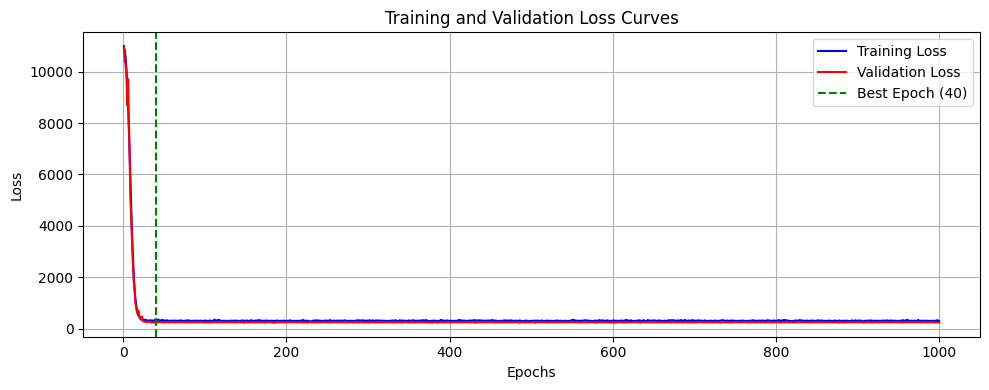

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.axvline(x=best_epoch+1, color='g', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.tight_layout()
plt.show()


===== Train Dataset Metrics =====
Overall: MSE=254.9970, MAE=11.9406, RMSE=15.9686, R²=0.0045
Systolic: MSE=385.5871, MAE=15.1309, RMSE=19.6364, R²=0.0534
Diastolic: MSE=124.4071, MAE=8.7503, RMSE=11.1538, R²=-0.0444

===== Validation Dataset Metrics =====
Overall: MSE=232.6741, MAE=11.7480, RMSE=15.2537, R²=0.0589
Systolic: MSE=345.6967, MAE=14.5808, RMSE=18.5929, R²=0.1563
Diastolic: MSE=119.6515, MAE=8.9152, RMSE=10.9385, R²=-0.0385

===== Test Dataset Metrics =====
Overall: MSE=280.1404, MAE=12.3743, RMSE=16.7374, R²=-0.0331
Systolic: MSE=397.8346, MAE=14.7955, RMSE=19.9458, R²=0.0861
Diastolic: MSE=162.4461, MAE=9.9532, RMSE=12.7454, R²=-0.1524

Plotting Test Dataset (first 100 samples)...


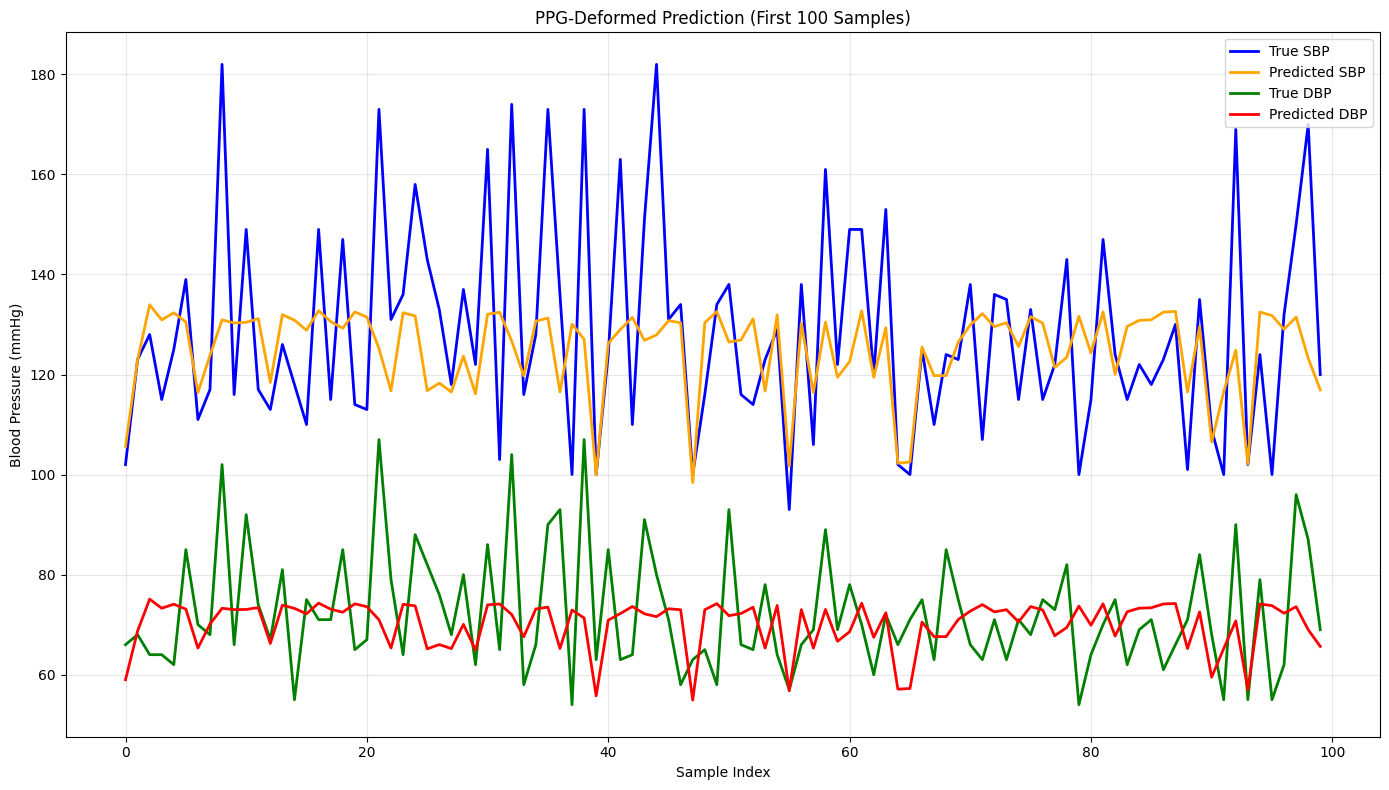


Plotting Validation Dataset (first 100 samples)...


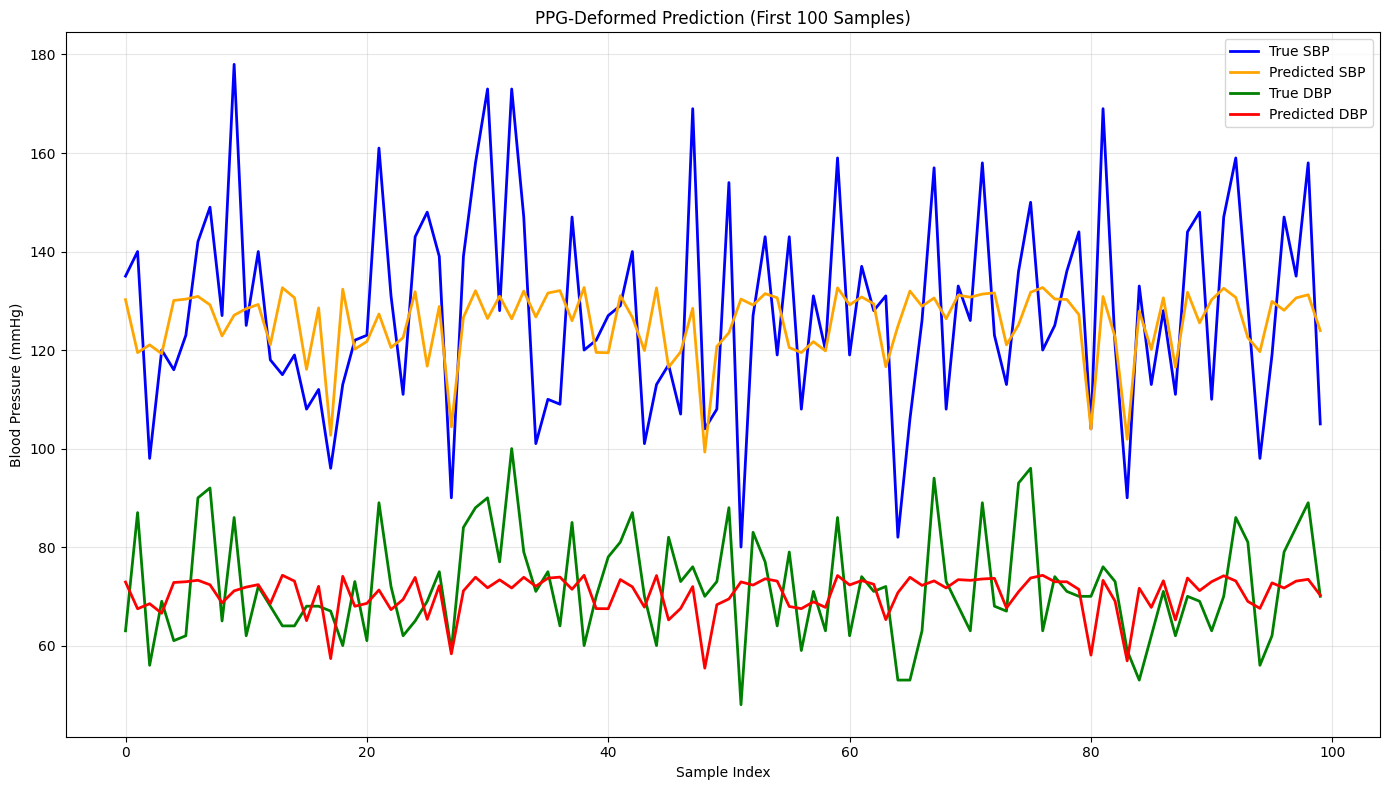


Plotting Training Dataset (first 100 samples)...


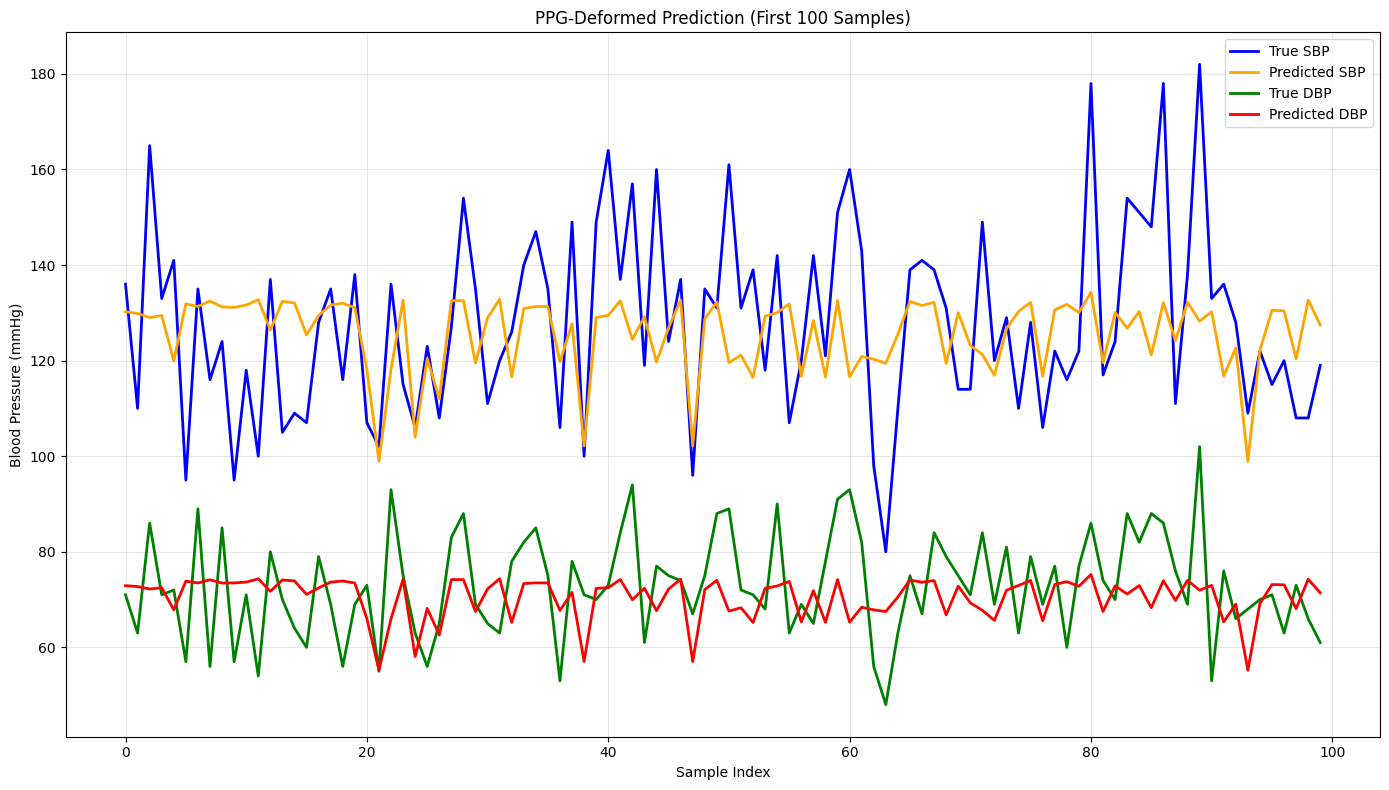

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch

def calculate_metrics(y_true, y_pred):
    """Calculate MSE, MAE, RMSE, and R² metrics"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

def evaluate_dataset(model, data_loader, device, dataset_name):
    """Evaluate the model on a specific dataset"""
    model.eval()
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            all_y_true.append(y.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())

    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)

    # Overall metrics
    mse, mae, rmse, r2 = calculate_metrics(y_true, y_pred)

    # Systolic BP metrics
    sys_mse, sys_mae, sys_rmse, sys_r2 = calculate_metrics(y_true[:, 0], y_pred[:, 0])

    # Diastolic BP metrics
    dia_mse, dia_mae, dia_rmse, dia_r2 = calculate_metrics(y_true[:, 1], y_pred[:, 1])

    print(f"\n===== {dataset_name} Dataset Metrics =====")
    print(f"Overall: MSE={mse:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")
    print(f"Systolic: MSE={sys_mse:.4f}, MAE={sys_mae:.4f}, RMSE={sys_rmse:.4f}, R²={sys_r2:.4f}")
    print(f"Diastolic: MSE={dia_mse:.4f}, MAE={dia_mae:.4f}, RMSE={dia_rmse:.4f}, R²={dia_r2:.4f}")

    return y_true, y_pred

def plot_first_100_samples(y_true, y_pred):
    """
    Plot the first 100 samples of true vs predicted blood pressure values
    """
    # Get first 100 samples (or less if fewer samples are available)
    num_samples = min(100, len(y_true))

    # Extract systolic and diastolic values
    true_sbp = y_true[:num_samples, 0]
    pred_sbp = y_pred[:num_samples, 0]
    true_dbp = y_true[:num_samples, 1]
    pred_dbp = y_pred[:num_samples, 1]

    # Create x-axis for sample indices
    sample_indices = np.arange(num_samples)

    # Create plot
    plt.figure(figsize=(14, 8))

    # Plot systolic values
    plt.plot(sample_indices, true_sbp, 'b-', linewidth=2, label='True SBP')
    plt.plot(sample_indices, pred_sbp, 'orange', linewidth=2, label='Predicted SBP')

    # Plot diastolic values
    plt.plot(sample_indices, true_dbp, 'g-', linewidth=2, label='True DBP')
    plt.plot(sample_indices, pred_dbp, 'r-', linewidth=2, label='Predicted DBP')

    # Add labels and legend
    plt.xlabel('Sample Index')
    plt.ylabel('Blood Pressure (mmHg)')
    plt.title('PPG-Deformed Prediction (First 100 Samples)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    # Show plot
    plt.tight_layout()
    plt.show()

# Main evaluation code
def run_full_evaluation(model, train_loader, val_loader, test_loader, device):
    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    model.to(device)

    # Evaluate on all datasets
    train_true, train_pred = evaluate_dataset(model, train_loader, device, "Train")
    val_true, val_pred = evaluate_dataset(model, val_loader, device, "Validation")
    test_true, test_pred = evaluate_dataset(model, test_loader, device, "Test")

    # Plot first 100 samples for each dataset
    print("\nPlotting Test Dataset (first 100 samples)...")
    plot_first_100_samples(test_true, test_pred)

    print("\nPlotting Validation Dataset (first 100 samples)...")
    plot_first_100_samples(val_true, val_pred)

    print("\nPlotting Training Dataset (first 100 samples)...")
    plot_first_100_samples(train_true, train_pred)

run_full_evaluation(model, train_loader, val_loader, test_loader, device)
